# Packages used

In [1]:
!conda list
!which python
!python --version
!jupyter kernelspec list

# packages in environment at /Users/douglas/anaconda3/envs/cobra_venv_V2_4solver:
#
# Name                    Version                   Build  Channel
annotated-types           0.7.0              pyhd8ed1ab_0    conda-forge
anyio                     4.2.0           py311hecd8cb5_0  
appdirs                   1.4.4              pyh9f0ad1d_0    conda-forge
appnope                   0.1.2           py311hecd8cb5_1001  
argon2-cffi               21.3.0             pyhd3eb1b0_0  
argon2-cffi-bindings      21.2.0          py311h6c40b1e_0  
asttokens                 2.0.5              pyhd3eb1b0_0  
async-lru                 2.0.4           py311hecd8cb5_0  
attrs                     23.1.0          py311hecd8cb5_0  
babel                     2.11.0          py311hecd8cb5_0  
beautifulsoup4            4.12.3          py311hecd8cb5_0  
blas                      1.0                    openblas  
bleach                    4.1.0              pyhd3eb1b0_0  
brotli                    1.0.9         

# Data
Input: Recon3D.mat, model groups from Section 5

# Loading the file

In [2]:
import scipy.io
import cobra
from cobra.io import load_matlab_model
import sys
print(sys.executable)

# Path to your .mat file
file_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0_limited_5/NT001_W5D2T0.mat'

# Load the .mat file using scipy
#mat = scipy.io.loadmat(file_path)

# Convert the loaded .mat content to a COBRA model
model = load_matlab_model(file_path)

# Print basic information about the model
print(f'Model ID: {model.id}')
print(f'Number of Reactions: {len(model.reactions)}')
print(f'Number of Metabolites: {len(model.metabolites)}')
print(f'Number of Genes: {len(model.genes)}')

# Display some reactions
for reaction in model.reactions[:10]:  # Print the first 10 reactions as an example
    print(reaction)

/Users/douglas/anaconda3/envs/cobra_venv_V2_4solver/bin/python
Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-03


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Model ID: model
Number of Reactions: 2239
Number of Metabolites: 2343
Number of Genes: 2248
2HBO: 2hb[c] + nad[c] <=> 2obut[c] + h[c] + nadh[c]
2HBt2: 2hb[e] + h[e] <=> 2hb[c] + h[c]
34DHPHAMT: 34dhpha[c] + amet[c] --> ahcys[c] + h[c] + homoval[c]
34HPLFM: 34hpp[m] + h[m] + nadh[m] --> 34hpl[m] + nad[m]
3HBCOAHLm: 3hibutcoa[m] + h2o[m] --> 3hmp[m] + coa[m] + h[m]
3SALATAim: 3sala[m] + akg[m] + h[m] --> 3snpyr[m] + glu_L[m]
5ADTSTSTERONEGLCte: 5adtststeroneglc[c] + atp[c] + h2o[c] --> 5adtststeroneglc[e] + adp[c] + h[c] + pi[c]
A_MANASEly: 2.0 h2o[l] + m2mn[l] --> 2.0 man[l] + mn[l]
ABUTt2rL: 4abut[l] + h[l] <=> 4abut[c] + h[c]
ACACT10m: 2maacoa[m] + coa[m] <=> accoa[m] + ppcoa[m]


In [3]:
print(model.objective.expression)
print(model.objective.direction)

1.0*DM_atp_c_ - 1.0*DM_atp_c__reverse_5d8a2
max


In [4]:
solution = model.optimize()
print(solution)

<Solution 1000.000 at 0x143ce4910>


In [5]:
solution.objective_value

1000.0

In [6]:
%%time
model.optimize().objective_value

CPU times: user 41.8 ms, sys: 3.7 ms, total: 45.5 ms
Wall time: 44.1 ms


1000.0

In [7]:
model.summary()

In [8]:
ATP_rxn = model.reactions.get_by_id("DM_atp_c_")

In [9]:
ATP_rxn

<Reaction DM_atp_c_ at 0x143db0d50>

In [10]:
from cobra.util.solver import linear_reaction_coefficients
linear_reaction_coefficients(model)

{<Reaction DM_atp_c_ at 0x143db0d50>: 1.0}

# Flux PCA code below: 

# First Load the functions 

In [1]:
import os
import cobra
from cobra.io import load_matlab_model
import pandas as pd
from pathlib import Path
import numpy as np
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt

# Define the binary function to create binary matrices
def binary(model, ref_model):
    rxns = [1 if r in model.reactions else 0 for r in ref_model.reactions]
    mets = [1 if m in model.metabolites else 0 for m in ref_model.metabolites]
    genes = [1 if g in model.genes else 0 for g in ref_model.genes]
    return rxns, mets, genes

def flux_DM(df):
    z = zscores(df)
    DM = pd.DataFrame(squareform(pdist(z, metric='cosine')), index=z.index, columns=z.index)
    return 1 - abs(DM.corr())

def zscores(smpl):
    smpl = smpl.T

    idx = (smpl - smpl.mean()) / smpl.std()
    idx.fillna(0, inplace=True)
    # drop reaction if z score for that reaction is always zero
    to_drop = list(idx.sum()[idx.sum() == 0].index.values)
    idx.drop(to_drop, axis=1, inplace=True)

    return idx


# Load library function to process models
def load_library(pathlib, ref_model, sampling=False, FBA=False):
    reactions_matrix = pd.DataFrame(index=[r.id for r in ref_model.reactions])
    metabolite_matrix = pd.DataFrame(index=[m.id for m in ref_model.metabolites])
    gene_matrix = pd.DataFrame(index=[g.id for g in ref_model.genes])
    flx_df = pd.DataFrame(index=[r.id for r in ref_model.reactions])

    for filename in pathlib:
        model = load_matlab_model(filename)
        label = str(filename).split('.')[0]
        print('===================================================================')
        print('Loaded model', label)
        
        # 1: Make binary matrices
        rxns, mets, genes = binary(model, ref_model)
        reactions_matrix[label] = rxns
        metabolite_matrix[label] = mets
        gene_matrix[label] = genes

        # 2: FBA or Sampling, get 1 working
        if sampling:
            smp = cobra.sampling.sample(model, 1000, processes=1, seed=555555)
            flx_df[label] = smp.mean()

        if FBA:
            print('FBA...')
            #bm = [r.id for r in model.reactions if 'biomass' in r.id]
            #try:
               # bm.remove('EX_biomass(e)')
           # except ValueError:
                #pass
            
            model.objective = 'DM_atp_c_'
            #except:
                #model.objective = bm[0]
            sol = model.optimize()
            print(sol)
            sol.objective_value
            model.summary()
            flx_df[label] = sol.fluxes

    return reactions_matrix, metabolite_matrix, gene_matrix, flx_df


# W5D2T0, different code, FBA = true

In [13]:
# %% Load the context-specific models
directory_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0'
context_specific_models = []
for filename in os.listdir(directory_path):
    if filename.endswith(".mat"):
        file_path = os.path.join(directory_path, filename)
        model = load_matlab_model(file_path)
        context_specific_models.append(model)

print(f"Loaded {len(context_specific_models)} models.")

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in mod

Loaded 65 models.


In [14]:
path_ref = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/Recon3D.mat'
ref_model = load_matlab_model(path_ref)

# Convert the list of models to a list of paths
file_paths = [Path(os.path.join(directory_path, f)) for f in os.listdir(directory_path) if f.endswith(".mat")]

# Call the load_library function to get the flux dataframe
reactions_matrix, metabolite_matrix, gene_matrix, flx_df = load_library(file_paths, ref_model, sampling=False, FBA=True)
#rxn, met, gen, graphlist, flx = load_library(file_paths, ref_model, sampling= False, FBA= True)


# Check the flux data frame
print(flx_df.head())



This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model Recon3D. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT106_W5D2T0
FBA...
<Solution 1000.000 at 0x1ac603f10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT131_W5D2T0
FBA...
<Solution 1000.000 at 0x1acf5d150>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT025_W5D2T0
FBA...
<Solution 1000.000 at 0x1af295090>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT070_W5D2T0
FBA...
<Solution 1000.000 at 0x1afc4bc50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT082_W5D2T0
FBA...
<Solution 1000.000 at 0x1b23283d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT056_W5D2T0
FBA...
<Solution 1000.000 at 0x1b390c2d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT142_W5D2T0
FBA...
<Solution 1000.000 at 0x1b533bad0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT034_W5D2T0
FBA...
<Solution 1000.000 at 0x1b4a1ba50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT120_W5D2T0
FBA...
<Solution 1000.000 at 0x1b81f98d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT078_W5D2T0
FBA...
<Solution 1000.000 at 0x1ae586c50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT147_W5D2T0
FBA...
<Solution 1000.000 at 0x1b1cc25d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT064_W5D2T0
FBA...
<Solution 1000.000 at 0x1ad111150>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT125_W5D2T0
FBA...
<Solution 1000.000 at 0x1ad492410>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT006_W5D2T0
FBA...
<Solution 1000.000 at 0x1b8d98c50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT031_W5D2T0
FBA...
<Solution 1000.000 at 0x1b95df310>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT020_W5D2T0
FBA...
<Solution 1000.000 at 0x1bbb1fcd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT017_W5D2T0
FBA...
<Solution 1000.000 at 0x1bd2c1090>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT103_W5D2T0
FBA...
<Solution 1000.000 at 0x1aeac4310>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT118_W5D2T0
FBA...
<Solution 1000.000 at 0x1b2ea47d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT059_W5D2T0
FBA...
<Solution 1000.000 at 0x1ae59ba90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT133_W5D2T0
FBA...
<Solution 1000.000 at 0x1b9717e50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT104_W5D2T0
FBA...
<Solution 1000.000 at 0x1b6227fd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT027_W5D2T0
FBA...
<Solution 1000.000 at 0x1bda15710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT010_W5D2T0
FBA...
<Solution 1000.000 at 0x1bf124890>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT151_W5D2T0
FBA...
<Solution 1000.000 at 0x1c07d80d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT045_W5D2T0
FBA...
<Solution 1000.000 at 0x1bab00810>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT140_W5D2T0
FBA...
<Solution 1000.000 at 0x1b4c13a10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT001_W5D2T0
FBA...
<Solution 1000.000 at 0x1b96df7d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT145_W5D2T0
FBA...
<Solution 1000.000 at 0x1b400f3d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT051_W5D2T0
FBA...
<Solution 1000.000 at 0x1bd8e32d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT066_W5D2T0
FBA...
<Solution 1000.000 at 0x1c1c5cfd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT018_W5D2T0
FBA...
<Solution 1000.000 at 0x1c33af310>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT009_W5D2T0
FBA...
<Solution 1000.000 at 0x1c4b157d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT148_W5D2T0
FBA...
<Solution 1000.000 at 0x1c61dec10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT015_W5D2T0
FBA...
<Solution 1000.000 at 0x1bb13c210>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT077_W5D2T0
FBA...
<Solution 1000.000 at 0x1bda1e950>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT146_W5D2T0
FBA...
<Solution 1000.000 at 0x1b1b2e750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT065_W5D2T0
FBA...
<Solution 1000.000 at 0x1c03b9e90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT021_W5D2T0
FBA...
<Solution 1000.000 at 0x1c02ba6d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT043_W5D2T0
FBA...
<Solution 1000.000 at 0x1c54b4450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT129_W5D2T0
FBA...
<Solution 1000.000 at 0x1c7dca010>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT013_W5D2T0
FBA...
<Solution 1000.000 at 0x1c94f1490>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT152_W5D2T0
FBA...
<Solution 1000.000 at 0x1cacc69d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT038_W5D2T0
FBA...
<Solution 1000.000 at 0x1bfb0c550>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT057_W5D2T0
FBA...
<Solution 1000.000 at 0x1bb9cd290>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT143_W5D2T0
FBA...
<Solution 1000.000 at 0x1be1ed310>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT035_W5D2T0
FBA...
<Solution 1000.000 at 0x1c71b2b50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT002_W5D2T0
FBA...
<Solution 1000.000 at 0x1be7e1a90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT067_W5D2T0
FBA...
<Solution 1000.000 at 0x1cb39d050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT032_W5D2T0
FBA...
<Solution 1000.000 at 0x1ccb18e50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT084_W5D2T0
FBA...
<Solution 1000.000 at 0x1ce22d790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT008_W5D2T0
FBA...
<Solution 1000.000 at 0x1cfb92810>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT023_W5D2T0
FBA...
<Solution 1000.000 at 0x1c480b550>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT137_W5D2T0
FBA...
<Solution 1000.000 at 0x1bb5103d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT076_W5D2T0
FBA...
<Solution 1000.000 at 0x1c1253a10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT041_W5D2T0
FBA...
<Solution 1000.000 at 0x1c4b39050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT089_W5D2T0
FBA...
<Solution 1000.000 at 0x1c870bb10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT090_W5D2T0
FBA...
<Solution 1000.000 at 0x1ca3f7010>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT132_W5D2T0
FBA...
<Solution 1000.000 at 0x1d1234b50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT150_W5D2T0
FBA...
<Solution 1000.000 at 0x1d06e3d50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT044_W5D2T0
FBA...
<Solution 1000.000 at 0x1d3e0f290>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT055_W5D2T0
FBA...
<Solution 1000.000 at 0x1d55fb710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT141_W5D2T0
FBA...
<Solution 1000.000 at 0x1c71b8a90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT114_W5D2T0
FBA...
<Solution 1000.000 at 0x1c17b9a50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT123_W5D2T0
FBA...
<Solution 1000.000 at 0x1c00c2a90>
                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT106_W5D2T0  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                              
25HVITD3t                                                          NaN                                                                    

In [15]:
reactions_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT106_W5D2T0  \
24_25DHVITD3tm                                                       0                                                                                                                                                                                                              
25HVITD3t                                                            0                                                                                                                                                                                                              
COAtl                                                                0                                                                                                                                                                                                              
EX_5adtststerone_e                                                   0                                                                                                                                                                                                              
EX_5adtststerones_e                                                  0                                                                                                                                                                                                              
...                                                                ...                                                                                                                                                                                                              
ACMPGLUTTRsc                                                         0                                                                                                                                                                                                              
FVSCOAhc                                                             0                                                                                                                                                                                                              
MDZGLChr                                                             0                                                                                                                                                                                                              
TMACMPhr                                                             0                                                                                                                                                                                                              
CYSACMPitr                                                           0                                                                                                                                                                                                              

                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT131_W5D2T0  \
24_25DHVITD3tm                                                       0                                                                                                                                                                                                              
25HVITD3t                                                            0                                                                        

In [16]:
metabolite_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT106_W5D2T0  \
10fthf_c                                                       0                                                                                                                                                                                                              
10fthf_l                                                       0                                                                                                                                                                                                              
10fthf_m                                                       0                                                                                                                                                                                                              
11docrtsl_c                                                    0                                                                                                                                                                                                              
11docrtsl_m                                                    0                                                                                                                                                                                                              
...                                                          ...                                                                                                                                                                                                              
caproic_e                                                      0                                                                                                                                                                                                              
1a25dhvitd2_c                                                  0                                                                                                                                                                                                              
1a25dhvitd2_e                                                  0                                                                                                                                                                                                              
protein_c                                                      0                                                                                                                                                                                                              
h_i                                                            0                                                                                                                                                                                                              

               /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT131_W5D2T0  \
10fthf_c                                                       0                                                                                                                                                                                                              
10fthf_l                                                       0                                                                                                                                                            

In [17]:
gene_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT106_W5D2T0  \
0                                                          1                                                                                                                                                                                                              
26_AT1                                                     0                                                                                                                                                                                                              
314_AT1                                                    0                                                                                                                                                                                                              
8639_AT1                                                   0                                                                                                                                                                                                              
314_AT2                                                    0                                                                                                                                                                                                              
...                                                      ...                                                                                                                                                                                                              
27089_AT1                                                  0                                                                                                                                                                                                              
10975_AT1                                                  0                                                                                                                                                                                                              
7381_AT1                                                   0                                                                                                                                                                                                              
29796_AT1                                                  0                                                                                                                                                                                                              
4519_AT1                                                   0                                                                                                                                                                                                              

           /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT131_W5D2T0  \
0                                                          1                                                                                                                                                                                                              
26_AT1                                                     0                                                                                                                                                                                                              
314_A

In [18]:
flx_df

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT106_W5D2T0  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                              
25HVITD3t                                                          NaN                                                                                                                                                                                                              
COAtl                                                              NaN                                                                                                                                                                                                              
EX_5adtststerone_e                                                 NaN                                                                                                                                                                                                              
EX_5adtststerones_e                                                NaN                                                                                                                                                                                                              
...                                                                ...                                                                                                                                                                                                              
ACMPGLUTTRsc                                                       NaN                                                                                                                                                                                                              
FVSCOAhc                                                           NaN                                                                                                                                                                                                              
MDZGLChr                                                           NaN                                                                                                                                                                                                              
TMACMPhr                                                           NaN                                                                                                                                                                                                              
CYSACMPitr                                                         NaN                                                                                                                                                                                                              

                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T0/NT131_W5D2T0  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                              
25HVITD3t                                                          NaN                                                                        

from ninas code
```python
ref_model = cobra.io.mat.load_matlab_model(path_ref)
rxn, met, gen, graphlist, flx = load_library(path_lib, ref_model, graph=True, sampling=True, FBA=False)

#%% Perform flux correlation between pairs of models
pw_flx = flux_DM(flx)

pca = PCA(n_components=2)
pcaData = pca.fit_transform(pw_flx)
print(pca.explained_variance_ratio_)
```

In [19]:
#%% Perform flux correlation between pairs of models
pw_flx1 = flux_DM(flx_df)
pw_flx1
# Save pw_flx1 as a CSV file
pw_flx1.to_csv('pw_flx1.csv', index=False)

figure out what idx.drop is doing and if flx_df is compatible , why or why not?

[0.37824503 0.32473143 0.13652004]


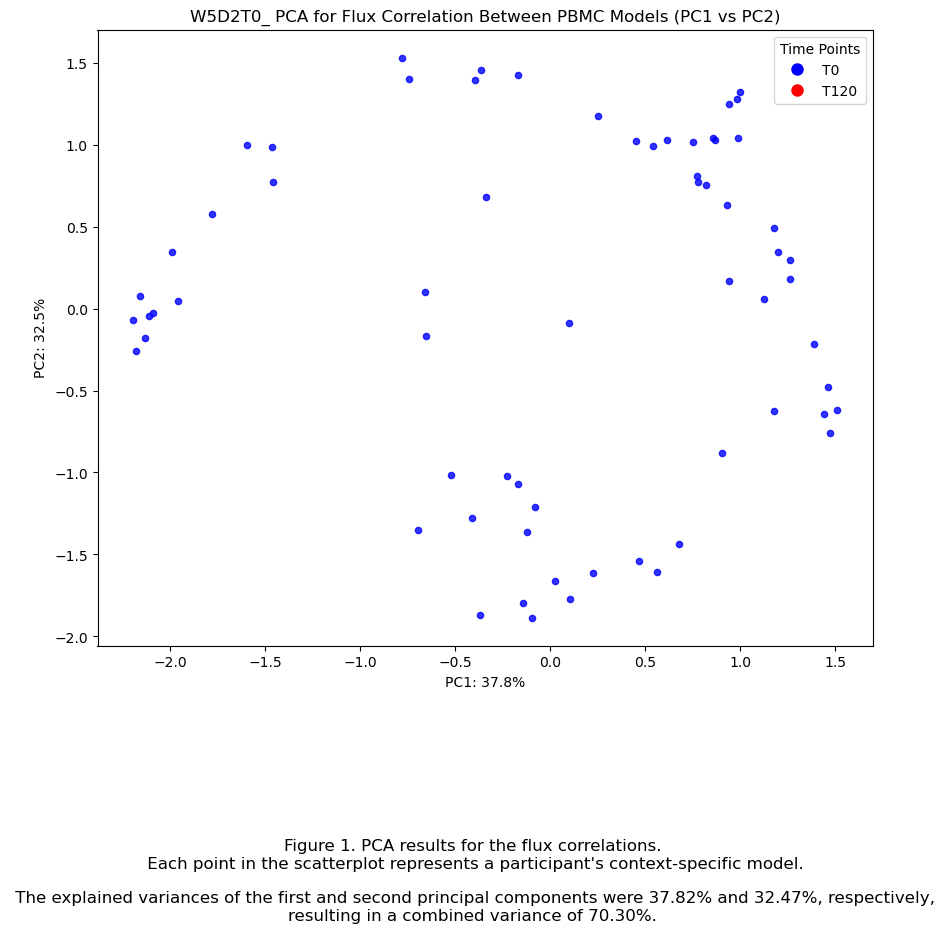

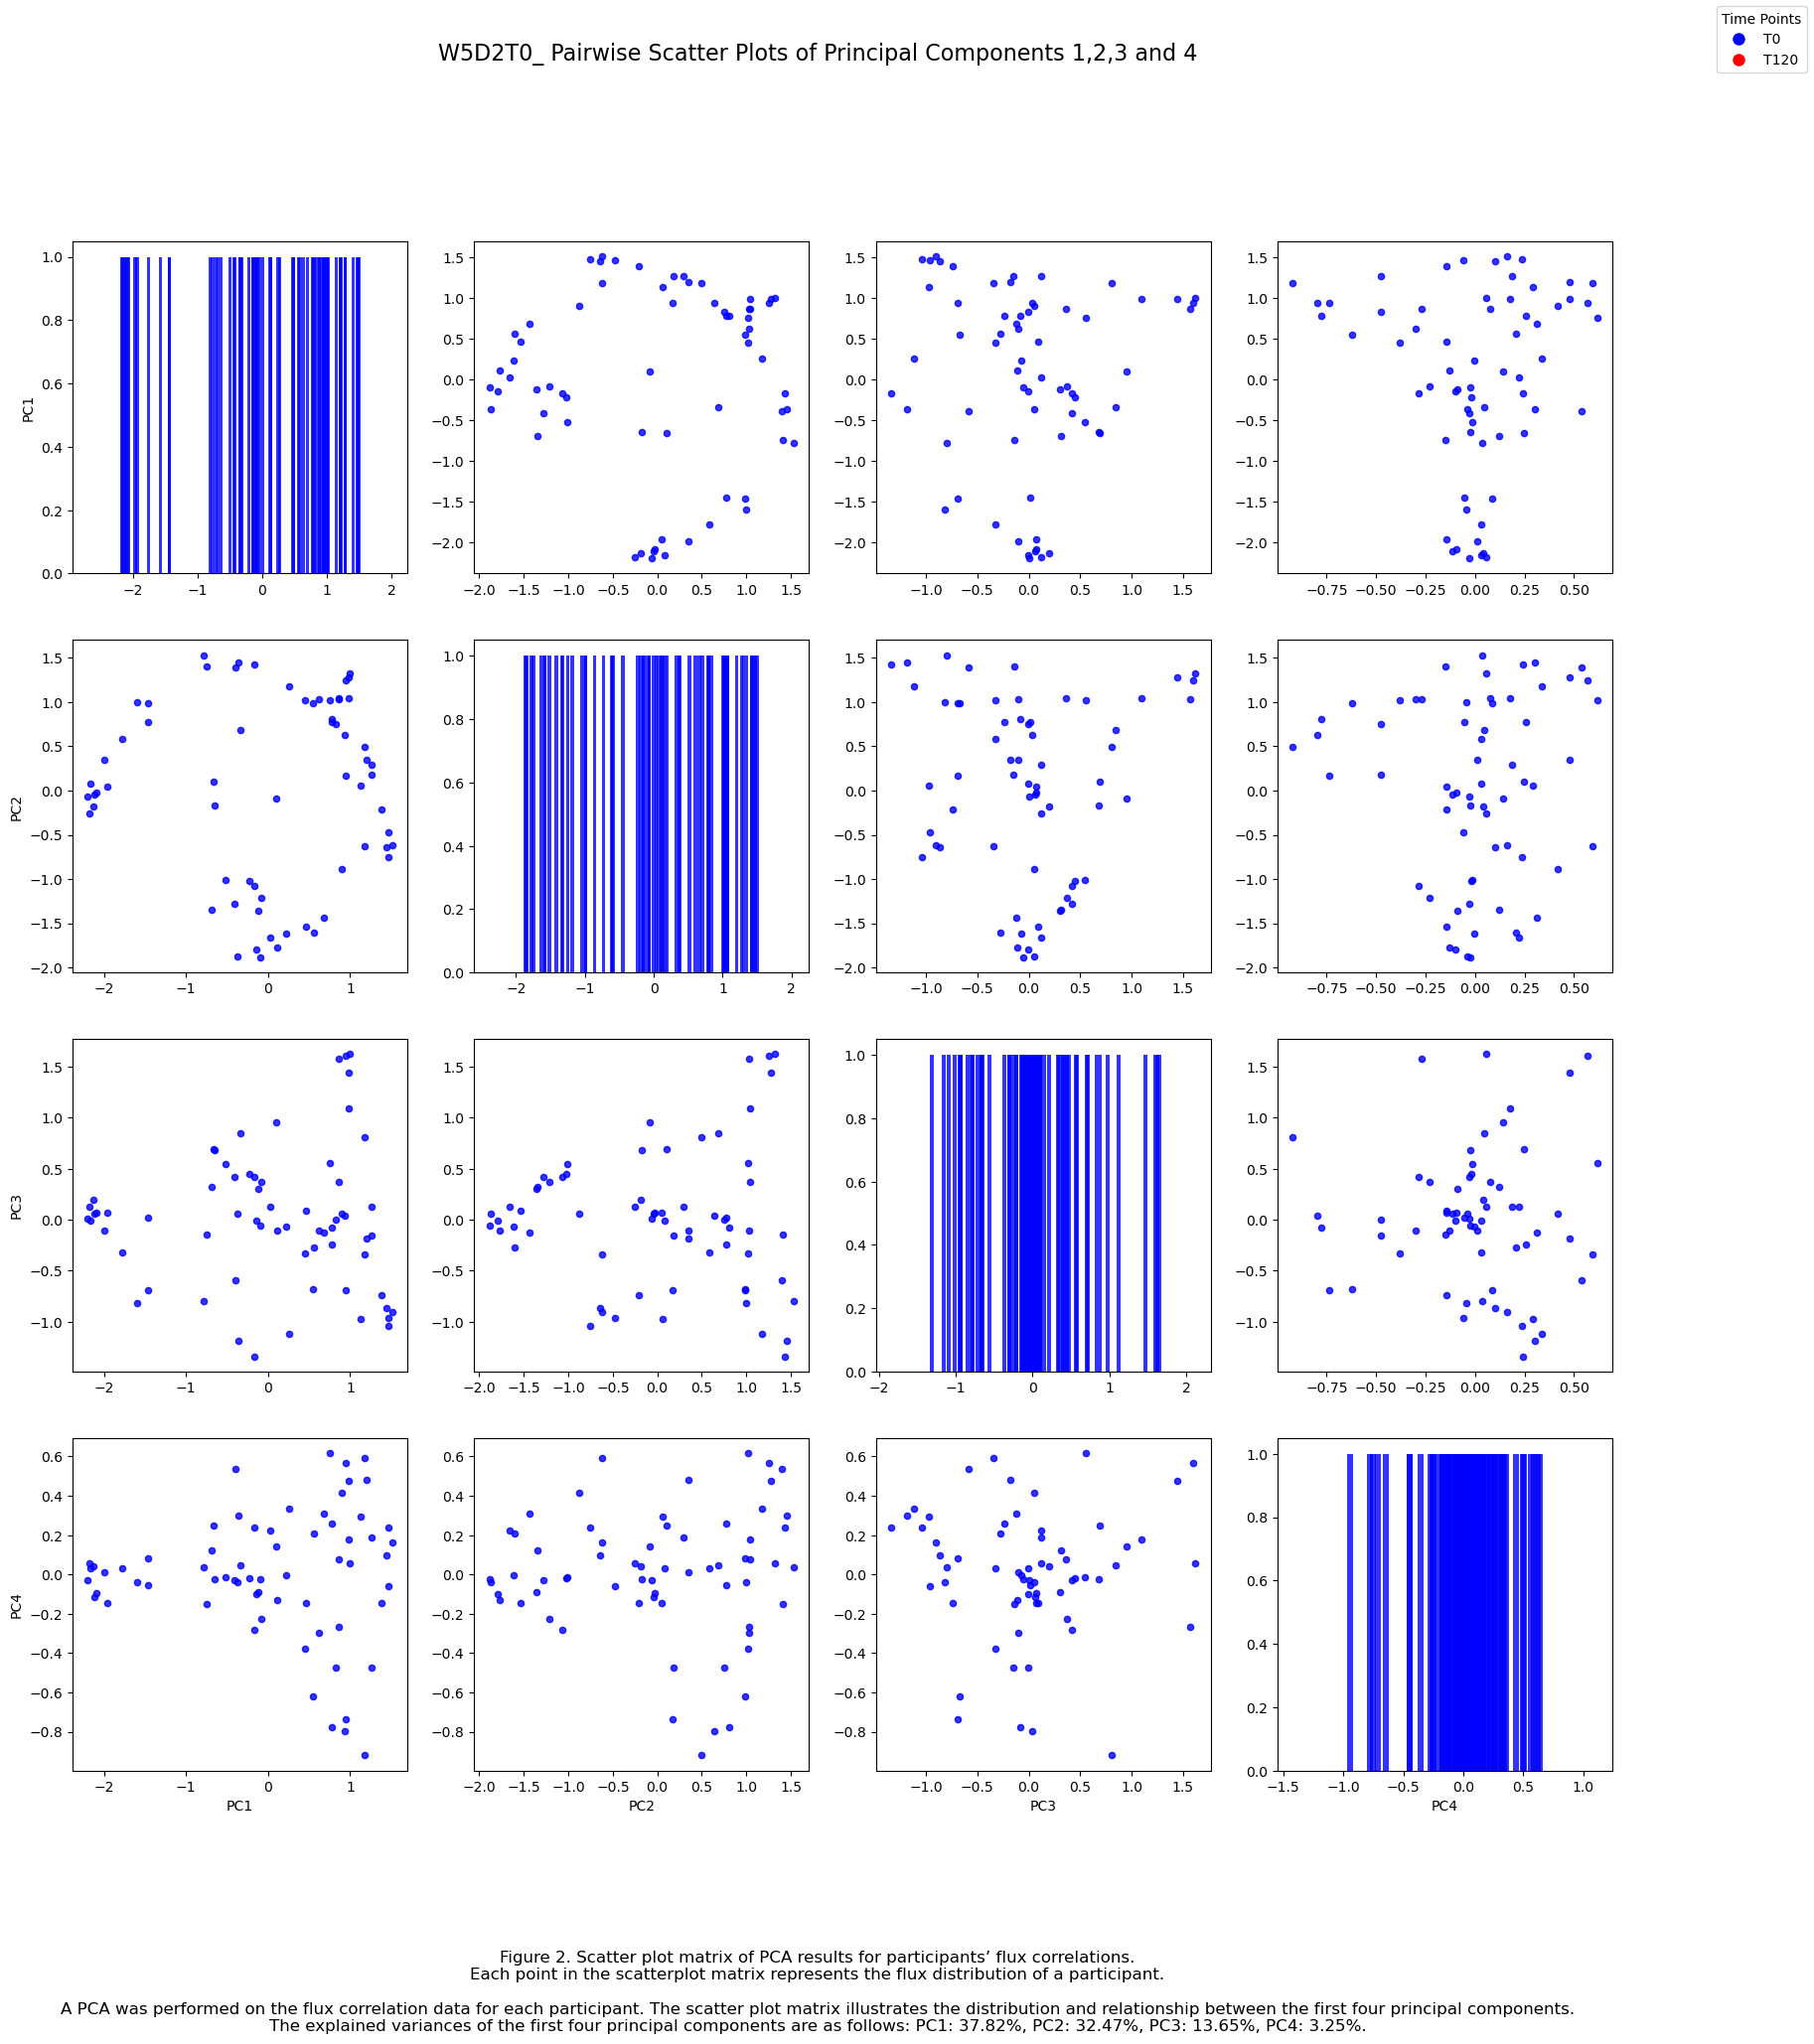

In [6]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your pw_flx3 data from the CSV file
pw_flxload = pd.read_csv('pw_flx1.csv')

# Extract sample labels (T0 or T120) from the column names
labels = [col.split('T')[-1] for col in pw_flxload.columns]

# Set the file_ID for naming plots and saved figures
file_ID = 'W5D2T0_'

# Perform PCA
pca = PCA(n_components=3)
pcaData = pca.fit_transform(pw_flxload.T)  # Transpose to make samples as rows
print(pca.explained_variance_ratio_)

title_font = {
    'weight': 'medium',
    'size': 12,
}
axis_font = {
    'weight': 'normal',
    'size': 10,
}

# Color coding based on time points
colors = ['blue' if label == '0' else 'red' for label in labels]

# Plot PCA scatter plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
for i in range(len(labels)):
    xs = pcaData[i, 0]
    ys = pcaData[i, 1]
    plt.scatter(xs, ys, s=20, marker='o', color=colors[i], alpha=0.8)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120')]
plt.legend(handles=handles, title="Time Points")

plt.title(f'{file_ID} PCA for Flux Correlation Between PBMC Models (PC1 vs PC2)', title_font)
plt.xlabel('PC1: {:.1%}'.format(pca.explained_variance_ratio_[0]), axis_font)
plt.ylabel('PC2: {:.1%}'.format(pca.explained_variance_ratio_[1]), axis_font)
plt.figtext(0.5, -0.23, (f'Figure 1. PCA results for the flux correlations.\n Each point in the scatterplot represents a participant\'s context-specific model.\n\n The explained variances of the first and second principal components were {pca.explained_variance_ratio_[0]*100:.2f}% and {pca.explained_variance_ratio_[1]*100:.2f}%, respectively, resulting in a combined variance of {((pca.explained_variance_ratio_[0]*100)+(pca.explained_variance_ratio_[1]*100)):.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'{file_ID}fig.1_PCA_for_Flux_Correlation.png', dpi=1000)

####################### Create a 4x4 plot matrix of PC1, PC2, PC3, and PC4
# Perform PCA
pca = PCA(n_components=4)
pcaData = pca.fit_transform(pw_flxload.T)
explained_variance = pca.explained_variance_ratio_

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

pc_labels = ['PC1', 'PC2', 'PC3', 'PC4']
components = [pcaData[:, 0], pcaData[:, 1], pcaData[:, 2], pcaData[:, 3]]

for i in range(4):
    for j in range(4):
        if i == j:
            for k, c in zip(components[i], colors):
                axs[i, j].hist(k, bins=20, color=c, alpha=0.8)
        else:
            for x, y, c in zip(components[j], components[i], colors):
                axs[i, j].scatter(x, y, color=c, s=20, alpha=0.8)
        if i == 3:
            axs[i, j].set_xlabel(pc_labels[j])
        if j == 0:
            axs[i, j].set_ylabel(pc_labels[i])

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120')]
fig.legend(handles=handles, title="Time Points", loc='upper right')

plt.suptitle(f'{file_ID} Pairwise Scatter Plots of Principal Components 1,2,3 and 4', fontsize=16, weight='medium')
plt.figtext(0.5, -0.02, (f'Figure 2. Scatter plot matrix of PCA results for participants’ flux correlations.\n'
                         f'Each point in the scatterplot matrix represents the flux distribution of a participant.\n\n'
                         f'A PCA was performed on the flux correlation data for each participant. The scatter plot matrix illustrates the distribution and relationship between the first four principal components.\n'
                         f'The explained variances of the first four principal components are as follows: PC1: {explained_variance[0]*100:.2f}%, PC2: {explained_variance[1]*100:.2f}%, PC3: {explained_variance[2]*100:.2f}%, PC4: {explained_variance[3]*100:.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)

plt.savefig(f'{file_ID}fig.2_Pairwise_Scatter_Plots_of_PC1_to_PC4.png', dpi=1000)
plt.show()


# W5D2T120, code from docs, FBA = true

In [21]:
# %% Load the context-specific models
directory_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120'
context_specific_models = []
for filename in os.listdir(directory_path):
    if filename.endswith(".mat"):
        file_path = os.path.join(directory_path, filename)
        model = load_matlab_model(file_path)
        context_specific_models.append(model)

print(f"Loaded {len(context_specific_models)} models.")

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in mod

Loaded 65 models.


from ninas code
```python
ref_model = cobra.io.mat.load_matlab_model(path_ref)
rxn, met, gen, graphlist, flx = load_library(path_lib, ref_model, graph=True, sampling=True, FBA=False)

#%% Perform flux correlation between pairs of models
pw_flx2 = flux_DM(flx)

pca = PCA(n_components=2)
pcaData = pca.fit_transform(pw_flx2)
print(pca.explained_variance_ratio_)
```

In [22]:
path_ref = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/Recon3D.mat'
ref_model = load_matlab_model(path_ref)

# Convert the list of models to a list of paths
file_paths = [Path(os.path.join(directory_path, f)) for f in os.listdir(directory_path) if f.endswith(".mat")]

# Call the load_library function to get the flux dataframe
reactions_matrix, metabolite_matrix, gene_matrix, flx_df = load_library(file_paths, ref_model, sampling=False, FBA=True)
#rxn, met, gen, graphlist, flx = load_library(file_paths, ref_model, sampling= False, FBA= True)


# Check the flux data frame
print(flx_df.head())



This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model Recon3D. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT038_W5D2T120
FBA...
<Solution 1000.000 at 0x1a5c0b590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT148_W5D2T120
FBA...
<Solution 1000.000 at 0x1a75e4490>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT078_W5D2T120
FBA...
<Solution 1000.000 at 0x1ab4b5cd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT009_W5D2T120
FBA...
<Solution 1000.000 at 0x1aa2f8b50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT008_W5D2T120
FBA...
<Solution 1000.000 at 0x197657010>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT010_W5D2T120
FBA...
<Solution 1000.000 at 0x1995de710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT045_W5D2T120
FBA...
<Solution 1000.000 at 0x19b1374d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT132_W5D2T120
FBA...
<Solution 1000.000 at 0x19cb69110>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT017_W5D2T120
FBA...
<Solution 1000.000 at 0x19eb80d50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT120_W5D2T120
FBA...
<Solution 1000.000 at 0x1a5273790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT002_W5D2T120
FBA...
<Solution 1000.000 at 0x1fd6d9350>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT057_W5D2T120
FBA...
<Solution 1000.000 at 0x19773aa50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT066_W5D2T120
FBA...
<Solution 1000.000 at 0x18e0e8cd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT143_W5D2T120
FBA...
<Solution 1000.000 at 0x19b0c3a90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT034_W5D2T120
FBA...
<Solution 1000.000 at 0x19744b710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT021_W5D2T120
FBA...
<Solution 1000.000 at 0x198bc4290>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT103_W5D2T120
FBA...
<Solution 1000.000 at 0x1fdf32590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT104_W5D2T120
FBA...
<Solution 1000.000 at 0x1ff6bb6d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT151_W5D2T120
FBA...
<Solution 1000.000 at 0x200d0a6d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT051_W5D2T120
FBA...
<Solution 1000.000 at 0x2024108d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT056_W5D2T120
FBA...
<Solution 1000.000 at 0x203c65610>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT043_W5D2T120
FBA...
<Solution 1000.000 at 0x1aa5f4a90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT133_W5D2T120
FBA...
<Solution 1000.000 at 0x197739a90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT044_W5D2T120
FBA...
<Solution 1000.000 at 0x19a51a590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT150_W5D2T120
FBA...
<Solution 1000.000 at 0x1a950d650>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT027_W5D2T120
FBA...
<Solution 1000.000 at 0x1a0409810>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT020_W5D2T120
FBA...
<Solution 1000.000 at 0x1fdc95c10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT035_W5D2T120
FBA...
<Solution 1000.000 at 0x19fa74290>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT142_W5D2T120
FBA...
<Solution 1000.000 at 0x20559c490>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT067_W5D2T120
FBA...
<Solution 1000.000 at 0x206bdbd10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT032_W5D2T120
FBA...
<Solution 1000.000 at 0x2082f3410>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT145_W5D2T120
FBA...
<Solution 1000.000 at 0x2099f9450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT123_W5D2T120
FBA...
<Solution 1000.000 at 0x1a04064d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT001_W5D2T120
FBA...
<Solution 1000.000 at 0x1a5a49fd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT006_W5D2T120
FBA...
<Solution 1000.000 at 0x203007450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT013_W5D2T120
FBA...
<Solution 1000.000 at 0x19f9fefd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT131_W5D2T120
FBA...
<Solution 1000.000 at 0x20010b390>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT041_W5D2T120
FBA...
<Solution 1000.000 at 0x2036e9290>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT077_W5D2T120
FBA...
<Solution 1000.000 at 0x20a6ac2d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT025_W5D2T120
FBA...
<Solution 1000.000 at 0x20bda9fd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT070_W5D2T120
FBA...
<Solution 1000.000 at 0x20d477990>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT152_W5D2T120
FBA...
<Solution 1000.000 at 0x20eb98250>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT147_W5D2T120
FBA...
<Solution 1000.000 at 0x20b1a8810>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT065_W5D2T120
FBA...
<Solution 1000.000 at 0x20212e250>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT140_W5D2T120
FBA...
<Solution 1000.000 at 0x202f368d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT137_W5D2T120
FBA...
<Solution 1000.000 at 0x1ab00c590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT015_W5D2T120
FBA...
<Solution 1000.000 at 0x20b6efb10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT125_W5D2T120
FBA...
<Solution 1000.000 at 0x20a434e10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT055_W5D2T120
FBA...
<Solution 1000.000 at 0x208fd1990>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT141_W5D2T120
FBA...
<Solution 1000.000 at 0x20ae07ed0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT114_W5D2T120
FBA...
<Solution 1000.000 at 0x21181e750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT064_W5D2T120
FBA...
<Solution 1000.000 at 0x212f4cd50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT031_W5D2T120
FBA...
<Solution 1000.000 at 0x214594410>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT146_W5D2T120
FBA...
<Solution 1000.000 at 0x215dbd110>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT106_W5D2T120
FBA...
<Solution 1000.000 at 0x2111b8910>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT076_W5D2T120
FBA...
<Solution 1000.000 at 0x19be59190>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT023_W5D2T120
FBA...
<Solution 1000.000 at 0x2035fad90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT089_W5D2T120
FBA...
<Solution 1000.000 at 0x20f903010>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT084_W5D2T120
FBA...
<Solution 1000.000 at 0x20a68c290>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT018_W5D2T120
FBA...
<Solution 1000.000 at 0x2137f4190>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT090_W5D2T120
FBA...
<Solution 950.000 at 0x208bf7fd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT118_W5D2T120
FBA...
<Solution 1000.000 at 0x20f2cc050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT082_W5D2T120
FBA...
<Solution 1000.000 at 0x217af3f90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT059_W5D2T120
FBA...
<Solution 1000.000 at 0x2192225d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT129_W5D2T120
FBA...
<Solution 1000.000 at 0x219adb6d0>
                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT038_W5D2T120  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                                  
25HVITD3t                                                          NaN                                                        

In [23]:
reactions_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT038_W5D2T120  \
24_25DHVITD3tm                                                       0                                                                                                                                                                                                                  
25HVITD3t                                                            0                                                                                                                                                                                                                  
COAtl                                                                0                                                                                                                                                                                                                  
EX_5adtststerone_e                                                   0                                                                                                                                                                                                                  
EX_5adtststerones_e                                                  0                                                                                                                                                                                                                  
...                                                                ...                                                                                                                                                                                                                  
ACMPGLUTTRsc                                                         0                                                                                                                                                                                                                  
FVSCOAhc                                                             0                                                                                                                                                                                                                  
MDZGLChr                                                             0                                                                                                                                                                                                                  
TMACMPhr                                                             0                                                                                                                                                                                                                  
CYSACMPitr                                                           0                                                                                                                                                                                                                  

                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT148_W5D2T120  \
24_25DHVITD3tm                                                       0                                                                                                                                                                                                                  
25HVITD3t                                                            0                

In [24]:
metabolite_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT038_W5D2T120  \
10fthf_c                                                       0                                                                                                                                                                                                                  
10fthf_l                                                       0                                                                                                                                                                                                                  
10fthf_m                                                       0                                                                                                                                                                                                                  
11docrtsl_c                                                    0                                                                                                                                                                                                                  
11docrtsl_m                                                    0                                                                                                                                                                                                                  
...                                                          ...                                                                                                                                                                                                                  
caproic_e                                                      0                                                                                                                                                                                                                  
1a25dhvitd2_c                                                  0                                                                                                                                                                                                                  
1a25dhvitd2_e                                                  0                                                                                                                                                                                                                  
protein_c                                                      0                                                                                                                                                                                                                  
h_i                                                            0                                                                                                                                                                                                                  

               /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT148_W5D2T120  \
10fthf_c                                                       0                                                                                                                                                                                                                  
10fthf_l                                                       0                                                                                                    

In [25]:
gene_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT038_W5D2T120  \
0                                                          1                                                                                                                                                                                                                  
26_AT1                                                     0                                                                                                                                                                                                                  
314_AT1                                                    0                                                                                                                                                                                                                  
8639_AT1                                                   0                                                                                                                                                                                                                  
314_AT2                                                    0                                                                                                                                                                                                                  
...                                                      ...                                                                                                                                                                                                                  
27089_AT1                                                  0                                                                                                                                                                                                                  
10975_AT1                                                  0                                                                                                                                                                                                                  
7381_AT1                                                   0                                                                                                                                                                                                                  
29796_AT1                                                  0                                                                                                                                                                                                                  
4519_AT1                                                   0                                                                                                                                                                                                                  

           /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT148_W5D2T120  \
0                                                          1                                                                                                                                                                                                                  
26_AT1                                                     0                                                                                                                                                            

In [26]:
flx_df

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT038_W5D2T120  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                                  
25HVITD3t                                                          NaN                                                                                                                                                                                                                  
COAtl                                                              NaN                                                                                                                                                                                                                  
EX_5adtststerone_e                                                 NaN                                                                                                                                                                                                                  
EX_5adtststerones_e                                                NaN                                                                                                                                                                                                                  
...                                                                ...                                                                                                                                                                                                                  
ACMPGLUTTRsc                                                       NaN                                                                                                                                                                                                                  
FVSCOAhc                                                           NaN                                                                                                                                                                                                                  
MDZGLChr                                                           NaN                                                                                                                                                                                                                  
TMACMPhr                                                           NaN                                                                                                                                                                                                                  
CYSACMPitr                                                         NaN                                                                                                                                                                                                                  

                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T120/NT148_W5D2T120  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                                  
25HVITD3t                                                          NaN                

In [27]:
#%% Perform flux correlation between pairs of models
pw_flx2 = flux_DM(flx_df)
pw_flx2
# Save pw_flx1 as a CSV file
pw_flx2.to_csv('pw_flx2.csv', index=False)

figure out what idx.drop is doing and if flx_df is compatible , why or why not?

[0.54239113 0.16269086 0.09566434]


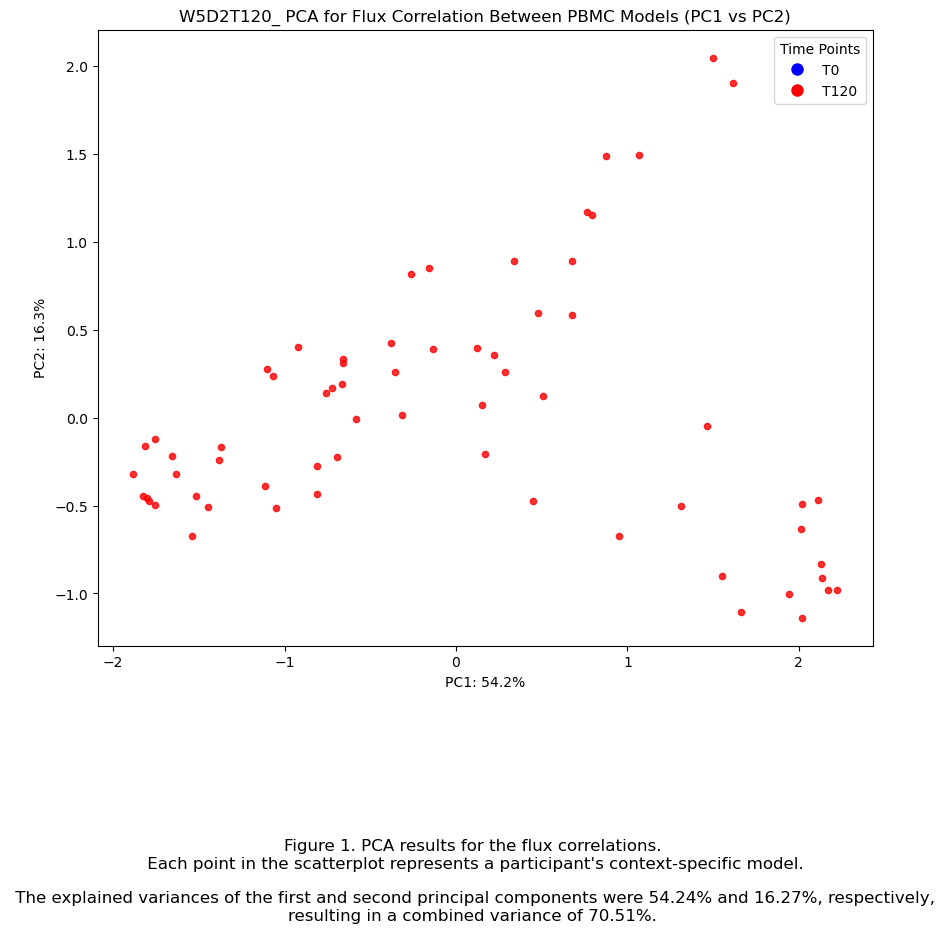

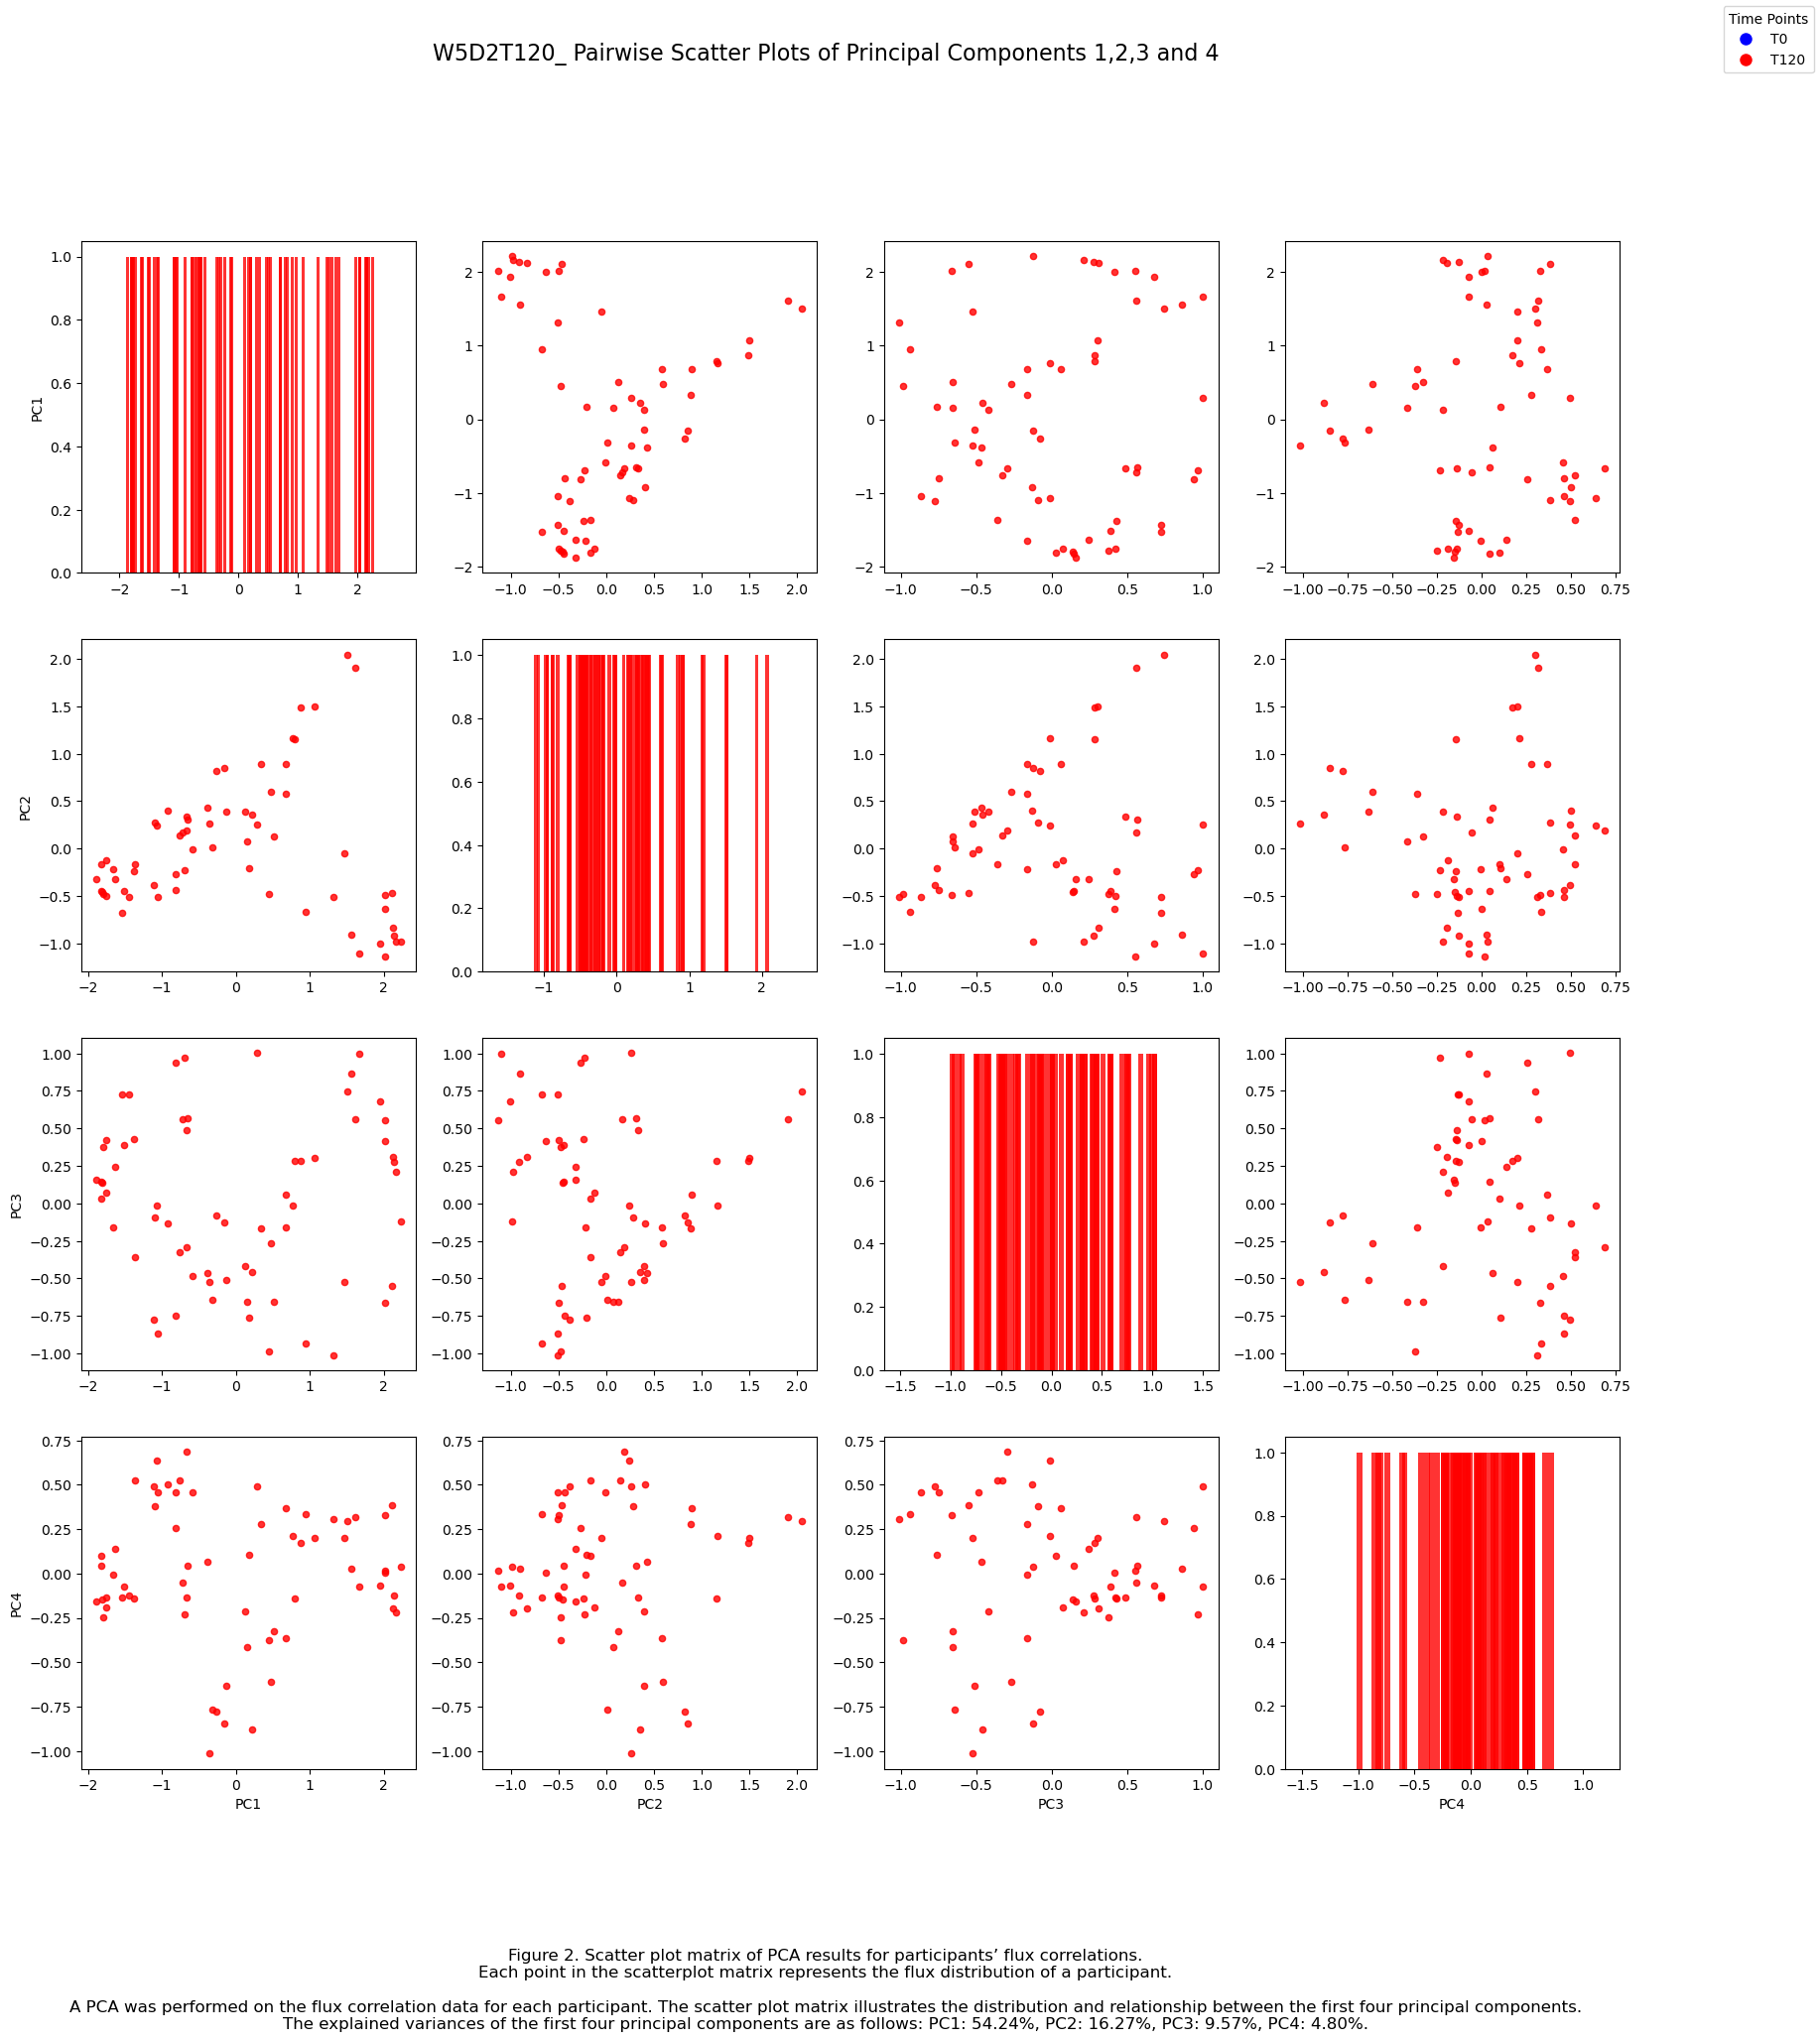

In [7]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your pw_flx3 data from the CSV file
pw_flxload = pd.read_csv('pw_flx2.csv')

# Extract sample labels (T0 or T120) from the column names
labels = [col.split('T')[-1] for col in pw_flxload.columns]

# Set the file_ID for naming plots and saved figures
file_ID = 'W5D2T120_'

# Perform PCA
pca = PCA(n_components=3)
pcaData = pca.fit_transform(pw_flxload.T)  # Transpose to make samples as rows
print(pca.explained_variance_ratio_)

title_font = {
    'weight': 'medium',
    'size': 12,
}
axis_font = {
    'weight': 'normal',
    'size': 10,
}

# Color coding based on time points
colors = ['blue' if label == '0' else 'red' for label in labels]

# Plot PCA scatter plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
for i in range(len(labels)):
    xs = pcaData[i, 0]
    ys = pcaData[i, 1]
    plt.scatter(xs, ys, s=20, marker='o', color=colors[i], alpha=0.8)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120')]
plt.legend(handles=handles, title="Time Points")

plt.title(f'{file_ID} PCA for Flux Correlation Between PBMC Models (PC1 vs PC2)', title_font)
plt.xlabel('PC1: {:.1%}'.format(pca.explained_variance_ratio_[0]), axis_font)
plt.ylabel('PC2: {:.1%}'.format(pca.explained_variance_ratio_[1]), axis_font)
plt.figtext(0.5, -0.23, (f'Figure 1. PCA results for the flux correlations.\n Each point in the scatterplot represents a participant\'s context-specific model.\n\n The explained variances of the first and second principal components were {pca.explained_variance_ratio_[0]*100:.2f}% and {pca.explained_variance_ratio_[1]*100:.2f}%, respectively, resulting in a combined variance of {((pca.explained_variance_ratio_[0]*100)+(pca.explained_variance_ratio_[1]*100)):.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'{file_ID}fig.1_PCA_for_Flux_Correlation.png', dpi=1000)

####################### Create a 4x4 plot matrix of PC1, PC2, PC3, and PC4
# Perform PCA
pca = PCA(n_components=4)
pcaData = pca.fit_transform(pw_flxload.T)
explained_variance = pca.explained_variance_ratio_

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

pc_labels = ['PC1', 'PC2', 'PC3', 'PC4']
components = [pcaData[:, 0], pcaData[:, 1], pcaData[:, 2], pcaData[:, 3]]

for i in range(4):
    for j in range(4):
        if i == j:
            for k, c in zip(components[i], colors):
                axs[i, j].hist(k, bins=20, color=c, alpha=0.8)
        else:
            for x, y, c in zip(components[j], components[i], colors):
                axs[i, j].scatter(x, y, color=c, s=20, alpha=0.8)
        if i == 3:
            axs[i, j].set_xlabel(pc_labels[j])
        if j == 0:
            axs[i, j].set_ylabel(pc_labels[i])

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120')]
fig.legend(handles=handles, title="Time Points", loc='upper right')

plt.suptitle(f'{file_ID} Pairwise Scatter Plots of Principal Components 1,2,3 and 4', fontsize=16, weight='medium')
plt.figtext(0.5, -0.02, (f'Figure 2. Scatter plot matrix of PCA results for participants’ flux correlations.\n'
                         f'Each point in the scatterplot matrix represents the flux distribution of a participant.\n\n'
                         f'A PCA was performed on the flux correlation data for each participant. The scatter plot matrix illustrates the distribution and relationship between the first four principal components.\n'
                         f'The explained variances of the first four principal components are as follows: PC1: {explained_variance[0]*100:.2f}%, PC2: {explained_variance[1]*100:.2f}%, PC3: {explained_variance[2]*100:.2f}%, PC4: {explained_variance[3]*100:.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)

plt.savefig(f'{file_ID}fig.2_Pairwise_Scatter_Plots_of_PC1_to_PC4.png', dpi=1000)
plt.show()


# W5D2T*, code from docs, FBA = true

In [29]:
# %% Load the context-specific models
directory_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*'
context_specific_models = []
for filename in os.listdir(directory_path):
    if filename.endswith(".mat"):
        file_path = os.path.join(directory_path, filename)
        model = load_matlab_model(file_path)
        context_specific_models.append(model)

print(f"Loaded {len(context_specific_models)} models.")

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in mod

Loaded 130 models.


from ninas code
```python
ref_model = cobra.io.mat.load_matlab_model(path_ref)
rxn, met, gen, graphlist, flx = load_library(path_lib, ref_model, graph=True, sampling=True, FBA=False)

#%% Perform flux correlation between pairs of models
pw_flx = flux_DM(flx)

pca = PCA(n_components=2)
pcaData = pca.fit_transform(pw_flx)
print(pca.explained_variance_ratio_)
```

In [30]:
path_ref = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/Recon3D.mat'
ref_model = load_matlab_model(path_ref)

# Convert the list of models to a list of paths
file_paths = [Path(os.path.join(directory_path, f)) for f in os.listdir(directory_path) if f.endswith(".mat")]

# Call the load_library function to get the flux dataframe
reactions_matrix, metabolite_matrix, gene_matrix, flx_df = load_library(file_paths, ref_model, sampling=False, FBA=True)
#rxn, met, gen, graphlist, flx = load_library(file_paths, ref_model, sampling= False, FBA= True)


# Check the flux data frame
print(flx_df.head())



This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model Recon3D. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT106_W5D2T0
FBA...
<Solution 1000.000 at 0x26cb950d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT131_W5D2T0
FBA...
<Solution 1000.000 at 0x190430bd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT038_W5D2T120
FBA...
<Solution 1000.000 at 0x19376ae10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT025_W5D2T0
FBA...
<Solution 1000.000 at 0x272c77b50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT148_W5D2T120
FBA...
<Solution 1000.000 at 0x2742ef8d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT070_W5D2T0
FBA...
<Solution 1000.000 at 0x275ae4390>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT078_W5D2T120
FBA...
<Solution 1000.000 at 0x277042b90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT082_W5D2T0
FBA...
<Solution 1000.000 at 0x2779bf050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT009_W5D2T120
FBA...
<Solution 1000.000 at 0x279e31e50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT056_W5D2T0
FBA...
<Solution 1000.000 at 0x27b463610>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT142_W5D2T0
FBA...
<Solution 1000.000 at 0x27ce5bcd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT034_W5D2T0
FBA...
<Solution 1000.000 at 0x27e4e6c50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT120_W5D2T0
FBA...
<Solution 1000.000 at 0x27ee2dbd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT078_W5D2T0
FBA...
<Solution 1000.000 at 0x281367790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT147_W5D2T0
FBA...
<Solution 1000.000 at 0x282a3e7d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT064_W5D2T0
FBA...
<Solution 1000.000 at 0x28404b150>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT125_W5D2T0
FBA...
<Solution 1000.000 at 0x285744450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT006_W5D2T0
FBA...
<Solution 1000.000 at 0x286ee0e10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT031_W5D2T0
FBA...
<Solution 1000.000 at 0x2884fff10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT008_W5D2T120
FBA...
<Solution 1000.000 at 0x27af49d50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT020_W5D2T0
FBA...
<Solution 1000.000 at 0x27ef66a90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT017_W5D2T0
FBA...
<Solution 1000.000 at 0x18e3e9a10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT103_W5D2T0
FBA...
<Solution 1000.000 at 0x27faaf4d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT010_W5D2T120
FBA...
<Solution 1000.000 at 0x2833d7190>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT045_W5D2T120
FBA...
<Solution 1000.000 at 0x18ff41d10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT118_W5D2T0
FBA...
<Solution 1000.000 at 0x1935fb950>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT132_W5D2T120
FBA...
<Solution 1000.000 at 0x28301a310>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT017_W5D2T120
FBA...
<Solution 1000.000 at 0x281019910>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT059_W5D2T0
FBA...
<Solution 1000.000 at 0x27edfc0d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT133_W5D2T0
FBA...
<Solution 1000.000 at 0x27bd94bd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT120_W5D2T120
FBA...
<Solution 1000.000 at 0x27a4d89d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT104_W5D2T0
FBA...
<Solution 1000.000 at 0x28a716d50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT027_W5D2T0
FBA...
<Solution 1000.000 at 0x28bf5df90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT010_W5D2T0
FBA...
<Solution 1000.000 at 0x28d617e50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT002_W5D2T120
FBA...
<Solution 1000.000 at 0x28ec8f010>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT057_W5D2T120
FBA...
<Solution 1000.000 at 0x290273210>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT151_W5D2T0
FBA...
<Solution 1000.000 at 0x2918bda50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT045_W5D2T0
FBA...
<Solution 1000.000 at 0x2930af290>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT066_W5D2T120
FBA...
<Solution 1000.000 at 0x290e7b310>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT143_W5D2T120
FBA...
<Solution 1000.000 at 0x2739fdc90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT034_W5D2T120
FBA...
<Solution 1000.000 at 0x29050ae90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT140_W5D2T0
FBA...
<Solution 1000.000 at 0x18f370510>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT001_W5D2T0
FBA...
<Solution 1000.000 at 0x27da44750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT021_W5D2T120
FBA...
<Solution 1000.000 at 0x27a99e710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT103_W5D2T120
FBA...
<Solution 1000.000 at 0x288ce03d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT104_W5D2T120
FBA...
<Solution 1000.000 at 0x28e1b5190>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT151_W5D2T120
FBA...
<Solution 1000.000 at 0x28fd74450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT145_W5D2T0
FBA...
<Solution 1000.000 at 0x278636250>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT051_W5D2T120
FBA...
<Solution 1000.000 at 0x28c8b7510>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT051_W5D2T0
FBA...
<Solution 1000.000 at 0x28c8058d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT066_W5D2T0
FBA...
<Solution 1000.000 at 0x28aebb890>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT056_W5D2T120
FBA...
<Solution 1000.000 at 0x295ee4650>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT043_W5D2T120
FBA...
<Solution 1000.000 at 0x2974b3290>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT018_W5D2T0
FBA...
<Solution 1000.000 at 0x298b16a90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT133_W5D2T120
FBA...
<Solution 1000.000 at 0x29a2a2450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT044_W5D2T120
FBA...
<Solution 1000.000 at 0x29ab6fa50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT150_W5D2T120
FBA...
<Solution 1000.000 at 0x29cfb1210>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT027_W5D2T120
FBA...
<Solution 1000.000 at 0x29e99b550>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT020_W5D2T120
FBA...
<Solution 1000.000 at 0x29ff590d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT009_W5D2T0
FBA...
<Solution 1000.000 at 0x29677ca50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT148_W5D2T0
FBA...
<Solution 1000.000 at 0x191917550>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT035_W5D2T120
FBA...
<Solution 1000.000 at 0x2821e4e90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT142_W5D2T120
FBA...
<Solution 1000.000 at 0x280b08710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT067_W5D2T120
FBA...
<Solution 1000.000 at 0x2743166d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT032_W5D2T120
FBA...
<Solution 1000.000 at 0x28b53a0d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT145_W5D2T120
FBA...
<Solution 1000.000 at 0x28d362c50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT015_W5D2T0
FBA...
<Solution 1000.000 at 0x2983ccd10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT077_W5D2T0
FBA...
<Solution 1000.000 at 0x289d307d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT123_W5D2T120
FBA...
<Solution 1000.000 at 0x2971bf450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT001_W5D2T120
FBA...
<Solution 1000.000 at 0x29686c9d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT006_W5D2T120
FBA...
<Solution 1000.000 at 0x2942fba50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT013_W5D2T120
FBA...
<Solution 1000.000 at 0x297bf5250>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT146_W5D2T0
FBA...
<Solution 1000.000 at 0x2a1b6da50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT065_W5D2T0
FBA...
<Solution 1000.000 at 0x2a10c2090>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT131_W5D2T120
FBA...
<Solution 1000.000 at 0x2a46f1610>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT041_W5D2T120
FBA...
<Solution 1000.000 at 0x2a5dd1a10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT021_W5D2T0
FBA...
<Solution 1000.000 at 0x2a755e090>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT043_W5D2T0
FBA...
<Solution 1000.000 at 0x2a8c30190>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT077_W5D2T120
FBA...
<Solution 1000.000 at 0x2aa2ce450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT025_W5D2T120
FBA...
<Solution 1000.000 at 0x2ab9de090>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT070_W5D2T120
FBA...
<Solution 1000.000 at 0x2a24a1890>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT152_W5D2T120
FBA...
<Solution 1000.000 at 0x28bc27750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT129_W5D2T0
FBA...
<Solution 1000.000 at 0x2803c6e10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT147_W5D2T120
FBA...
<Solution 1000.000 at 0x18e0b2b50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT065_W5D2T120
FBA...
<Solution 1000.000 at 0x2978160d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT140_W5D2T120
FBA...
<Solution 1000.000 at 0x29dbe4710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT137_W5D2T120
FBA...
<Solution 1000.000 at 0x29587f790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT013_W5D2T0
FBA...
<Solution 1000.000 at 0x2908e7190>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT015_W5D2T120
FBA...
<Solution 1000.000 at 0x2a41bbfd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT152_W5D2T0
FBA...
<Solution 1000.000 at 0x299988810>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT038_W5D2T0
FBA...
<Solution 1000.000 at 0x2a15d3a50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT125_W5D2T120
FBA...
<Solution 1000.000 at 0x296922050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT055_W5D2T120
FBA...
<Solution 1000.000 at 0x2a21cbed0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT141_W5D2T120
FBA...
<Solution 1000.000 at 0x2ac7a8b90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT114_W5D2T120
FBA...
<Solution 1000.000 at 0x2adeaf510>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT064_W5D2T120
FBA...
<Solution 1000.000 at 0x2af599110>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT031_W5D2T120
FBA...
<Solution 1000.000 at 0x2b0bc3b50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT146_W5D2T120
FBA...
<Solution 1000.000 at 0x2b2409010>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT057_W5D2T0
FBA...
<Solution 1000.000 at 0x2b3a4f650>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT143_W5D2T0
FBA...
<Solution 1000.000 at 0x2b517d790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT035_W5D2T0
FBA...
<Solution 1000.000 at 0x2b674fb90>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT002_W5D2T0
FBA...
<Solution 1000.000 at 0x2b2c9c890>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT106_W5D2T120
FBA...
<Solution 1000.000 at 0x2ac867990>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT076_W5D2T120
FBA...
<Solution 1000.000 at 0x29ad072d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT023_W5D2T120
FBA...
<Solution 1000.000 at 0x2798e62d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT089_W5D2T120
FBA...
<Solution 1000.000 at 0x18dc2d490>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT067_W5D2T0
FBA...
<Solution 1000.000 at 0x29c0adbd0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT084_W5D2T120
FBA...
<Solution 1000.000 at 0x26cb923d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT032_W5D2T0
FBA...
<Solution 1000.000 at 0x19149da10>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT084_W5D2T0
FBA...
<Solution 1000.000 at 0x2a266f710>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT008_W5D2T0
FBA...
<Solution 1000.000 at 0x2b042c7d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT023_W5D2T0
FBA...
<Solution 1000.000 at 0x2b0078f50>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT137_W5D2T0
FBA...
<Solution 1000.000 at 0x2add102d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT076_W5D2T0
FBA...
<Solution 1000.000 at 0x2a926e190>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT041_W5D2T0
FBA...
<Solution 1000.000 at 0x2aec416d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT018_W5D2T120
FBA...
<Solution 1000.000 at 0x2aa990710>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT089_W5D2T0
FBA...
<Solution 1000.000 at 0x2b9073f50>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT090_W5D2T0
FBA...
<Solution 1000.000 at 0x2ba6198d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT090_W5D2T120
FBA...
<Solution 950.000 at 0x2bbd59e90>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT118_W5D2T120
FBA...
<Solution 1000.000 at 0x2bd594190>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT132_W5D2T0
FBA...
<Solution 1000.000 at 0x2bec74910>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT150_W5D2T0
FBA...
<Solution 1000.000 at 0x2c0165b50>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT082_W5D2T120
FBA...
<Solution 1000.000 at 0x2c189c750>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT044_W5D2T0
FBA...
<Solution 1000.000 at 0x2c2ecd790>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT055_W5D2T0
FBA...
<Solution 1000.000 at 0x2a18a5850>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT141_W5D2T0
FBA...
<Solution 1000.000 at 0x2a8c26210>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT114_W5D2T0
FBA...
<Solution 1000.000 at 0x27a47a050>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT123_W5D2T0
FBA...
<Solution 1000.000 at 0x28dbbcc90>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT059_W5D2T120
FBA...


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

<Solution 1000.000 at 0x297278610>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  flx_df[label] = sol.fluxes
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT129_W5D2T120
FBA...
<Solution 1000.000 at 0x2b72bc0d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT106_W5D2T0  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                              
25HVITD3t                                                          NaN                                                                                                                                                                                                              
COAtl                                                              NaN                                                                                                   

In [31]:
reactions_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT106_W5D2T0  \
24_25DHVITD3tm                                                       0                                                                                                                                                                                                              
25HVITD3t                                                            0                                                                                                                                                                                                              
COAtl                                                                0                                                                                                                                                                                                              
EX_5adtststerone_e                                                   0                                                                                                                                                                                                              
EX_5adtststerones_e                                                  0                                                                                                                                                                                                              
...                                                                ...                                                                                                                                                                                                              
ACMPGLUTTRsc                                                         0                                                                                                                                                                                                              
FVSCOAhc                                                             0                                                                                                                                                                                                              
MDZGLChr                                                             0                                                                                                                                                                                                              
TMACMPhr                                                             0                                                                                                                                                                                                              
CYSACMPitr                                                           0                                                                                                                                                                                                              

                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT131_W5D2T0  \
24_25DHVITD3tm                                                       0                                                                                                                                                                                                              
25HVITD3t                                                            0                                                                        

In [32]:
metabolite_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT106_W5D2T0  \
10fthf_c                                                       0                                                                                                                                                                                                              
10fthf_l                                                       0                                                                                                                                                                                                              
10fthf_m                                                       0                                                                                                                                                                                                              
11docrtsl_c                                                    0                                                                                                                                                                                                              
11docrtsl_m                                                    0                                                                                                                                                                                                              
...                                                          ...                                                                                                                                                                                                              
caproic_e                                                      0                                                                                                                                                                                                              
1a25dhvitd2_c                                                  0                                                                                                                                                                                                              
1a25dhvitd2_e                                                  0                                                                                                                                                                                                              
protein_c                                                      0                                                                                                                                                                                                              
h_i                                                            0                                                                                                                                                                                                              

               /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT131_W5D2T0  \
10fthf_c                                                       0                                                                                                                                                                                                              
10fthf_l                                                       0                                                                                                                                                            

In [33]:
gene_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT106_W5D2T0  \
0                                                          1                                                                                                                                                                                                              
26_AT1                                                     0                                                                                                                                                                                                              
314_AT1                                                    0                                                                                                                                                                                                              
8639_AT1                                                   0                                                                                                                                                                                                              
314_AT2                                                    0                                                                                                                                                                                                              
...                                                      ...                                                                                                                                                                                                              
27089_AT1                                                  0                                                                                                                                                                                                              
10975_AT1                                                  0                                                                                                                                                                                                              
7381_AT1                                                   0                                                                                                                                                                                                              
29796_AT1                                                  0                                                                                                                                                                                                              
4519_AT1                                                   0                                                                                                                                                                                                              

           /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT131_W5D2T0  \
0                                                          1                                                                                                                                                                                                              
26_AT1                                                     0                                                                                                                                                                                                              
314_A

In [34]:
flx_df

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT106_W5D2T0  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                              
25HVITD3t                                                          NaN                                                                                                                                                                                                              
COAtl                                                              NaN                                                                                                                                                                                                              
EX_5adtststerone_e                                                 NaN                                                                                                                                                                                                              
EX_5adtststerones_e                                                NaN                                                                                                                                                                                                              
...                                                                ...                                                                                                                                                                                                              
ACMPGLUTTRsc                                                       NaN                                                                                                                                                                                                              
FVSCOAhc                                                           NaN                                                                                                                                                                                                              
MDZGLChr                                                           NaN                                                                                                                                                                                                              
TMACMPhr                                                           NaN                                                                                                                                                                                                              
CYSACMPitr                                                         NaN                                                                                                                                                                                                              

                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D2T*/NT131_W5D2T0  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                              
25HVITD3t                                                          NaN                                                                        

In [35]:
#%% Perform flux correlation between pairs of models
pw_flx3 = flux_DM(flx_df)
pw_flx3
# Save pw_flx1 as a CSV file
pw_flx3.to_csv('pw_flx3.csv', index=False)

figure out what idx.drop is doing and if flx_df is compatible , why or why not?

[0.50501586 0.22732293 0.13261931]


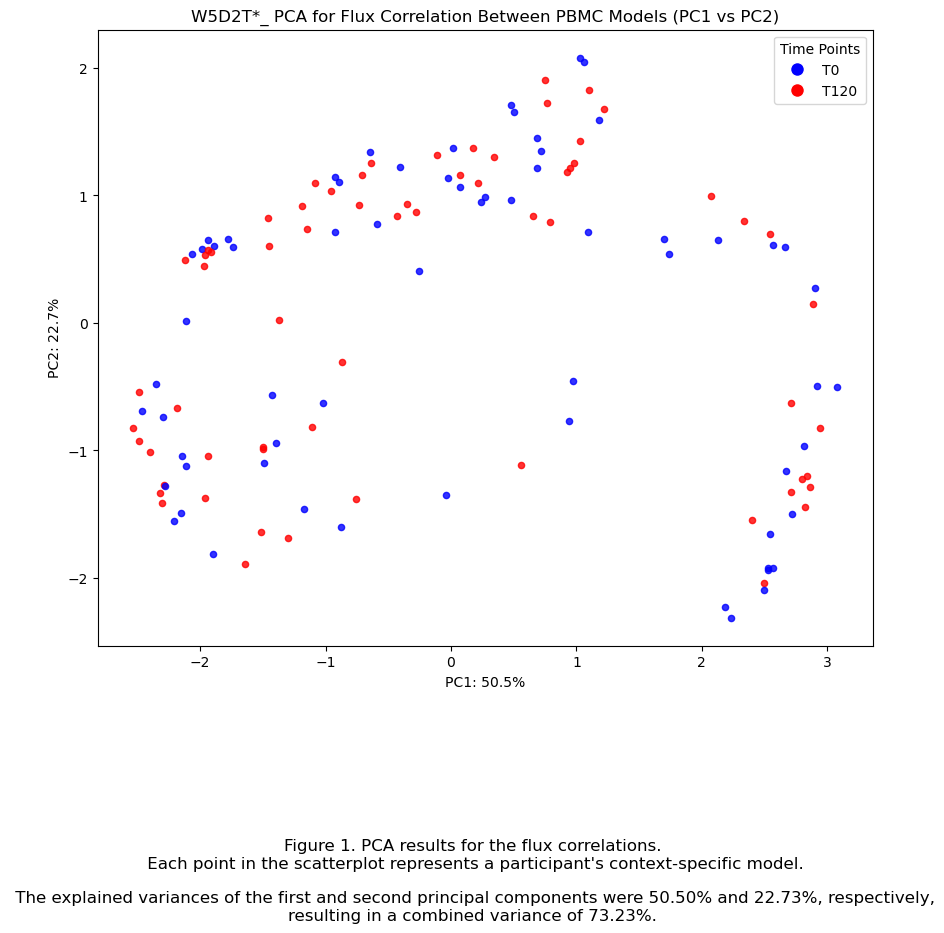

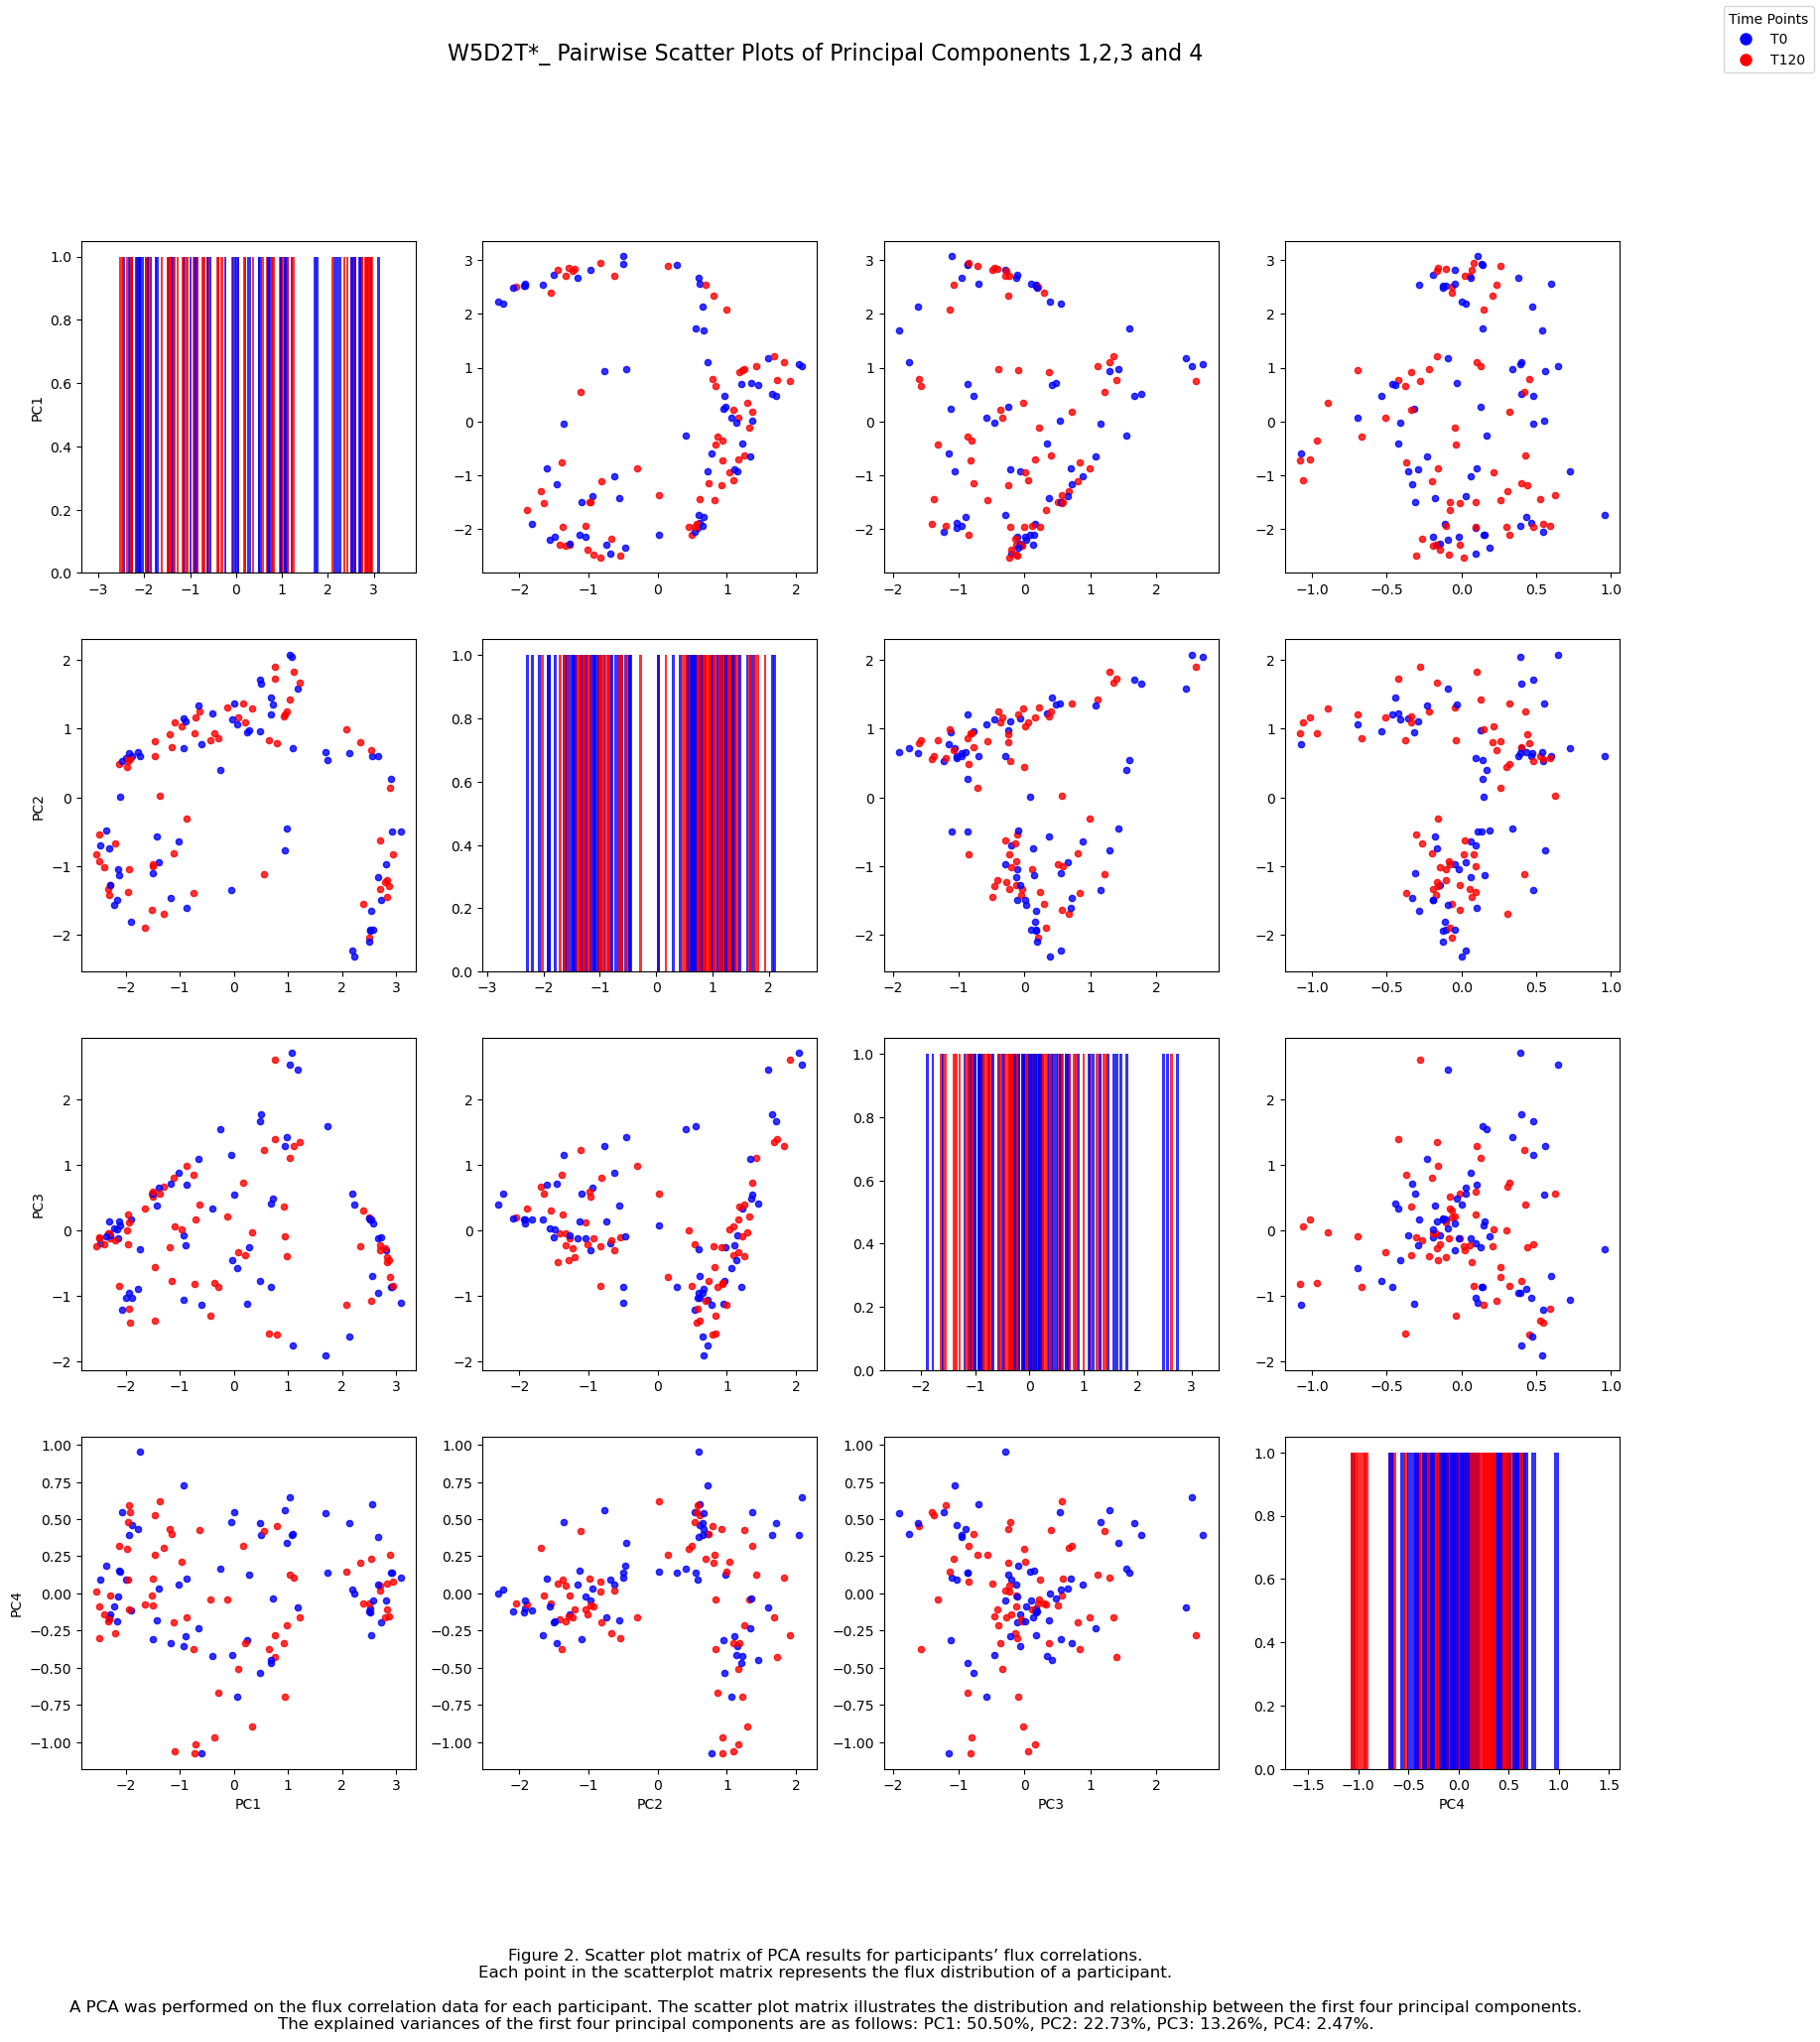

In [5]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your pw_flx3 data from the CSV file
pw_flxload = pd.read_csv('pw_flx3.csv')

# Extract sample labels (T0 or T120) from the column names
labels = [col.split('T')[-1] for col in pw_flxload.columns]

# Set the file_ID for naming plots and saved figures
file_ID = 'W5D2T*_'

# Perform PCA
pca = PCA(n_components=3)
pcaData = pca.fit_transform(pw_flxload.T)  # Transpose to make samples as rows
print(pca.explained_variance_ratio_)

title_font = {
    'weight': 'medium',
    'size': 12,
}
axis_font = {
    'weight': 'normal',
    'size': 10,
}

# Color coding based on time points
colors = ['blue' if label == '0' else 'red' for label in labels]

# Plot PCA scatter plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
for i in range(len(labels)):
    xs = pcaData[i, 0]
    ys = pcaData[i, 1]
    plt.scatter(xs, ys, s=20, marker='o', color=colors[i], alpha=0.8)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120')]
plt.legend(handles=handles, title="Time Points")

plt.title(f'{file_ID} PCA for Flux Correlation Between PBMC Models (PC1 vs PC2)', title_font)
plt.xlabel('PC1: {:.1%}'.format(pca.explained_variance_ratio_[0]), axis_font)
plt.ylabel('PC2: {:.1%}'.format(pca.explained_variance_ratio_[1]), axis_font)
plt.figtext(0.5, -0.23, (f'Figure 1. PCA results for the flux correlations.\n Each point in the scatterplot represents a participant\'s context-specific model.\n\n The explained variances of the first and second principal components were {pca.explained_variance_ratio_[0]*100:.2f}% and {pca.explained_variance_ratio_[1]*100:.2f}%, respectively, resulting in a combined variance of {((pca.explained_variance_ratio_[0]*100)+(pca.explained_variance_ratio_[1]*100)):.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'{file_ID}fig.1_PCA_for_Flux_Correlation.png', dpi=1000)

####################### Create a 4x4 plot matrix of PC1, PC2, PC3, and PC4
# Perform PCA
pca = PCA(n_components=4)
pcaData = pca.fit_transform(pw_flxload.T)
explained_variance = pca.explained_variance_ratio_

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

pc_labels = ['PC1', 'PC2', 'PC3', 'PC4']
components = [pcaData[:, 0], pcaData[:, 1], pcaData[:, 2], pcaData[:, 3]]

for i in range(4):
    for j in range(4):
        if i == j:
            for k, c in zip(components[i], colors):
                axs[i, j].hist(k, bins=20, color=c, alpha=0.8)
        else:
            for x, y, c in zip(components[j], components[i], colors):
                axs[i, j].scatter(x, y, color=c, s=20, alpha=0.8)
        if i == 3:
            axs[i, j].set_xlabel(pc_labels[j])
        if j == 0:
            axs[i, j].set_ylabel(pc_labels[i])

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120')]
fig.legend(handles=handles, title="Time Points", loc='upper right')

plt.suptitle(f'{file_ID} Pairwise Scatter Plots of Principal Components 1,2,3 and 4', fontsize=16, weight='medium')
plt.figtext(0.5, -0.02, (f'Figure 2. Scatter plot matrix of PCA results for participants’ flux correlations.\n'
                         f'Each point in the scatterplot matrix represents the flux distribution of a participant.\n\n'
                         f'A PCA was performed on the flux correlation data for each participant. The scatter plot matrix illustrates the distribution and relationship between the first four principal components.\n'
                         f'The explained variances of the first four principal components are as follows: PC1: {explained_variance[0]*100:.2f}%, PC2: {explained_variance[1]*100:.2f}%, PC3: {explained_variance[2]*100:.2f}%, PC4: {explained_variance[3]*100:.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)

plt.savefig(f'{file_ID}fig.2_Pairwise_Scatter_Plots_of_PC1_to_PC4.png', dpi=1000)
plt.show()


# W5D3T0, code from docs, FBA = true

In [37]:
# %% Load the context-specific models
directory_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0'
context_specific_models = []
for filename in os.listdir(directory_path):
    if filename.endswith(".mat"):
        file_path = os.path.join(directory_path, filename)
        model = load_matlab_model(file_path)
        context_specific_models.append(model)

print(f"Loaded {len(context_specific_models)} models.")

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in mod

Loaded 56 models.


from ninas code
```python
ref_model = cobra.io.mat.load_matlab_model(path_ref)
rxn, met, gen, graphlist, flx = load_library(path_lib, ref_model, graph=True, sampling=True, FBA=False)

#%% Perform flux correlation between pairs of models
pw_flx = flux_DM(flx)

pca = PCA(n_components=2)
pcaData = pca.fit_transform(pw_flx)
print(pca.explained_variance_ratio_)
```

In [38]:
path_ref = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/Recon3D.mat'
ref_model = load_matlab_model(path_ref)

# Convert the list of models to a list of paths
file_paths = [Path(os.path.join(directory_path, f)) for f in os.listdir(directory_path) if f.endswith(".mat")]

# Call the load_library function to get the flux dataframe
reactions_matrix, metabolite_matrix, gene_matrix, flx_df = load_library(file_paths, ref_model, sampling=False, FBA=True)
#rxn, met, gen, graphlist, flx = load_library(file_paths, ref_model, sampling= False, FBA= True)


# Check the flux data frame
print(flx_df.head())



This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model Recon3D. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT001_W5D3T0
FBA...
<Solution 1000.000 at 0x148071710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT140_W5D3T0
FBA...
<Solution 1000.000 at 0x19c543190>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT059_W5D3T0
FBA...
<Solution 1000.000 at 0x159dab450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT118_W5D3T0
FBA...
<Solution 1000.000 at 0x15fdf1f10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT045_W5D3T0
FBA...
<Solution 1000.000 at 0x156673ad0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT133_W5D3T0
FBA...
<Solution 1000.000 at 0x1f79fdc90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT027_W5D3T0
FBA...
<Solution 1000.000 at 0x146c18850>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT010_W5D3T0
FBA...
<Solution 1000.000 at 0x2662efc50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT148_W5D3T0
FBA...
<Solution 944.444 at 0x1f9d34690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT077_W5D3T0
FBA...
<Solution 1000.000 at 0x1702d1ad0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT015_W5D3T0
FBA...
<Solution 1000.000 at 0x146c691d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT022_W5D3T0
FBA...
<Solution 1000.000 at 0x26c1c6fd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT033_W5D3T0
FBA...
<Solution 1000.000 at 0x1778d4350>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT145_W5D3T0
FBA...
<Solution 1000.000 at 0x2663cfa90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT051_W5D3T0
FBA...
<Solution 1000.000 at 0x270b2da90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT066_W5D3T0
FBA...
<Solution 1000.000 at 0x26eaf7610>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT018_W5D3T0
FBA...
<Solution 1000.000 at 0x19f143a10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT082_W5D3T0
FBA...
<Solution 1000.000 at 0x26d8bdc50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT034_W5D3T0
FBA...
<Solution 1000.000 at 0x25255c2d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT120_W5D3T0
FBA...
<Solution 1000.000 at 0x147b0a450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT056_W5D3T0
FBA...
<Solution 1000.000 at 0x149dd81d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT070_W5D3T0
FBA...
<Solution 1000.000 at 0x14d0f3350>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT106_W5D3T0
FBA...
<Solution 1000.000 at 0x148aeadd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT131_W5D3T0
FBA...
<Solution 1000.000 at 0x151b87490>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT025_W5D3T0
FBA...
<Solution 1000.000 at 0x153cb8750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT020_W5D3T0
FBA...
<Solution 1000.000 at 0x23d622890>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT017_W5D3T0
FBA...
<Solution 1000.000 at 0x26dc34750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT103_W5D3T0
FBA...
<Solution 1000.000 at 0x15fe6aa10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT006_W5D3T0
FBA...
<Solution 1000.000 at 0x181767f10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT031_W5D3T0
FBA...
<Solution 1000.000 at 0x26d9816d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT064_W5D3T0
FBA...
<Solution 1000.000 at 0x19c534c10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT053_W5D3T0
FBA...
<Solution 1000.000 at 0x148991a90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT008_W5D3T0
FBA...
<Solution 1000.000 at 0x26f3f5890>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT076_W5D3T0
FBA...
<Solution 1000.000 at 0x270f80b90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT023_W5D3T0
FBA...
<Solution 1000.000 at 0x14dc55e10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT137_W5D3T0
FBA...
<Solution 1000.000 at 0x155daf5d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT067_W5D3T0
FBA...
<Solution 1000.000 at 0x15856f710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT084_W5D3T0
FBA...
<Solution 1000.000 at 0x15b051c50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT114_W5D3T0
FBA...
<Solution 1000.000 at 0x15cdf6250>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT123_W5D3T0
FBA...
<Solution 1000.000 at 0x15f0f12d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT090_W5D3T0
FBA...
<Solution 1000.000 at 0x160ed2410>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT150_W5D3T0
FBA...
<Solution 1000.000 at 0x2477bac90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT044_W5D3T0
FBA...
<Solution 1000.000 at 0x16f118050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT132_W5D3T0
FBA...
<Solution 1000.000 at 0x26efd7cd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT043_W5D3T0
FBA...
<Solution 1000.000 at 0x14dfe7c50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT021_W5D3T0
FBA...
<Solution 1000.000 at 0x160273250>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT129_W5D3T0
FBA...
<Solution 1000.000 at 0x17dd3a590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT146_W5D3T0
FBA...
<Solution 1000.000 at 0x1618db850>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT035_W5D3T0
FBA...
<Solution 1000.000 at 0x15afce650>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT002_W5D3T0
FBA...
<Solution 1000.000 at 0x157956b50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT057_W5D3T0
FBA...
<Solution 1000.000 at 0x15dbc2ed0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT060_W5D3T0
FBA...
<Solution 1000.000 at 0x1621ff1d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT143_W5D3T0
FBA...
<Solution 1000.000 at 0x16448f4d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT152_W5D3T0
FBA...
<Solution 1000.000 at 0x166975550>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT046_W5D3T0
FBA...
<Solution 1000.000 at 0x1692821d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT013_W5D3T0
FBA...
<Solution 1000.000 at 0x16b24c0d0>
                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT001_W5D3T0  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                              
25HVITD3t                                                          NaN                                                                    

In [39]:
reactions_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT001_W5D3T0  \
24_25DHVITD3tm                                                       0                                                                                                                                                                                                              
25HVITD3t                                                            0                                                                                                                                                                                                              
COAtl                                                                0                                                                                                                                                                                                              
EX_5adtststerone_e                                                   0                                                                                                                                                                                                              
EX_5adtststerones_e                                                  0                                                                                                                                                                                                              
...                                                                ...                                                                                                                                                                                                              
ACMPGLUTTRsc                                                         0                                                                                                                                                                                                              
FVSCOAhc                                                             0                                                                                                                                                                                                              
MDZGLChr                                                             0                                                                                                                                                                                                              
TMACMPhr                                                             0                                                                                                                                                                                                              
CYSACMPitr                                                           0                                                                                                                                                                                                              

                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT140_W5D3T0  \
24_25DHVITD3tm                                                       0                                                                                                                                                                                                              
25HVITD3t                                                            0                                                                        

In [40]:
metabolite_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT001_W5D3T0  \
10fthf_c                                                       0                                                                                                                                                                                                              
10fthf_l                                                       0                                                                                                                                                                                                              
10fthf_m                                                       0                                                                                                                                                                                                              
11docrtsl_c                                                    0                                                                                                                                                                                                              
11docrtsl_m                                                    0                                                                                                                                                                                                              
...                                                          ...                                                                                                                                                                                                              
caproic_e                                                      0                                                                                                                                                                                                              
1a25dhvitd2_c                                                  0                                                                                                                                                                                                              
1a25dhvitd2_e                                                  0                                                                                                                                                                                                              
protein_c                                                      0                                                                                                                                                                                                              
h_i                                                            0                                                                                                                                                                                                              

               /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT140_W5D3T0  \
10fthf_c                                                       0                                                                                                                                                                                                              
10fthf_l                                                       0                                                                                                                                                            

In [41]:
gene_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT001_W5D3T0  \
0                                                          1                                                                                                                                                                                                              
26_AT1                                                     0                                                                                                                                                                                                              
314_AT1                                                    0                                                                                                                                                                                                              
8639_AT1                                                   0                                                                                                                                                                                                              
314_AT2                                                    0                                                                                                                                                                                                              
...                                                      ...                                                                                                                                                                                                              
27089_AT1                                                  0                                                                                                                                                                                                              
10975_AT1                                                  0                                                                                                                                                                                                              
7381_AT1                                                   0                                                                                                                                                                                                              
29796_AT1                                                  0                                                                                                                                                                                                              
4519_AT1                                                   0                                                                                                                                                                                                              

           /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT140_W5D3T0  \
0                                                          1                                                                                                                                                                                                              
26_AT1                                                     0                                                                                                                                                                                                              
314_A

In [42]:
flx_df

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT001_W5D3T0  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                              
25HVITD3t                                                          NaN                                                                                                                                                                                                              
COAtl                                                              NaN                                                                                                                                                                                                              
EX_5adtststerone_e                                                 NaN                                                                                                                                                                                                              
EX_5adtststerones_e                                                NaN                                                                                                                                                                                                              
...                                                                ...                                                                                                                                                                                                              
ACMPGLUTTRsc                                                       NaN                                                                                                                                                                                                              
FVSCOAhc                                                           NaN                                                                                                                                                                                                              
MDZGLChr                                                           NaN                                                                                                                                                                                                              
TMACMPhr                                                           NaN                                                                                                                                                                                                              
CYSACMPitr                                                         NaN                                                                                                                                                                                                              

                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0/NT140_W5D3T0  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                              
25HVITD3t                                                          NaN                                                                        

In [43]:
#%% Perform flux correlation between pairs of models
pw_flx2_1 = flux_DM(flx_df)
pw_flx2_1
# Save pw_flx1 as a CSV file
pw_flx2_1.to_csv('pw_flx2_1.csv', index=False)

figure out what idx.drop is doing and if flx_df is compatible , why or why not?

[0.36762544 0.25403733 0.08680735]


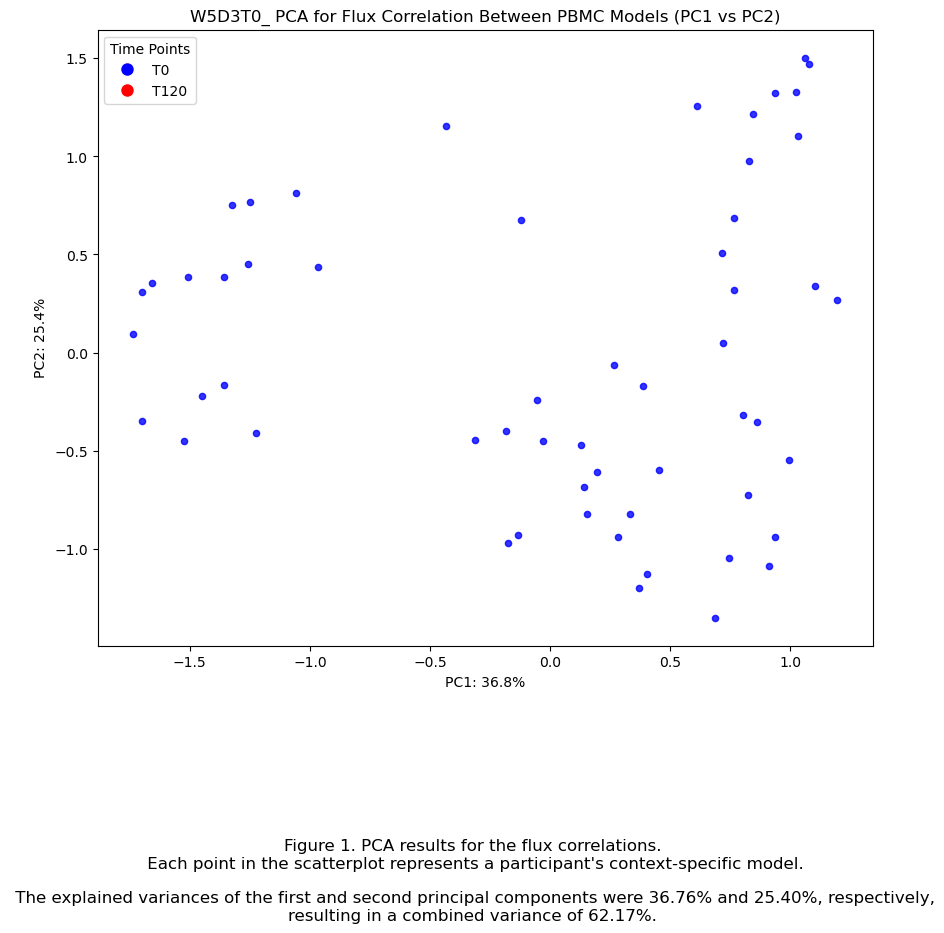

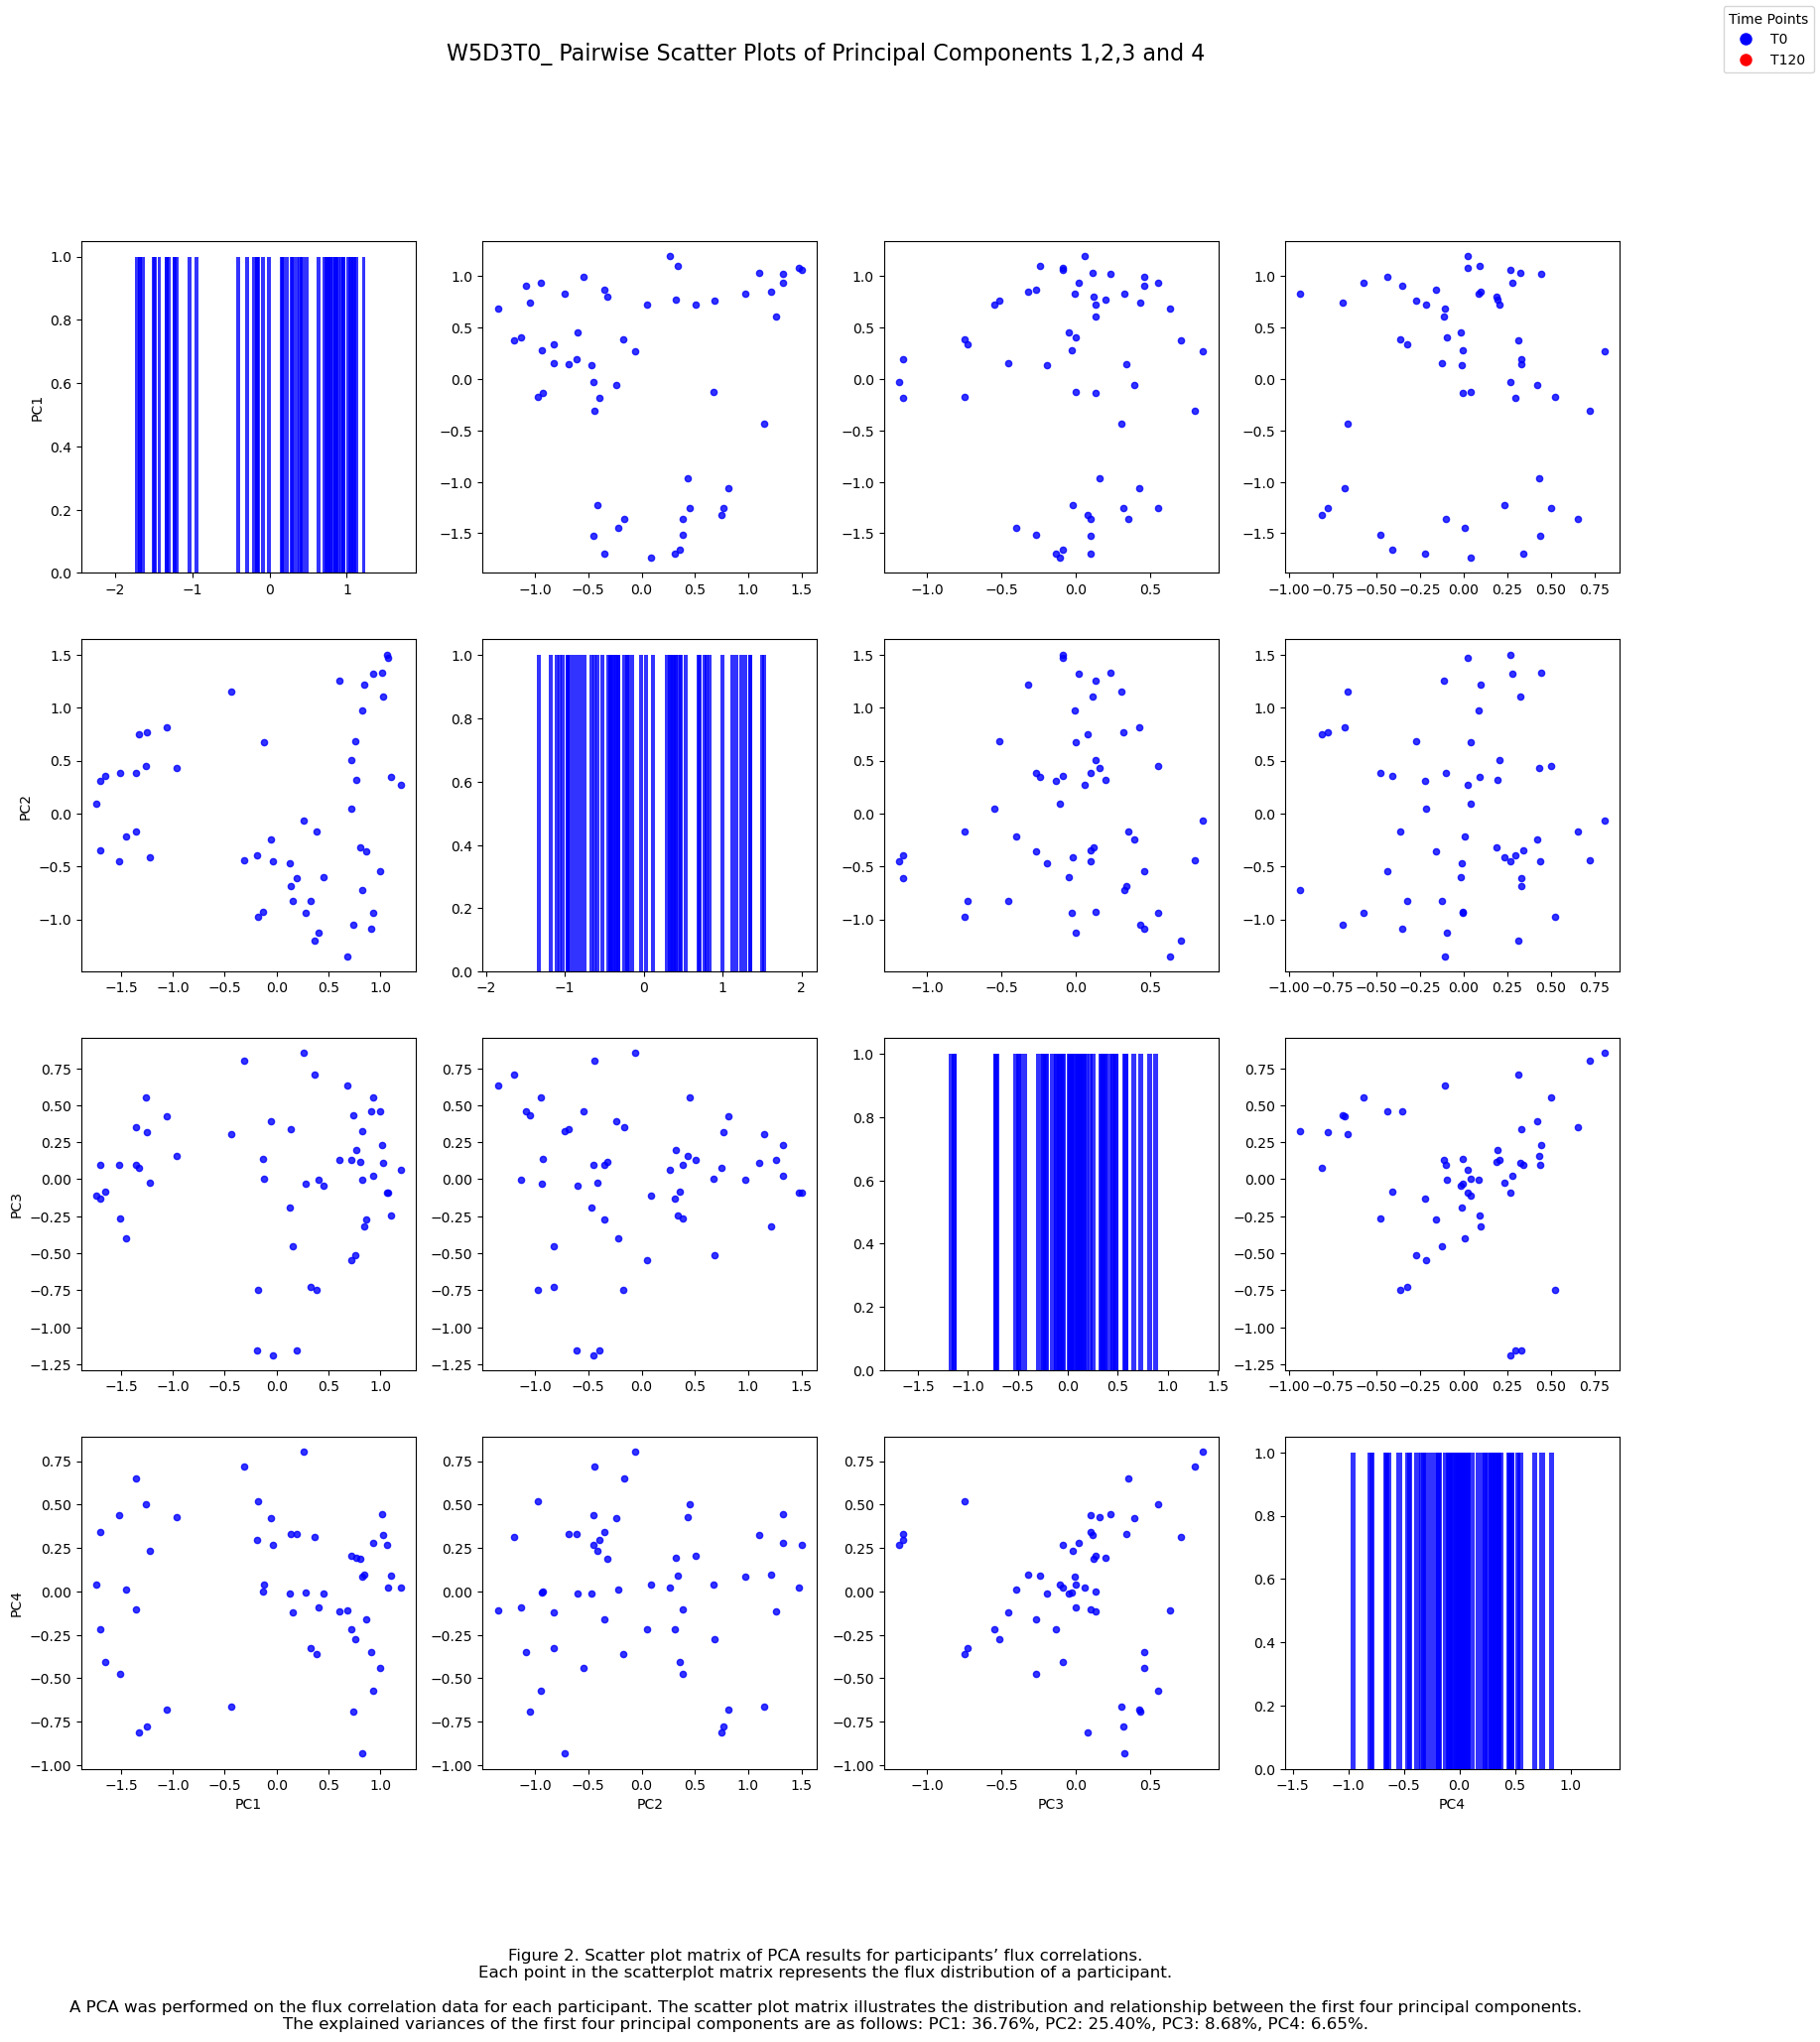

In [8]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your pw_flx3 data from the CSV file
pw_flxload = pd.read_csv('pw_flx2_1.csv')

# Extract sample labels (T0 or T120) from the column names
labels = [col.split('T')[-1] for col in pw_flxload.columns]

# Set the file_ID for naming plots and saved figures
file_ID = 'W5D3T0_'

# Perform PCA
pca = PCA(n_components=3)
pcaData = pca.fit_transform(pw_flxload.T)  # Transpose to make samples as rows
print(pca.explained_variance_ratio_)

title_font = {
    'weight': 'medium',
    'size': 12,
}
axis_font = {
    'weight': 'normal',
    'size': 10,
}

# Color coding based on time points
colors = ['blue' if label == '0' else 'red' for label in labels]

# Plot PCA scatter plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
for i in range(len(labels)):
    xs = pcaData[i, 0]
    ys = pcaData[i, 1]
    plt.scatter(xs, ys, s=20, marker='o', color=colors[i], alpha=0.8)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120')]
plt.legend(handles=handles, title="Time Points")

plt.title(f'{file_ID} PCA for Flux Correlation Between PBMC Models (PC1 vs PC2)', title_font)
plt.xlabel('PC1: {:.1%}'.format(pca.explained_variance_ratio_[0]), axis_font)
plt.ylabel('PC2: {:.1%}'.format(pca.explained_variance_ratio_[1]), axis_font)
plt.figtext(0.5, -0.23, (f'Figure 1. PCA results for the flux correlations.\n Each point in the scatterplot represents a participant\'s context-specific model.\n\n The explained variances of the first and second principal components were {pca.explained_variance_ratio_[0]*100:.2f}% and {pca.explained_variance_ratio_[1]*100:.2f}%, respectively, resulting in a combined variance of {((pca.explained_variance_ratio_[0]*100)+(pca.explained_variance_ratio_[1]*100)):.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'{file_ID}fig.1_PCA_for_Flux_Correlation.png', dpi=1000)

####################### Create a 4x4 plot matrix of PC1, PC2, PC3, and PC4
# Perform PCA
pca = PCA(n_components=4)
pcaData = pca.fit_transform(pw_flxload.T)
explained_variance = pca.explained_variance_ratio_

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

pc_labels = ['PC1', 'PC2', 'PC3', 'PC4']
components = [pcaData[:, 0], pcaData[:, 1], pcaData[:, 2], pcaData[:, 3]]

for i in range(4):
    for j in range(4):
        if i == j:
            for k, c in zip(components[i], colors):
                axs[i, j].hist(k, bins=20, color=c, alpha=0.8)
        else:
            for x, y, c in zip(components[j], components[i], colors):
                axs[i, j].scatter(x, y, color=c, s=20, alpha=0.8)
        if i == 3:
            axs[i, j].set_xlabel(pc_labels[j])
        if j == 0:
            axs[i, j].set_ylabel(pc_labels[i])

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120')]
fig.legend(handles=handles, title="Time Points", loc='upper right')

plt.suptitle(f'{file_ID} Pairwise Scatter Plots of Principal Components 1,2,3 and 4', fontsize=16, weight='medium')
plt.figtext(0.5, -0.02, (f'Figure 2. Scatter plot matrix of PCA results for participants’ flux correlations.\n'
                         f'Each point in the scatterplot matrix represents the flux distribution of a participant.\n\n'
                         f'A PCA was performed on the flux correlation data for each participant. The scatter plot matrix illustrates the distribution and relationship between the first four principal components.\n'
                         f'The explained variances of the first four principal components are as follows: PC1: {explained_variance[0]*100:.2f}%, PC2: {explained_variance[1]*100:.2f}%, PC3: {explained_variance[2]*100:.2f}%, PC4: {explained_variance[3]*100:.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)

plt.savefig(f'{file_ID}fig.2_Pairwise_Scatter_Plots_of_PC1_to_PC4.png', dpi=1000)
plt.show()


# W5D3T120, code from docs, FBA = true

In [45]:
# %% Load the context-specific models
directory_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120'
context_specific_models = []
for filename in os.listdir(directory_path):
    if filename.endswith(".mat"):
        file_path = os.path.join(directory_path, filename)
        model = load_matlab_model(file_path)
        context_specific_models.append(model)

print(f"Loaded {len(context_specific_models)} models.")

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in mod

Loaded 56 models.


from ninas code
```python
ref_model = cobra.io.mat.load_matlab_model(path_ref)
rxn, met, gen, graphlist, flx = load_library(path_lib, ref_model, graph=True, sampling=True, FBA=False)

#%% Perform flux correlation between pairs of models
pw_flx = flux_DM(flx)

pca = PCA(n_components=2)
pcaData = pca.fit_transform(pw_flx)
print(pca.explained_variance_ratio_)
```

In [46]:
path_ref = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/Recon3D.mat'
ref_model = load_matlab_model(path_ref)

# Convert the list of models to a list of paths
file_paths = [Path(os.path.join(directory_path, f)) for f in os.listdir(directory_path) if f.endswith(".mat")]

# Call the load_library function to get the flux dataframe
reactions_matrix, metabolite_matrix, gene_matrix, flx_df = load_library(file_paths, ref_model, sampling=False, FBA=True)
#rxn, met, gen, graphlist, flx = load_library(file_paths, ref_model, sampling= False, FBA= True)


# Check the flux data frame
print(flx_df.head())



This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model Recon3D. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT008_W5D3T120
FBA...
<Solution 1000.000 at 0x2c824e590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT148_W5D3T120
FBA...
<Solution 1000.000 at 0x17101f7d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT020_W5D3T120
FBA...
<Solution 1000.000 at 0x172943ed0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT150_W5D3T120
FBA...
<Solution 1000.000 at 0x175f39d90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT027_W5D3T120
FBA...
<Solution 1000.000 at 0x1780c2290>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT067_W5D3T120
FBA...
<Solution 1000.000 at 0x17a788b50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT145_W5D3T120
FBA...
<Solution 1000.000 at 0x17c638050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT060_W5D3T120
FBA...
<Solution 1000.000 at 0x17e1dfb10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT035_W5D3T120
FBA...
<Solution 966.667 at 0x17fde1d50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT056_W5D3T120
FBA...
<Solution 1000.000 at 0x182d14e10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT051_W5D3T120
FBA...
<Solution 1000.000 at 0x187923ad0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT133_W5D3T120
FBA...
<Solution 1000.000 at 0x1f7573a10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT044_W5D3T120
FBA...
<Solution 1000.000 at 0x17f33f8d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT043_W5D3T120
FBA...
<Solution 1000.000 at 0x1901e61d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT143_W5D3T120
FBA...
<Solution 1000.000 at 0x17f95da50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT034_W5D3T120
FBA...
<Solution 1000.000 at 0x17762a710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT033_W5D3T120
FBA...
<Solution 1000.000 at 0x170ae2810>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT066_W5D3T120
FBA...
<Solution 1000.000 at 0x17bf53750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT021_W5D3T120
FBA...
<Solution 1000.000 at 0x14829fcd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT103_W5D3T120
FBA...
<Solution 1000.000 at 0x15d515fd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT017_W5D3T120
FBA...
<Solution 1000.000 at 0x176b3aa90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT010_W5D3T120
FBA...
<Solution 1000.000 at 0x1f83094d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT045_W5D3T120
FBA...
<Solution 1000.000 at 0x1f99137d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT132_W5D3T120
FBA...
<Solution 1000.000 at 0x1fb109e10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT120_W5D3T120
FBA...
<Solution 1000.000 at 0x21b659f10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT002_W5D3T120
FBA...
<Solution 1000.000 at 0x21cd9c9d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT057_W5D3T120
FBA...
<Solution 1000.000 at 0x21e392150>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT064_W5D3T120
FBA...
<Solution 1000.000 at 0x21fac2e50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT031_W5D3T120
FBA...
<Solution 1000.000 at 0x221289290>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT146_W5D3T120
FBA...
<Solution 1000.000 at 0x1fab36590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT114_W5D3T120
FBA...
<Solution 1000.000 at 0x14c95ded0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT076_W5D3T120
FBA...
<Solution 1000.000 at 0x164775690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT023_W5D3T120
FBA...
<Solution 1000.000 at 0x17d8a9350>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT106_W5D3T120
FBA...
<Solution 1000.000 at 0x1d0186b90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT137_W5D3T120
FBA...
<Solution 1000.000 at 0x17593b410>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT015_W5D3T120
FBA...
<Solution 1000.000 at 0x1f6ad52d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT025_W5D3T120
FBA...
<Solution 1000.000 at 0x2cf150f10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT070_W5D3T120
FBA...
<Solution 1000.000 at 0x175c75190>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT152_W5D3T120
FBA...
<Solution 1000.000 at 0x1f7232350>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT022_W5D3T120
FBA...
<Solution 1000.000 at 0x163833990>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT077_W5D3T120
FBA...
<Solution 1000.000 at 0x221cb2d10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT140_W5D3T120
FBA...
<Solution 1000.000 at 0x223487750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT006_W5D3T120
FBA...
<Solution 1000.000 at 0x224c7b0d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT053_W5D3T120
FBA...
<Solution 1000.000 at 0x2263248d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT123_W5D3T120
FBA...
<Solution 1000.000 at 0x227a87590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT001_W5D3T120
FBA...
<Solution 1000.000 at 0x22923c490>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT013_W5D3T120
FBA...
<Solution 1000.000 at 0x22a994bd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT046_W5D3T120
FBA...
<Solution 1000.000 at 0x1f6c283d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT131_W5D3T120
FBA...
<Solution 1000.000 at 0x181116890>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT129_W5D3T120
FBA...
<Solution 1000.000 at 0x17c3dda90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT059_W5D3T120
FBA...
<Solution 1000.000 at 0x1fbd01a90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT090_W5D3T120
FBA...
<Solution 1000.000 at 0x21f56f390>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT118_W5D3T120
FBA...
<Solution 1000.000 at 0x21f232910>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT082_W5D3T120
FBA...
<Solution 1000.000 at 0x177ecdf50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT018_W5D3T120
FBA...
<Solution 1000.000 at 0x163866510>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT084_W5D3T120
FBA...
<Solution 1000.000 at 0x1faa8d950>
                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT008_W5D3T120  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                                  
25HVITD3t                                                          NaN                                                        

In [47]:
reactions_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT008_W5D3T120  \
24_25DHVITD3tm                                                       0                                                                                                                                                                                                                  
25HVITD3t                                                            0                                                                                                                                                                                                                  
COAtl                                                                0                                                                                                                                                                                                                  
EX_5adtststerone_e                                                   0                                                                                                                                                                                                                  
EX_5adtststerones_e                                                  0                                                                                                                                                                                                                  
...                                                                ...                                                                                                                                                                                                                  
ACMPGLUTTRsc                                                         0                                                                                                                                                                                                                  
FVSCOAhc                                                             0                                                                                                                                                                                                                  
MDZGLChr                                                             0                                                                                                                                                                                                                  
TMACMPhr                                                             0                                                                                                                                                                                                                  
CYSACMPitr                                                           0                                                                                                                                                                                                                  

                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT148_W5D3T120  \
24_25DHVITD3tm                                                       0                                                                                                                                                                                                                  
25HVITD3t                                                            0                

In [48]:
metabolite_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT008_W5D3T120  \
10fthf_c                                                       0                                                                                                                                                                                                                  
10fthf_l                                                       0                                                                                                                                                                                                                  
10fthf_m                                                       0                                                                                                                                                                                                                  
11docrtsl_c                                                    0                                                                                                                                                                                                                  
11docrtsl_m                                                    0                                                                                                                                                                                                                  
...                                                          ...                                                                                                                                                                                                                  
caproic_e                                                      0                                                                                                                                                                                                                  
1a25dhvitd2_c                                                  0                                                                                                                                                                                                                  
1a25dhvitd2_e                                                  0                                                                                                                                                                                                                  
protein_c                                                      0                                                                                                                                                                                                                  
h_i                                                            0                                                                                                                                                                                                                  

               /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT148_W5D3T120  \
10fthf_c                                                       0                                                                                                                                                                                                                  
10fthf_l                                                       0                                                                                                    

In [49]:
gene_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT008_W5D3T120  \
0                                                          1                                                                                                                                                                                                                  
26_AT1                                                     0                                                                                                                                                                                                                  
314_AT1                                                    0                                                                                                                                                                                                                  
8639_AT1                                                   0                                                                                                                                                                                                                  
314_AT2                                                    0                                                                                                                                                                                                                  
...                                                      ...                                                                                                                                                                                                                  
27089_AT1                                                  0                                                                                                                                                                                                                  
10975_AT1                                                  0                                                                                                                                                                                                                  
7381_AT1                                                   0                                                                                                                                                                                                                  
29796_AT1                                                  0                                                                                                                                                                                                                  
4519_AT1                                                   0                                                                                                                                                                                                                  

           /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT148_W5D3T120  \
0                                                          1                                                                                                                                                                                                                  
26_AT1                                                     0                                                                                                                                                            

In [50]:
flx_df

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT008_W5D3T120  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                                  
25HVITD3t                                                          NaN                                                                                                                                                                                                                  
COAtl                                                              NaN                                                                                                                                                                                                                  
EX_5adtststerone_e                                                 NaN                                                                                                                                                                                                                  
EX_5adtststerones_e                                                NaN                                                                                                                                                                                                                  
...                                                                ...                                                                                                                                                                                                                  
ACMPGLUTTRsc                                                       NaN                                                                                                                                                                                                                  
FVSCOAhc                                                           NaN                                                                                                                                                                                                                  
MDZGLChr                                                           NaN                                                                                                                                                                                                                  
TMACMPhr                                                           NaN                                                                                                                                                                                                                  
CYSACMPitr                                                         NaN                                                                                                                                                                                                                  

                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120/NT148_W5D3T120  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                                  
25HVITD3t                                                          NaN                

In [51]:
#%% Perform flux correlation between pairs of models
pw_flx2_2 = flux_DM(flx_df)
pw_flx2_2
# Save pw_flx1 as a CSV file
pw_flx2_2.to_csv('pw_flx2_2.csv', index=False)

figure out what idx.drop is doing and if flx_df is compatible , why or why not?

[0.378123   0.19748016]


Text(0, 0.5, 'PC2: 9%')

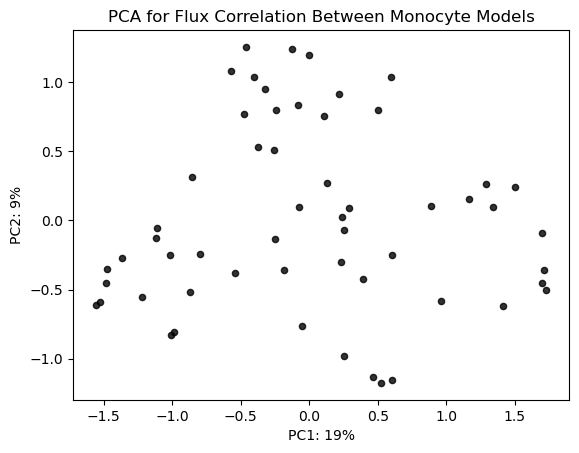

In [52]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

# Load pw_flx1 from the CSV file
#pw_flx2_2 = pd.read_csv('pw_flx2_2.csv')

pca = PCA(n_components=2)
pcaData = pca.fit_transform(pw_flx2_2)
print(pca.explained_variance_ratio_)

title_font = {
'weight' : 'medium',
'size'   : 12,
}

axis_font = {
'weight' : 'normal',
'size'   : 10,
}

fig, axes = plt.subplots(nrows=1, ncols=1)
for i in range(56):
    xs = pcaData[i,0]
    ys = pcaData[i,1]
    clu = plt.scatter(xs, ys, s=20, marker='o', color='black', alpha=0.8)
    #plt.text(str(i + 1))
plt.title('PCA for Flux Correlation Between Monocyte Models', title_font)
plt.xlabel('PC1: 19%', axis_font)
plt.ylabel('PC2: 9%', axis_font)


[0.378123   0.19748016 0.09114667]


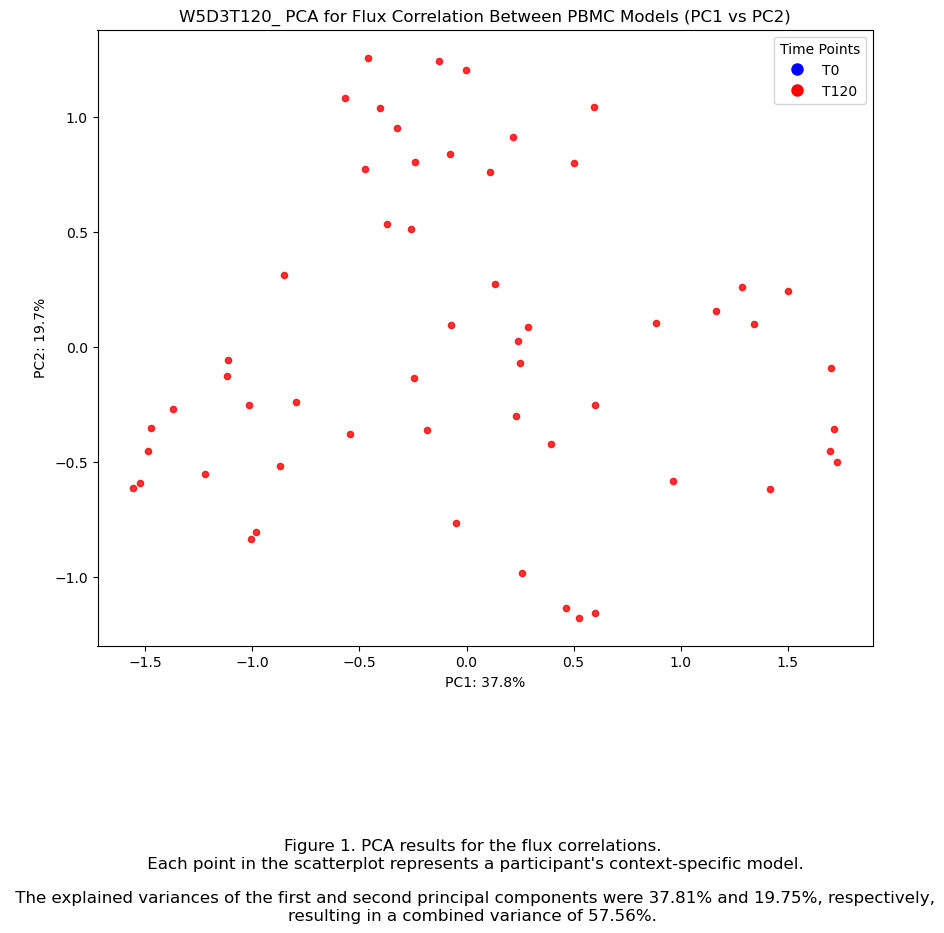

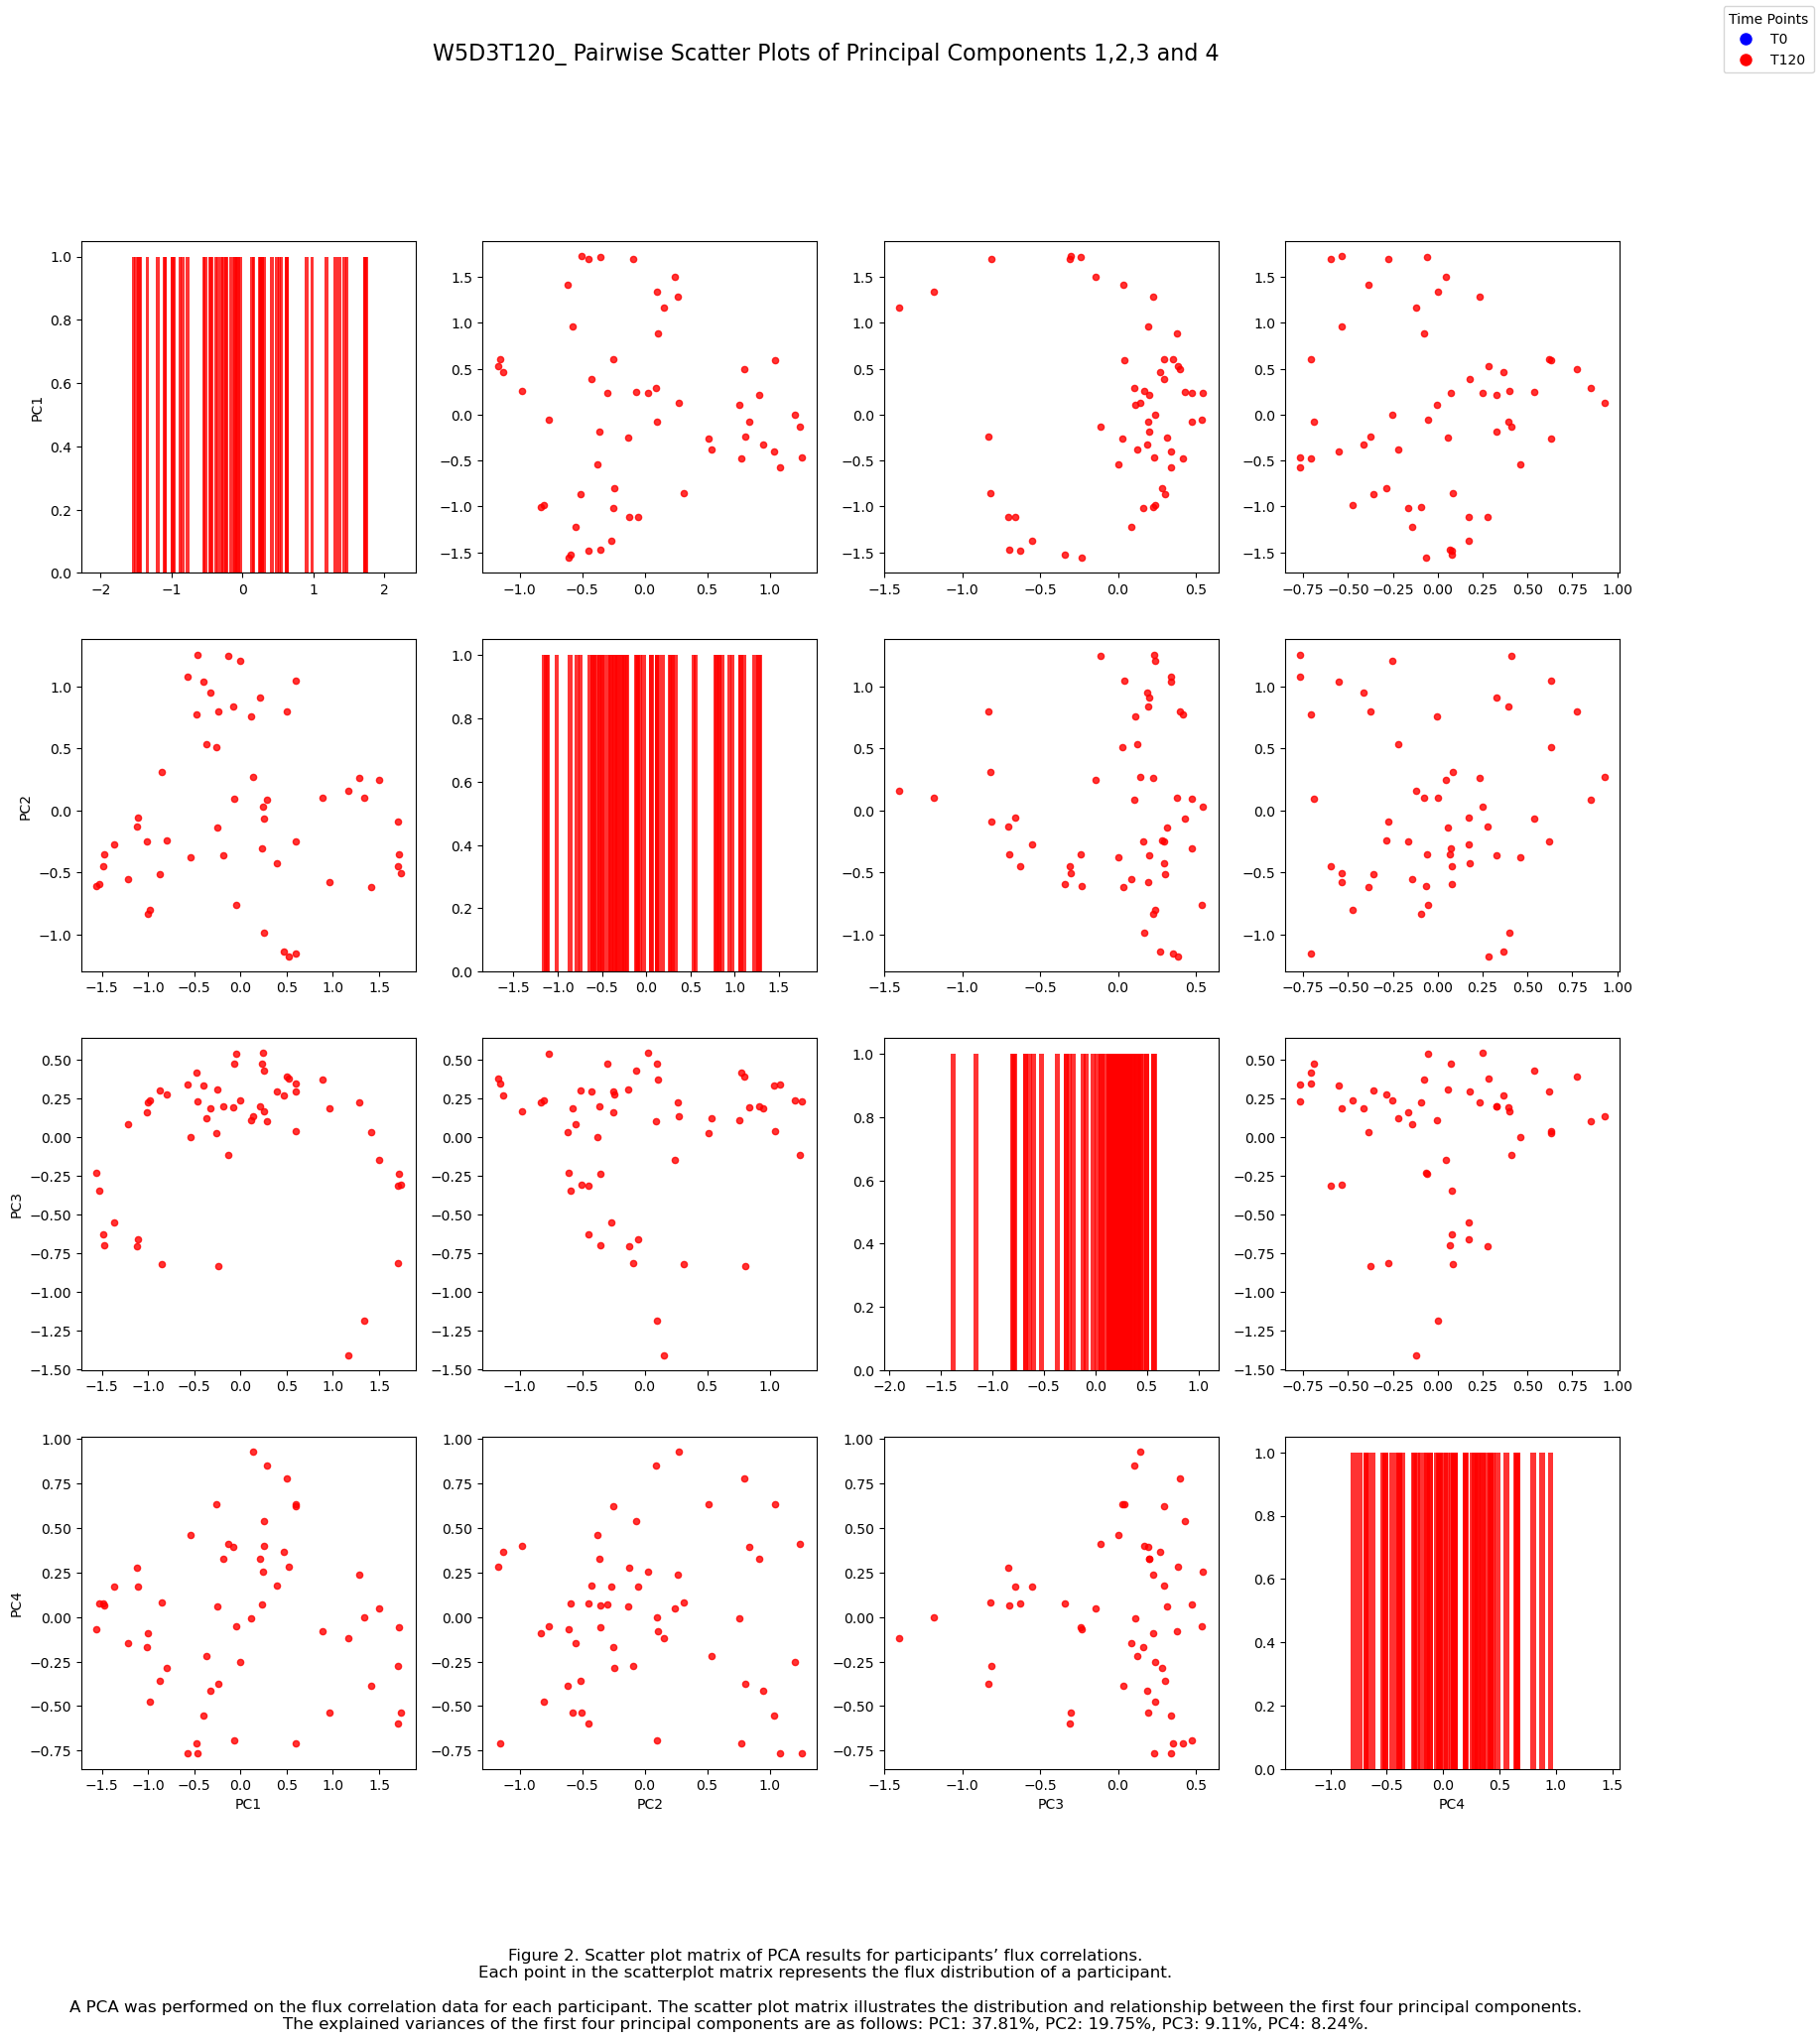

In [9]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your pw_flx3 data from the CSV file
pw_flxload = pd.read_csv('pw_flx2_2.csv')

# Extract sample labels (T0 or T120) from the column names
labels = [col.split('T')[-1] for col in pw_flxload.columns]

# Set the file_ID for naming plots and saved figures
file_ID = 'W5D3T120_'

# Perform PCA
pca = PCA(n_components=3)
pcaData = pca.fit_transform(pw_flxload.T)  # Transpose to make samples as rows
print(pca.explained_variance_ratio_)

title_font = {
    'weight': 'medium',
    'size': 12,
}
axis_font = {
    'weight': 'normal',
    'size': 10,
}

# Color coding based on time points
colors = ['blue' if label == '0' else 'red' for label in labels]

# Plot PCA scatter plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
for i in range(len(labels)):
    xs = pcaData[i, 0]
    ys = pcaData[i, 1]
    plt.scatter(xs, ys, s=20, marker='o', color=colors[i], alpha=0.8)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120')]
plt.legend(handles=handles, title="Time Points")

plt.title(f'{file_ID} PCA for Flux Correlation Between PBMC Models (PC1 vs PC2)', title_font)
plt.xlabel('PC1: {:.1%}'.format(pca.explained_variance_ratio_[0]), axis_font)
plt.ylabel('PC2: {:.1%}'.format(pca.explained_variance_ratio_[1]), axis_font)
plt.figtext(0.5, -0.23, (f'Figure 1. PCA results for the flux correlations.\n Each point in the scatterplot represents a participant\'s context-specific model.\n\n The explained variances of the first and second principal components were {pca.explained_variance_ratio_[0]*100:.2f}% and {pca.explained_variance_ratio_[1]*100:.2f}%, respectively, resulting in a combined variance of {((pca.explained_variance_ratio_[0]*100)+(pca.explained_variance_ratio_[1]*100)):.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'{file_ID}fig.1_PCA_for_Flux_Correlation.png', dpi=1000)

####################### Create a 4x4 plot matrix of PC1, PC2, PC3, and PC4
# Perform PCA
pca = PCA(n_components=4)
pcaData = pca.fit_transform(pw_flxload.T)
explained_variance = pca.explained_variance_ratio_

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

pc_labels = ['PC1', 'PC2', 'PC3', 'PC4']
components = [pcaData[:, 0], pcaData[:, 1], pcaData[:, 2], pcaData[:, 3]]

for i in range(4):
    for j in range(4):
        if i == j:
            for k, c in zip(components[i], colors):
                axs[i, j].hist(k, bins=20, color=c, alpha=0.8)
        else:
            for x, y, c in zip(components[j], components[i], colors):
                axs[i, j].scatter(x, y, color=c, s=20, alpha=0.8)
        if i == 3:
            axs[i, j].set_xlabel(pc_labels[j])
        if j == 0:
            axs[i, j].set_ylabel(pc_labels[i])

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120')]
fig.legend(handles=handles, title="Time Points", loc='upper right')

plt.suptitle(f'{file_ID} Pairwise Scatter Plots of Principal Components 1,2,3 and 4', fontsize=16, weight='medium')
plt.figtext(0.5, -0.02, (f'Figure 2. Scatter plot matrix of PCA results for participants’ flux correlations.\n'
                         f'Each point in the scatterplot matrix represents the flux distribution of a participant.\n\n'
                         f'A PCA was performed on the flux correlation data for each participant. The scatter plot matrix illustrates the distribution and relationship between the first four principal components.\n'
                         f'The explained variances of the first four principal components are as follows: PC1: {explained_variance[0]*100:.2f}%, PC2: {explained_variance[1]*100:.2f}%, PC3: {explained_variance[2]*100:.2f}%, PC4: {explained_variance[3]*100:.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)

plt.savefig(f'{file_ID}fig.2_Pairwise_Scatter_Plots_of_PC1_to_PC4.png', dpi=1000)
plt.show()


# W5D3T240, code from docs, FBA = true

In [53]:
# %% Load the context-specific models
directory_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240'
context_specific_models = []
for filename in os.listdir(directory_path):
    if filename.endswith(".mat"):
        file_path = os.path.join(directory_path, filename)
        model = load_matlab_model(file_path)
        context_specific_models.append(model)

print(f"Loaded {len(context_specific_models)} models.")

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in mod

Loaded 56 models.


from ninas code
```python
ref_model = cobra.io.mat.load_matlab_model(path_ref)
rxn, met, gen, graphlist, flx = load_library(path_lib, ref_model, graph=True, sampling=True, FBA=False)

#%% Perform flux correlation between pairs of models
pw_flx = flux_DM(flx)

pca = PCA(n_components=2)
pcaData = pca.fit_transform(pw_flx)
print(pca.explained_variance_ratio_)
```

In [54]:
path_ref = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/Recon3D.mat'
ref_model = load_matlab_model(path_ref)

# Convert the list of models to a list of paths
file_paths = [Path(os.path.join(directory_path, f)) for f in os.listdir(directory_path) if f.endswith(".mat")]

# Call the load_library function to get the flux dataframe
reactions_matrix, metabolite_matrix, gene_matrix, flx_df = load_library(file_paths, ref_model, sampling=False, FBA=True)
#rxn, met, gen, graphlist, flx = load_library(file_paths, ref_model, sampling= False, FBA= True)


# Check the flux data frame
print(flx_df.head())



This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model Recon3D. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT008_W5D3T240
FBA...
<Solution 1000.000 at 0x1d0891050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT148_W5D3T240
FBA...
<Solution 1000.000 at 0x21897a250>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT043_W5D3T240
FBA...
<Solution 1000.000 at 0x1879e2b90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT044_W5D3T240
FBA...
<Solution 1000.000 at 0x241499e10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT133_W5D3T240
FBA...
<Solution 1000.000 at 0x1751450d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT051_W5D3T240
FBA...
<Solution 1000.000 at 0x26ac37dd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT056_W5D3T240
FBA...
<Solution 1000.000 at 0x1a324ced0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT035_W5D3T240
FBA...
<Solution 1000.000 at 0x1628c4590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT060_W5D3T240
FBA...
<Solution 1000.000 at 0x167efda50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT145_W5D3T240
FBA...
<Solution 1000.000 at 0x264198850>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT067_W5D3T240
FBA...
<Solution 1000.000 at 0x19a5c16d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT027_W5D3T240
FBA...
<Solution 1000.000 at 0x16c6816d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT150_W5D3T240
FBA...
<Solution 1000.000 at 0x16ec1bd90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT020_W5D3T240
FBA...
<Solution 1000.000 at 0x23669b910>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT057_W5D3T240
FBA...
<Solution 1000.000 at 0x237e2f390>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT002_W5D3T240
FBA...
<Solution 1000.000 at 0x2394eabd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT120_W5D3T240
FBA...
<Solution 1000.000 at 0x2b97f0ed0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT132_W5D3T240
FBA...
<Solution 1000.000 at 0x1a47dd6d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT045_W5D3T240
FBA...
<Solution 1000.000 at 0x1558cb010>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT010_W5D3T240
FBA...
<Solution 1000.000 at 0x183047790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT017_W5D3T240
FBA...
<Solution 1000.000 at 0x2bcbec210>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT103_W5D3T240
FBA...
<Solution 1000.000 at 0x18b4c9b90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT021_W5D3T240
FBA...
<Solution 1000.000 at 0x19cf8a090>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT066_W5D3T240
FBA...
<Solution 1000.000 at 0x1744a1e90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT033_W5D3T240
FBA...
<Solution 1000.000 at 0x198b37790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT034_W5D3T240
FBA...
<Solution 1000.000 at 0x23934cfd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT143_W5D3T240
FBA...
<Solution 1000.000 at 0x14f474150>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT015_W5D3T240
FBA...
<Solution 1000.000 at 0x16d45f910>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT137_W5D3T240
FBA...
<Solution 1000.000 at 0x23ab9e490>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT106_W5D3T240
FBA...
<Solution 1000.000 at 0x23c200d10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT023_W5D3T240
FBA...
<Solution 1000.000 at 0x23c9feed0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT076_W5D3T240
FBA...
<Solution 1000.000 at 0x23f137b90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT114_W5D3T240
FBA...
<Solution 1000.000 at 0x2409c0510>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT146_W5D3T240
FBA...
<Solution 1000.000 at 0x2431d8250>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT031_W5D3T240
FBA...
<Solution 1000.000 at 0x23fad8ad0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT064_W5D3T240
FBA...
<Solution 1000.000 at 0x179d17e50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT131_W5D3T240
FBA...
<Solution 1000.000 at 0x15913ef50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT046_W5D3T240
FBA...
<Solution 1000.000 at 0x16d75c510>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT013_W5D3T240
FBA...
<Solution 1000.000 at 0x235f39190>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT001_W5D3T240
FBA...
<Solution 1000.000 at 0x244083ed0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT123_W5D3T240
FBA...
<Solution 1000.000 at 0x269516c90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT053_W5D3T240
FBA...
<Solution 1000.000 at 0x14b064090>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT006_W5D3T240
FBA...
<Solution 1000.000 at 0x174b536d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT140_W5D3T240
FBA...
<Solution 1000.000 at 0x23c1eb710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT077_W5D3T240
FBA...
<Solution 1000.000 at 0x23ce5fe50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT022_W5D3T240
FBA...
<Solution 1000.000 at 0x2659f61d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT152_W5D3T240
FBA...
<Solution 1000.000 at 0x23b906610>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT070_W5D3T240
FBA...
<Solution 1000.000 at 0x245792f90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT025_W5D3T240
FBA...
<Solution 1000.000 at 0x2460d2590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT082_W5D3T240
FBA...
<Solution 1000.000 at 0x2487ce710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT118_W5D3T240
FBA...
<Solution 1000.000 at 0x249c60e50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT090_W5D3T240
FBA...
<Solution 1000.000 at 0x24b49e690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT059_W5D3T240
FBA...
<Solution 1000.000 at 0x24c8de9d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT129_W5D3T240
FBA...
<Solution 1000.000 at 0x24e04f590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT084_W5D3T240
FBA...
<Solution 1000.000 at 0x24f837210>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT018_W5D3T240
FBA...
<Solution 1000.000 at 0x21a6e4150>
                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT008_W5D3T240  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                                  
25HVITD3t                                                          NaN                                                        

In [55]:
reactions_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT008_W5D3T240  \
24_25DHVITD3tm                                                       0                                                                                                                                                                                                                  
25HVITD3t                                                            0                                                                                                                                                                                                                  
COAtl                                                                0                                                                                                                                                                                                                  
EX_5adtststerone_e                                                   0                                                                                                                                                                                                                  
EX_5adtststerones_e                                                  0                                                                                                                                                                                                                  
...                                                                ...                                                                                                                                                                                                                  
ACMPGLUTTRsc                                                         0                                                                                                                                                                                                                  
FVSCOAhc                                                             0                                                                                                                                                                                                                  
MDZGLChr                                                             0                                                                                                                                                                                                                  
TMACMPhr                                                             0                                                                                                                                                                                                                  
CYSACMPitr                                                           0                                                                                                                                                                                                                  

                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT148_W5D3T240  \
24_25DHVITD3tm                                                       0                                                                                                                                                                                                                  
25HVITD3t                                                            0                

In [56]:
metabolite_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT008_W5D3T240  \
10fthf_c                                                       0                                                                                                                                                                                                                  
10fthf_l                                                       0                                                                                                                                                                                                                  
10fthf_m                                                       0                                                                                                                                                                                                                  
11docrtsl_c                                                    0                                                                                                                                                                                                                  
11docrtsl_m                                                    0                                                                                                                                                                                                                  
...                                                          ...                                                                                                                                                                                                                  
caproic_e                                                      0                                                                                                                                                                                                                  
1a25dhvitd2_c                                                  0                                                                                                                                                                                                                  
1a25dhvitd2_e                                                  0                                                                                                                                                                                                                  
protein_c                                                      0                                                                                                                                                                                                                  
h_i                                                            0                                                                                                                                                                                                                  

               /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT148_W5D3T240  \
10fthf_c                                                       0                                                                                                                                                                                                                  
10fthf_l                                                       0                                                                                                    

In [57]:
gene_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT008_W5D3T240  \
0                                                          1                                                                                                                                                                                                                  
26_AT1                                                     0                                                                                                                                                                                                                  
314_AT1                                                    0                                                                                                                                                                                                                  
8639_AT1                                                   0                                                                                                                                                                                                                  
314_AT2                                                    0                                                                                                                                                                                                                  
...                                                      ...                                                                                                                                                                                                                  
27089_AT1                                                  0                                                                                                                                                                                                                  
10975_AT1                                                  0                                                                                                                                                                                                                  
7381_AT1                                                   0                                                                                                                                                                                                                  
29796_AT1                                                  0                                                                                                                                                                                                                  
4519_AT1                                                   0                                                                                                                                                                                                                  

           /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT148_W5D3T240  \
0                                                          1                                                                                                                                                                                                                  
26_AT1                                                     0                                                                                                                                                            

In [58]:
flx_df

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT008_W5D3T240  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                                  
25HVITD3t                                                          NaN                                                                                                                                                                                                                  
COAtl                                                              NaN                                                                                                                                                                                                                  
EX_5adtststerone_e                                                 NaN                                                                                                                                                                                                                  
EX_5adtststerones_e                                                NaN                                                                                                                                                                                                                  
...                                                                ...                                                                                                                                                                                                                  
ACMPGLUTTRsc                                                       NaN                                                                                                                                                                                                                  
FVSCOAhc                                                           NaN                                                                                                                                                                                                                  
MDZGLChr                                                           NaN                                                                                                                                                                                                                  
TMACMPhr                                                           NaN                                                                                                                                                                                                                  
CYSACMPitr                                                         NaN                                                                                                                                                                                                                  

                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T240/NT148_W5D3T240  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                                  
25HVITD3t                                                          NaN                

In [59]:
#%% Perform flux correlation between pairs of models
pw_flx2_3 = flux_DM(flx_df)
pw_flx2_3
# Save pw_flx1 as a CSV file
pw_flx2_3.to_csv('pw_flx2_3.csv', index=False)

figure out what idx.drop is doing and if flx_df is compatible , why or why not?

[0.48191545 0.23733323 0.09619983]


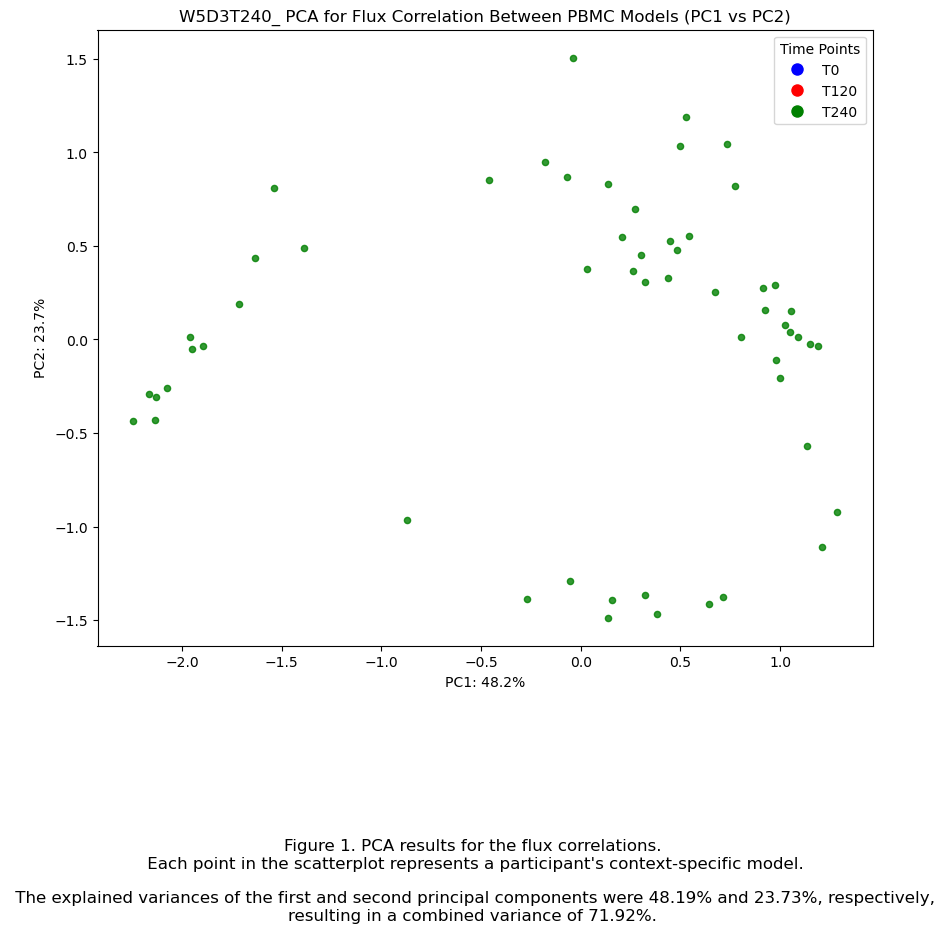

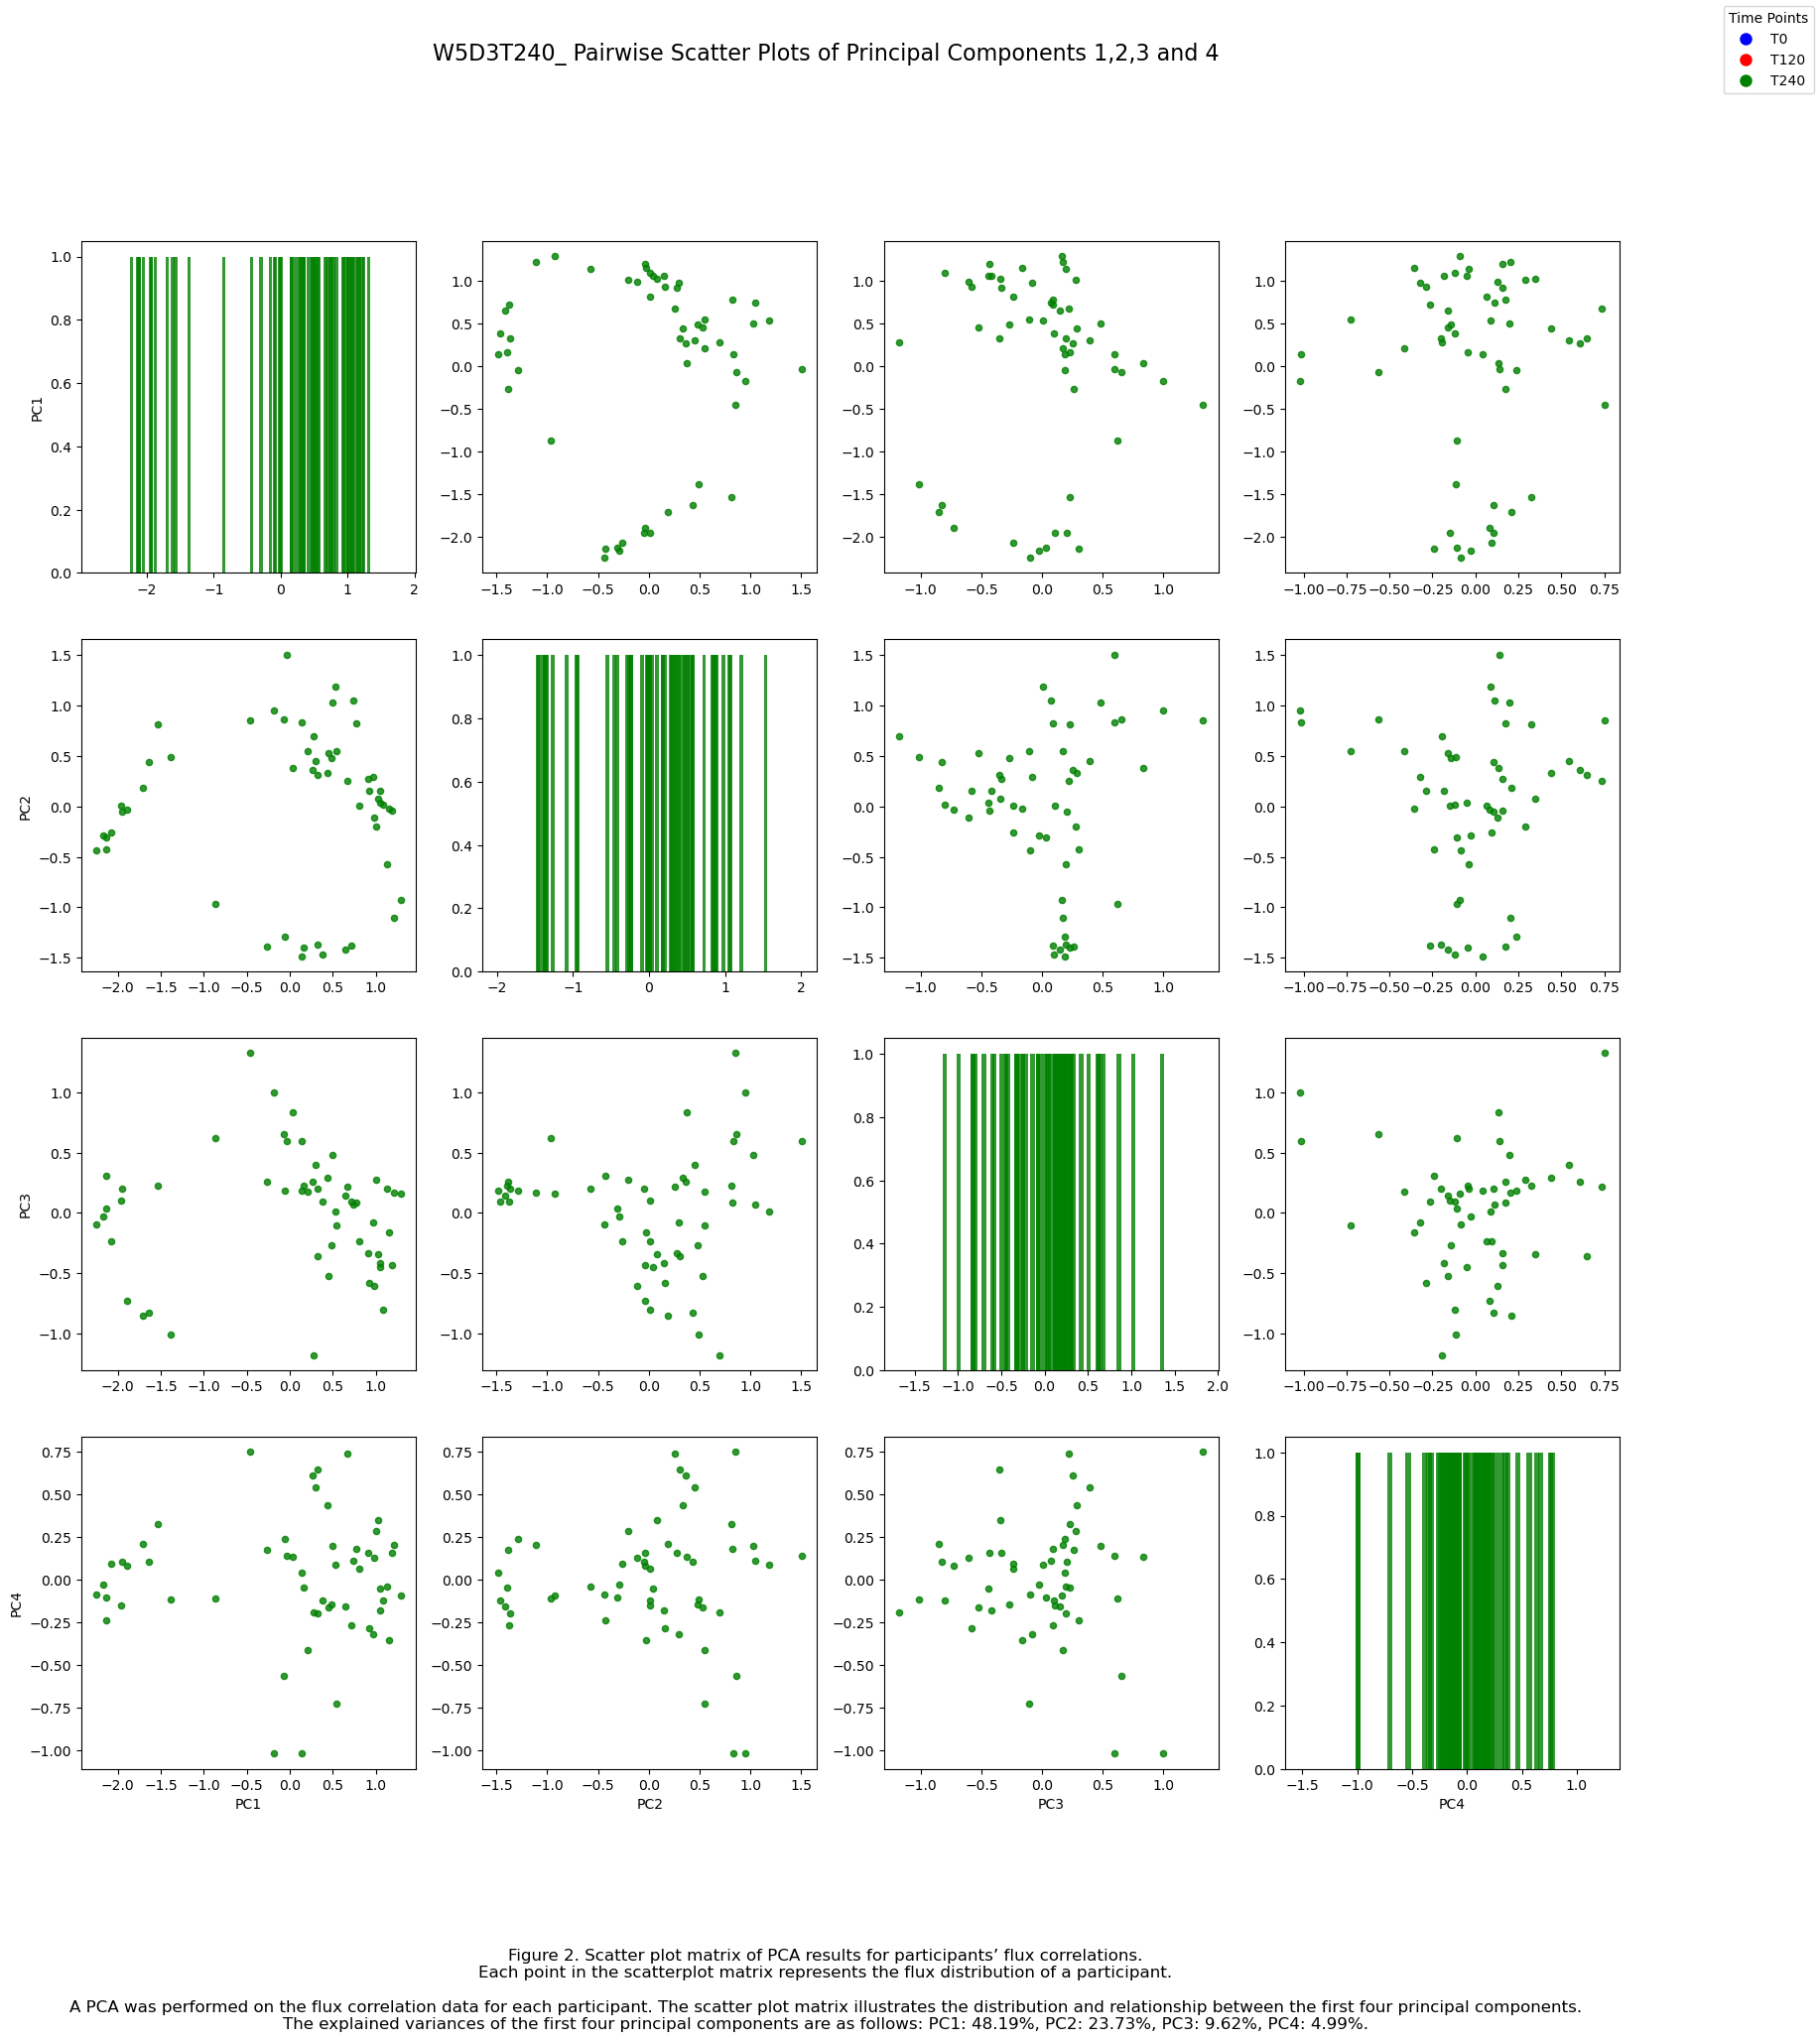

In [14]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your pw_flx3 data from the CSV file
pw_flxload = pd.read_csv('pw_flx2_3.csv')

# Extract sample labels (T0 or T120) from the column names
labels = [col.split('T')[-1] for col in pw_flxload.columns]

# Set the file_ID for naming plots and saved figures
file_ID = 'W5D3T240_'

# Perform PCA
pca = PCA(n_components=3)
pcaData = pca.fit_transform(pw_flxload.T)  # Transpose to make samples as rows
print(pca.explained_variance_ratio_)

title_font = {
    'weight': 'medium',
    'size': 12,
}
axis_font = {
    'weight': 'normal',
    'size': 10,
}

# Color coding based on time points
colors = ['blue' if label == '0' else 'red' if label == '120' else 'green' for label in labels]

# Plot PCA scatter plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
for i in range(len(labels)):
    xs = pcaData[i, 0]
    ys = pcaData[i, 1]
    plt.scatter(xs, ys, s=20, marker='o', color=colors[i], alpha=0.8)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='T240')]
plt.legend(handles=handles, title="Time Points")

plt.title(f'{file_ID} PCA for Flux Correlation Between PBMC Models (PC1 vs PC2)', title_font)
plt.xlabel('PC1: {:.1%}'.format(pca.explained_variance_ratio_[0]), axis_font)
plt.ylabel('PC2: {:.1%}'.format(pca.explained_variance_ratio_[1]), axis_font)
plt.figtext(0.5, -0.23, (f'Figure 1. PCA results for the flux correlations.\n Each point in the scatterplot represents a participant\'s context-specific model.\n\n The explained variances of the first and second principal components were {pca.explained_variance_ratio_[0]*100:.2f}% and {pca.explained_variance_ratio_[1]*100:.2f}%, respectively, resulting in a combined variance of {((pca.explained_variance_ratio_[0]*100)+(pca.explained_variance_ratio_[1]*100)):.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'{file_ID}fig.1_PCA_for_Flux_Correlation.png', dpi=1000)

####################### Create a 4x4 plot matrix of PC1, PC2, PC3, and PC4
# Perform PCA
pca = PCA(n_components=4)
pcaData = pca.fit_transform(pw_flxload.T)
explained_variance = pca.explained_variance_ratio_

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

pc_labels = ['PC1', 'PC2', 'PC3', 'PC4']
components = [pcaData[:, 0], pcaData[:, 1], pcaData[:, 2], pcaData[:, 3]]

for i in range(4):
    for j in range(4):
        if i == j:
            for k, c in zip(components[i], colors):
                axs[i, j].hist(k, bins=20, color=c, alpha=0.8)
        else:
            for x, y, c in zip(components[j], components[i], colors):
                axs[i, j].scatter(x, y, color=c, s=20, alpha=0.8)
        if i == 3:
            axs[i, j].set_xlabel(pc_labels[j])
        if j == 0:
            axs[i, j].set_ylabel(pc_labels[i])

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='T240')]
fig.legend(handles=handles, title="Time Points", loc='upper right')

plt.suptitle(f'{file_ID} Pairwise Scatter Plots of Principal Components 1,2,3 and 4', fontsize=16, weight='medium')
plt.figtext(0.5, -0.02, (f'Figure 2. Scatter plot matrix of PCA results for participants’ flux correlations.\n'
                         f'Each point in the scatterplot matrix represents the flux distribution of a participant.\n\n'
                         f'A PCA was performed on the flux correlation data for each participant. The scatter plot matrix illustrates the distribution and relationship between the first four principal components.\n'
                         f'The explained variances of the first four principal components are as follows: PC1: {explained_variance[0]*100:.2f}%, PC2: {explained_variance[1]*100:.2f}%, PC3: {explained_variance[2]*100:.2f}%, PC4: {explained_variance[3]*100:.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)

plt.savefig(f'{file_ID}fig.2_Pairwise_Scatter_Plots_of_PC1_to_PC4.png', dpi=1000)
plt.show()


# W5D3T*, code from docs, FBA = true

In [61]:
# %% Load the context-specific models
directory_path = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*'
context_specific_models = []
for filename in os.listdir(directory_path):
    if filename.endswith(".mat"):
        file_path = os.path.join(directory_path, filename)
        model = load_matlab_model(file_path)
        context_specific_models.append(model)

print(f"Loaded {len(context_specific_models)} models.")

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in mod

Loaded 168 models.


from ninas code
```python
ref_model = cobra.io.mat.load_matlab_model(path_ref)
rxn, met, gen, graphlist, flx = load_library(path_lib, ref_model, graph=True, sampling=True, FBA=False)

#%% Perform flux correlation between pairs of models
pw_flx = flux_DM(flx)

pca = PCA(n_components=2)
pcaData = pca.fit_transform(pw_flx)
print(pca.explained_variance_ratio_)
```

In [62]:
path_ref = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/Recon3D.mat'
ref_model = load_matlab_model(path_ref)

# Convert the list of models to a list of paths
file_paths = [Path(os.path.join(directory_path, f)) for f in os.listdir(directory_path) if f.endswith(".mat")]

# Call the load_library function to get the flux dataframe
reactions_matrix, metabolite_matrix, gene_matrix, flx_df = load_library(file_paths, ref_model, sampling=False, FBA=True)
#rxn, met, gen, graphlist, flx = load_library(file_paths, ref_model, sampling= False, FBA= True)


# Check the flux data frame
print(flx_df.head())



This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model Recon3D. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT001_W5D3T0
FBA...
<Solution 1000.000 at 0x342630b50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT008_W5D3T120
FBA...
<Solution 1000.000 at 0x343b7ad50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT140_W5D3T0
FBA...
<Solution 1000.000 at 0x3451adb10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT059_W5D3T0
FBA...
<Solution 1000.000 at 0x3468221d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT118_W5D3T0
FBA...
<Solution 1000.000 at 0x347d28ed0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT008_W5D3T240
FBA...
<Solution 1000.000 at 0x3496383d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT045_W5D3T0
FBA...
<Solution 1000.000 at 0x34ac90ad0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT133_W5D3T0
FBA...
<Solution 1000.000 at 0x34c492110>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT027_W5D3T0
FBA...
<Solution 1000.000 at 0x3488e2150>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT010_W5D3T0
FBA...
<Solution 1000.000 at 0x163000650>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT148_W5D3T0
FBA...
<Solution 944.444 at 0x34cd52990>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT077_W5D3T0
FBA...
<Solution 1000.000 at 0x2142e35d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT015_W5D3T0
FBA...
<Solution 1000.000 at 0x21816db90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT022_W5D3T0
FBA...
<Solution 1000.000 at 0x33be92cd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT148_W5D3T240
FBA...
<Solution 1000.000 at 0x341c7aed0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT148_W5D3T120
FBA...
<Solution 1000.000 at 0x342ef4690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT033_W5D3T0
FBA...
<Solution 1000.000 at 0x34e35ec10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT145_W5D3T0
FBA...
<Solution 1000.000 at 0x34fbf2ed0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT051_W5D3T0
FBA...
<Solution 1000.000 at 0x35124afd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT066_W5D3T0
FBA...
<Solution 1000.000 at 0x35286dc10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT018_W5D3T0
FBA...
<Solution 1000.000 at 0x353ff8750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT043_W5D3T240
FBA...
<Solution 1000.000 at 0x3555cffd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT020_W5D3T120
FBA...
<Solution 1000.000 at 0x356c11990>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT044_W5D3T240
FBA...
<Solution 1000.000 at 0x35826b090>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT150_W5D3T120
FBA...
<Solution 1000.000 at 0x3598363d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT027_W5D3T120
FBA...
<Solution 1000.000 at 0x35b15fa90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT133_W5D3T240
FBA...
<Solution 1000.000 at 0x35b9eb990>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT082_W5D3T0
FBA...
<Solution 1000.000 at 0x35dfbf990>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT034_W5D3T0
FBA...
<Solution 1000.000 at 0x35f73b750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT067_W5D3T120
FBA...
<Solution 1000.000 at 0x360ee2350>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT145_W5D3T120
FBA...
<Solution 1000.000 at 0x36259b090>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT120_W5D3T0
FBA...
<Solution 1000.000 at 0x363c140d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT051_W5D3T240
FBA...
<Solution 1000.000 at 0x36529d790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT056_W5D3T0
FBA...
<Solution 1000.000 at 0x366a859d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT060_W5D3T120
FBA...
<Solution 1000.000 at 0x3680f3cd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT035_W5D3T120
FBA...
<Solution 966.667 at 0x369685510>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT056_W5D3T240
FBA...
<Solution 1000.000 at 0x36ad311d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT056_W5D3T120
FBA...
<Solution 1000.000 at 0x36c380ed0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT035_W5D3T240
FBA...
<Solution 1000.000 at 0x36db95d90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT060_W5D3T240
FBA...
<Solution 1000.000 at 0x36f1a6b90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT051_W5D3T120
FBA...
<Solution 1000.000 at 0x3707c1990>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT145_W5D3T240
FBA...
<Solution 1000.000 at 0x36e8582d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT067_W5D3T240
FBA...
<Solution 1000.000 at 0x3669c66d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT070_W5D3T0
FBA...
<Solution 1000.000 at 0x35cdf3b10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT106_W5D3T0
FBA...
<Solution 1000.000 at 0x35090da50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT131_W5D3T0
FBA...
<Solution 1000.000 at 0x16862e550>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT025_W5D3T0
FBA...
<Solution 1000.000 at 0x3487e3d10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT133_W5D3T120
FBA...
<Solution 1000.000 at 0x34a6d7ad0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT027_W5D3T240
FBA...
<Solution 1000.000 at 0x349426010>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT150_W5D3T240
FBA...
<Solution 1000.000 at 0x2b8e7c750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT044_W5D3T120
FBA...
<Solution 1000.000 at 0x34304f310>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT020_W5D3T240
FBA...
<Solution 1000.000 at 0x357c80890>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT043_W5D3T120
FBA...
<Solution 1000.000 at 0x348991e90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT143_W5D3T120
FBA...
<Solution 1000.000 at 0x35929d690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT057_W5D3T240
FBA...
<Solution 1000.000 at 0x36384a990>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT002_W5D3T240
FBA...
<Solution 1000.000 at 0x350fb7d50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT120_W5D3T240
FBA...
<Solution 1000.000 at 0x346e9dfd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT034_W5D3T120
FBA...
<Solution 1000.000 at 0x347a66550>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT020_W5D3T0
FBA...
<Solution 1000.000 at 0x34b5c6710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT017_W5D3T0
FBA...
<Solution 1000.000 at 0x359e538d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT103_W5D3T0
FBA...
<Solution 1000.000 at 0x358f50750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT033_W5D3T120
FBA...
<Solution 1000.000 at 0x355ce5590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT066_W5D3T120
FBA...
<Solution 1000.000 at 0x35a155550>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT132_W5D3T240
FBA...
<Solution 1000.000 at 0x372d59410>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT045_W5D3T240
FBA...
<Solution 1000.000 at 0x37442c350>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT010_W5D3T240
FBA...
<Solution 1000.000 at 0x375b738d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT021_W5D3T120
FBA...
<Solution 1000.000 at 0x3773de3d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT017_W5D3T240
FBA...
<Solution 1000.000 at 0x378aeeb50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT103_W5D3T120
FBA...
<Solution 1000.000 at 0x37a1164d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT103_W5D3T240
FBA...
<Solution 1000.000 at 0x37b799dd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT017_W5D3T120
FBA...
<Solution 1000.000 at 0x37cfdad10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT021_W5D3T240
FBA...
<Solution 1000.000 at 0x37e77e8d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT010_W5D3T120
FBA...
<Solution 1000.000 at 0x37fefb850>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT045_W5D3T120
FBA...
<Solution 1000.000 at 0x38155fe50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT132_W5D3T120
FBA...
<Solution 1000.000 at 0x382b9f1d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT066_W5D3T240
FBA...
<Solution 1000.000 at 0x3821bc410>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT033_W5D3T240
FBA...
<Solution 1000.000 at 0x3765c3e90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT034_W5D3T240
FBA...
<Solution 1000.000 at 0x352f825d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT120_W5D3T120
FBA...
<Solution 1000.000 at 0x36a5b8e10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT002_W5D3T120
FBA...
<Solution 1000.000 at 0x34a823790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT057_W5D3T120
FBA...
<Solution 1000.000 at 0x349e28310>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT143_W5D3T240
FBA...
<Solution 1000.000 at 0x354e5a790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT006_W5D3T0
FBA...
<Solution 1000.000 at 0x368c22e10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT031_W5D3T0
FBA...
<Solution 1000.000 at 0x36ed118d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT064_W5D3T0
FBA...
<Solution 1000.000 at 0x36eae66d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT053_W5D3T0
FBA...
<Solution 1000.000 at 0x344650190>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT064_W5D3T120
FBA...
<Solution 1000.000 at 0x342d90c90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT031_W5D3T120
FBA...
<Solution 1000.000 at 0x347823250>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT146_W5D3T120
FBA...
<Solution 1000.000 at 0x38078e5d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT114_W5D3T120
FBA...
<Solution 1000.000 at 0x37c970450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT008_W5D3T0
FBA...
<Solution 1000.000 at 0x37ad23790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT076_W5D3T0
FBA...
<Solution 1000.000 at 0x37675fdd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT015_W5D3T240
FBA...
<Solution 1000.000 at 0x372631410>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT076_W5D3T120
FBA...
<Solution 1000.000 at 0x35e68fcd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT023_W5D3T120
FBA...
<Solution 1000.000 at 0x372b7a850>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT137_W5D3T240
FBA...
<Solution 1000.000 at 0x35ef5f9d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT023_W5D3T0
FBA...
<Solution 1000.000 at 0x380776650>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT106_W5D3T120
FBA...
<Solution 1000.000 at 0x3846b88d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT137_W5D3T0
FBA...
<Solution 1000.000 at 0x385e1f050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT067_W5D3T0
FBA...
<Solution 1000.000 at 0x387651c10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT106_W5D3T240
FBA...
<Solution 1000.000 at 0x388cb0290>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT137_W5D3T120
FBA...
<Solution 1000.000 at 0x38a20ae50>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT023_W5D3T240
FBA...
<Solution 1000.000 at 0x38b7f2a10>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT076_W5D3T240
FBA...
<Solution 1000.000 at 0x38ce81350>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT015_W5D3T120
FBA...
<Solution 1000.000 at 0x38e62df10>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT114_W5D3T240
FBA...
<Solution 1000.000 at 0x38fc66890>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT084_W5D3T0
FBA...
<Solution 1000.000 at 0x39139b650>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT146_W5D3T240
FBA...
<Solution 1000.000 at 0x392a7e750>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT031_W5D3T240
FBA...
<Solution 1000.000 at 0x39338ef90>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT064_W5D3T240
FBA...
<Solution 1000.000 at 0x3957d5850>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT025_W5D3T120
FBA...
<Solution 1000.000 at 0x3934166d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT070_W5D3T120
FBA...
<Solution 1000.000 at 0x38ae6c610>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT131_W5D3T240
FBA...
<Solution 1000.000 at 0x373677f50>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT114_W5D3T0
FBA...
<Solution 1000.000 at 0x37fcaccd0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT046_W5D3T240
FBA...
<Solution 1000.000 at 0x371722210>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT013_W5D3T240
FBA...
<Solution 1000.000 at 0x348855290>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT152_W5D3T120
FBA...
<Solution 1000.000 at 0x341b6ac90>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT123_W5D3T0
FBA...
<Solution 1000.000 at 0x368d6ed50>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT022_W5D3T120
FBA...
<Solution 1000.000 at 0x369ea7b50>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT077_W5D3T120
FBA...
<Solution 1000.000 at 0x381fb1d50>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT140_W5D3T120
FBA...
<Solution 1000.000 at 0x375b28f90>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT001_W5D3T240
FBA...
<Solution 1000.000 at 0x37e3d66d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT123_W5D3T240
FBA...
<Solution 1000.000 at 0x353683710>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT053_W5D3T240
FBA...
<Solution 1000.000 at 0x39350acd0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT006_W5D3T240
FBA...
<Solution 1000.000 at 0x37a0d6e10>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT006_W5D3T120
FBA...
<Solution 1000.000 at 0x376d26c50>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT053_W5D3T120
FBA...
<Solution 1000.000 at 0x38b206b50>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT123_W5D3T120
FBA...
<Solution 1000.000 at 0x38c8d4ad0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT001_W5D3T120
FBA...
<Solution 1000.000 at 0x38c76be90>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT090_W5D3T0
FBA...
<Solution 1000.000 at 0x38a83a3d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT140_W5D3T240
FBA...
<Solution 1000.000 at 0x3838d05d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT150_W5D3T0
FBA...
<Solution 1000.000 at 0x3833ee510>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT044_W5D3T0
FBA...
<Solution 1000.000 at 0x3865284d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT132_W5D3T0
FBA...
<Solution 1000.000 at 0x397c3fd10>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT077_W5D3T240
FBA...
<Solution 1000.000 at 0x3992484d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT022_W5D3T240
FBA...
<Solution 1000.000 at 0x39a972d50>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT152_W5D3T240
FBA...
<Solution 1000.000 at 0x39c07e350>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT013_W5D3T120
FBA...
<Solution 1000.000 at 0x39d815d90>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT046_W5D3T120
FBA...
<Solution 1000.000 at 0x39ee0e110>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT131_W5D3T120
FBA...
<Solution 1000.000 at 0x3a0432f50>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT070_W5D3T240
FBA...
<Solution 1000.000 at 0x3a18dec90>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT025_W5D3T240
FBA...
<Solution 1000.000 at 0x3a3011550>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT043_W5D3T0
FBA...
<Solution 1000.000 at 0x3a46aefd0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT082_W5D3T240
FBA...
<Solution 1000.000 at 0x3a5dc8050>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT021_W5D3T0
FBA...
<Solution 1000.000 at 0x3a76300d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT129_W5D3T120
FBA...
<Solution 1000.000 at 0x3a8b9c110>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT118_W5D3T240
FBA...


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

<Solution 1000.000 at 0x3a5296b10>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  flx_df[label] = sol.fluxes
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT059_W5D3T120
FBA...
<Solution 1000.000 at 0x3a2888990>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT129_W5D3T0
FBA...
<Solution 1000.000 at 0x3845b70d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT090_W5D3T240
FBA...
<Solution 1000.000 at 0x34f8ba810>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT090_W5D3T120
FBA...
<Solution 1000.000 at 0x35093fad0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT059_W5D3T240
FBA...
<Solution 1000.000 at 0x34ba860d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT118_W5D3T120
FBA...
<Solution 1000.000 at 0x36fccf950>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT129_W5D3T240
FBA...
<Solution 1000.000 at 0x3636104d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT146_W5D3T0
FBA...
<Solution 1000.000 at 0x38e6fab50>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT082_W5D3T120
FBA...
<Solution 1000.000 at 0x3966c4bd0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT035_W5D3T0
FBA...
<Solution 1000.000 at 0x3a6a1fb10>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT002_W5D3T0
FBA...
<Solution 1000.000 at 0x3a9b05110>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT057_W5D3T0
FBA...
<Solution 1000.000 at 0x350208d50>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT018_W5D3T120
FBA...
<Solution 1000.000 at 0x36bb22550>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT060_W5D3T0
FBA...
<Solution 1000.000 at 0x382aecc50>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT084_W5D3T240
FBA...
<Solution 1000.000 at 0x3a1e6f610>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT143_W5D3T0
FBA...
<Solution 1000.000 at 0x39d273850>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT152_W5D3T0
FBA...
<Solution 1000.000 at 0x39d835d10>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT046_W5D3T0
FBA...
<Solution 1000.000 at 0x39e300650>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT013_W5D3T0
FBA...
<Solution 1000.000 at 0x39b3f4a10>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT084_W5D3T120
FBA...
<Solution 1000.000 at 0x384415250>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT018_W5D3T240
FBA...
<Solution 1000.000 at 0x39fb0a890>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_83375/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has po

                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT001_W5D3T0  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                              
25HVITD3t                                                          NaN                                                                                                                                                                                                              
COAtl                                                              NaN                                                                                                   

In [63]:
reactions_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT001_W5D3T0  \
24_25DHVITD3tm                                                       0                                                                                                                                                                                                              
25HVITD3t                                                            0                                                                                                                                                                                                              
COAtl                                                                0                                                                                                                                                                                                              
EX_5adtststerone_e                                                   0                                                                                                                                                                                                              
EX_5adtststerones_e                                                  0                                                                                                                                                                                                              
...                                                                ...                                                                                                                                                                                                              
ACMPGLUTTRsc                                                         0                                                                                                                                                                                                              
FVSCOAhc                                                             0                                                                                                                                                                                                              
MDZGLChr                                                             0                                                                                                                                                                                                              
TMACMPhr                                                             0                                                                                                                                                                                                              
CYSACMPitr                                                           0                                                                                                                                                                                                              

                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT008_W5D3T120  \
24_25DHVITD3tm                                                       0                                                                                                                                                                                                                
25HVITD3t                                                            0                                                                    

In [64]:
metabolite_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT001_W5D3T0  \
10fthf_c                                                       0                                                                                                                                                                                                              
10fthf_l                                                       0                                                                                                                                                                                                              
10fthf_m                                                       0                                                                                                                                                                                                              
11docrtsl_c                                                    0                                                                                                                                                                                                              
11docrtsl_m                                                    0                                                                                                                                                                                                              
...                                                          ...                                                                                                                                                                                                              
caproic_e                                                      0                                                                                                                                                                                                              
1a25dhvitd2_c                                                  0                                                                                                                                                                                                              
1a25dhvitd2_e                                                  0                                                                                                                                                                                                              
protein_c                                                      0                                                                                                                                                                                                              
h_i                                                            0                                                                                                                                                                                                              

               /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT008_W5D3T120  \
10fthf_c                                                       0                                                                                                                                                                                                                
10fthf_l                                                       0                                                                                                                                                        

In [65]:
gene_matrix

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT001_W5D3T0  \
0                                                          1                                                                                                                                                                                                              
26_AT1                                                     0                                                                                                                                                                                                              
314_AT1                                                    0                                                                                                                                                                                                              
8639_AT1                                                   0                                                                                                                                                                                                              
314_AT2                                                    0                                                                                                                                                                                                              
...                                                      ...                                                                                                                                                                                                              
27089_AT1                                                  0                                                                                                                                                                                                              
10975_AT1                                                  0                                                                                                                                                                                                              
7381_AT1                                                   0                                                                                                                                                                                                              
29796_AT1                                                  0                                                                                                                                                                                                              
4519_AT1                                                   0                                                                                                                                                                                                              

           /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT008_W5D3T120  \
0                                                          1                                                                                                                                                                                                                
26_AT1                                                     0                                                                                                                                                                                                                

In [66]:
flx_df

/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT001_W5D3T0  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                              
25HVITD3t                                                          NaN                                                                                                                                                                                                              
COAtl                                                              NaN                                                                                                                                                                                                              
EX_5adtststerone_e                                                 NaN                                                                                                                                                                                                              
EX_5adtststerones_e                                                NaN                                                                                                                                                                                                              
...                                                                ...                                                                                                                                                                                                              
ACMPGLUTTRsc                                                       NaN                                                                                                                                                                                                              
FVSCOAhc                                                           NaN                                                                                                                                                                                                              
MDZGLChr                                                           NaN                                                                                                                                                                                                              
TMACMPhr                                                           NaN                                                                                                                                                                                                              
CYSACMPitr                                                         NaN                                                                                                                                                                                                              

                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T*/NT008_W5D3T120  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                                
25HVITD3t                                                          NaN                                                                    

In [67]:
#%% Perform flux correlation between pairs of models
pw_flx2_4 = flux_DM(flx_df)
pw_flx2_4
# Save pw_flx1 as a CSV file
pw_flx2_4.to_csv('pw_flx2_4.csv', index=False)

figure out what idx.drop is doing and if flx_df is compatible , why or why not?

[0.37920059 0.23307487 0.17100745]


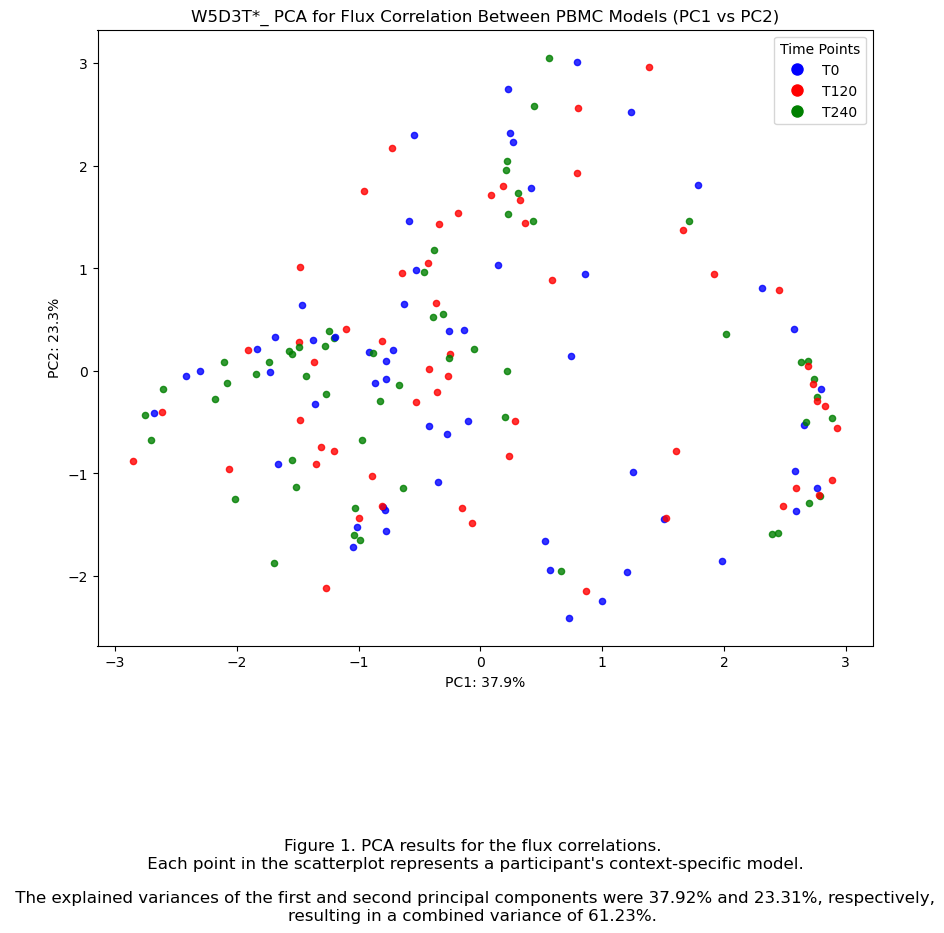

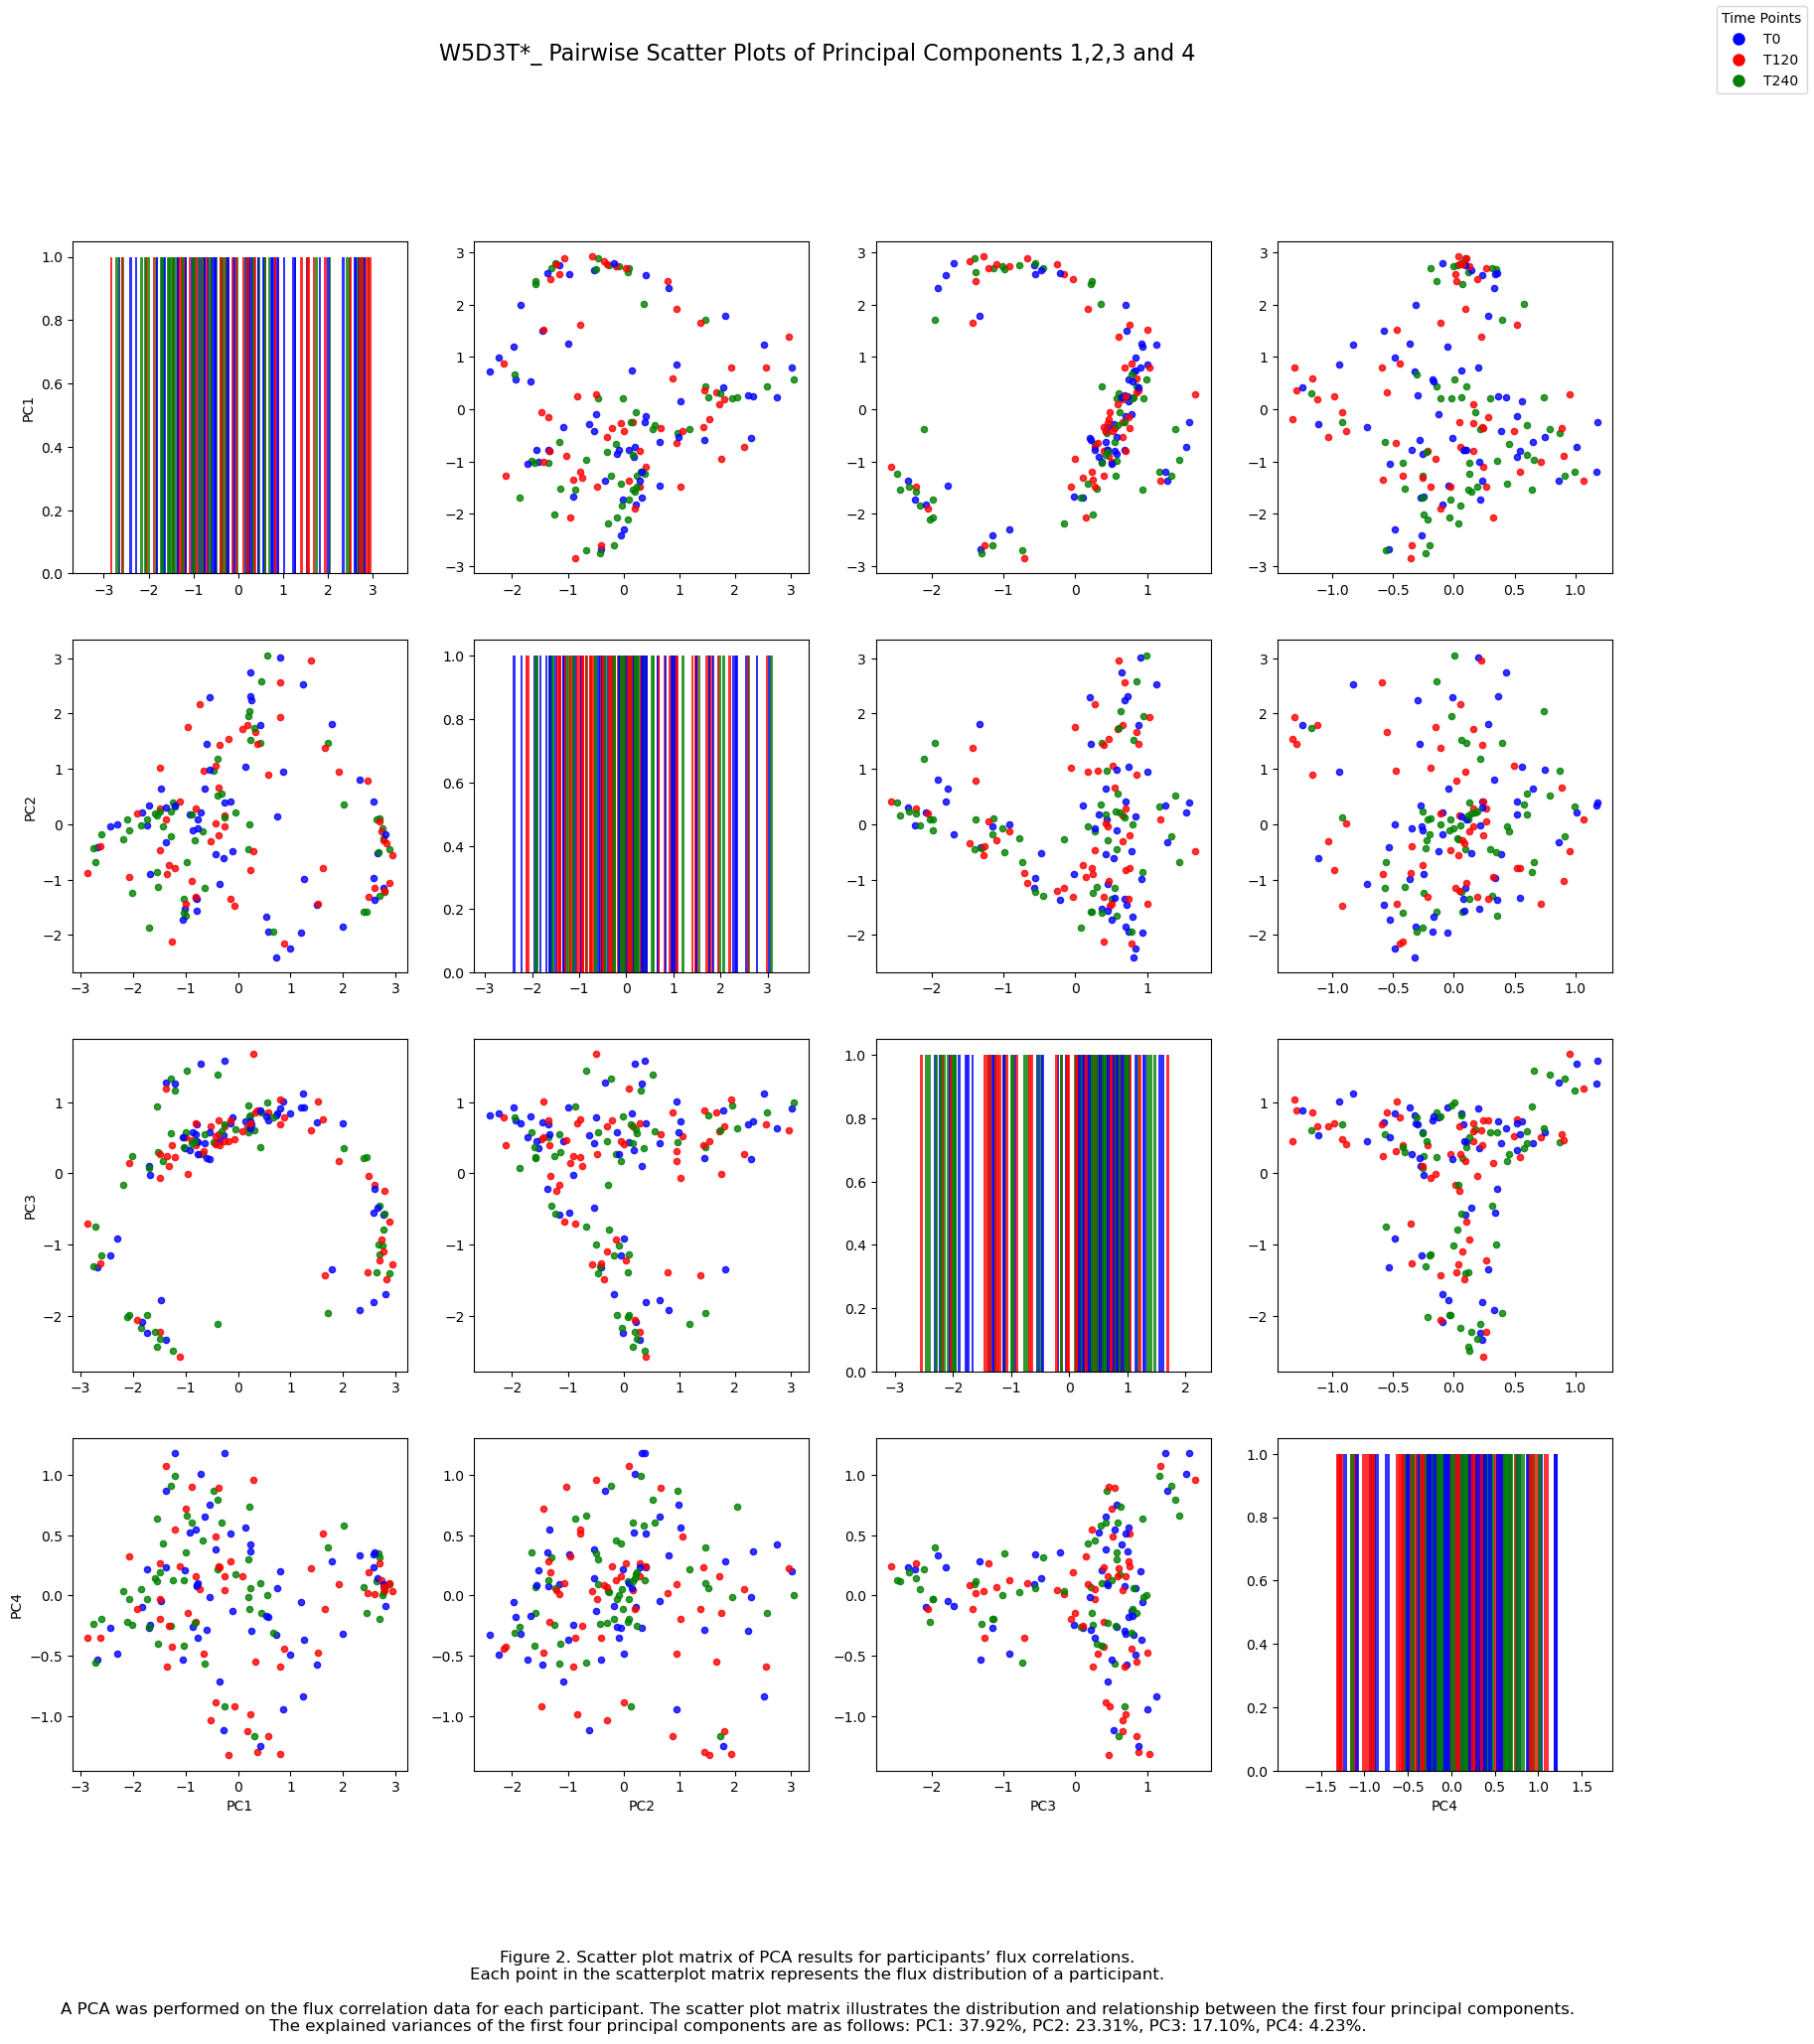

In [13]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your pw_flx3 data from the CSV file
pw_flxload = pd.read_csv('pw_flx2_4.csv')

# Extract sample labels (T0, T120, or T240) from the column names
labels = [col.split('T')[-1] for col in pw_flxload.columns]

# Set the file_ID for naming plots and saved figures
file_ID = 'W5D3T*_'

# Perform PCA
pca = PCA(n_components=3)
pcaData = pca.fit_transform(pw_flxload.T)  # Transpose to make samples as rows
print(pca.explained_variance_ratio_)

title_font = {
    'weight': 'medium',
    'size': 12,
}
axis_font = {
    'weight': 'normal',
    'size': 10,
}

# Color coding based on time points
colors = ['blue' if label == '0' else 'red' if label == '120' else 'green' for label in labels]

# Plot PCA scatter plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
for i in range(len(labels)):
    xs = pcaData[i, 0]
    ys = pcaData[i, 1]
    plt.scatter(xs, ys, s=20, marker='o', color=colors[i], alpha=0.8)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='T240')]
plt.legend(handles=handles, title="Time Points")

plt.title(f'{file_ID} PCA for Flux Correlation Between PBMC Models (PC1 vs PC2)', title_font)
plt.xlabel('PC1: {:.1%}'.format(pca.explained_variance_ratio_[0]), axis_font)
plt.ylabel('PC2: {:.1%}'.format(pca.explained_variance_ratio_[1]), axis_font)
plt.figtext(0.5, -0.23, (f'Figure 1. PCA results for the flux correlations.\n Each point in the scatterplot represents a participant\'s context-specific model.\n\n The explained variances of the first and second principal components were {pca.explained_variance_ratio_[0]*100:.2f}% and {pca.explained_variance_ratio_[1]*100:.2f}%, respectively, resulting in a combined variance of {((pca.explained_variance_ratio_[0]*100)+(pca.explained_variance_ratio_[1]*100)):.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'{file_ID}fig.1_PCA_for_Flux_Correlation.png', dpi=1000)

####################### Create a 4x4 plot matrix of PC1, PC2, PC3, and PC4
# Perform PCA
pca = PCA(n_components=4)
pcaData = pca.fit_transform(pw_flxload.T)
explained_variance = pca.explained_variance_ratio_

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

pc_labels = ['PC1', 'PC2', 'PC3', 'PC4']
components = [pcaData[:, 0], pcaData[:, 1], pcaData[:, 2], pcaData[:, 3]]

for i in range(4):
    for j in range(4):
        if i == j:
            for k, c in zip(components[i], colors):
                axs[i, j].hist(k, bins=20, color=c, alpha=0.8)
        else:
            for x, y, c in zip(components[j], components[i], colors):
                axs[i, j].scatter(x, y, color=c, s=20, alpha=0.8)
        if i == 3:
            axs[i, j].set_xlabel(pc_labels[j])
        if j == 0:
            axs[i, j].set_ylabel(pc_labels[i])

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='T240')]
fig.legend(handles=handles, title="Time Points", loc='upper right')

plt.suptitle(f'{file_ID} Pairwise Scatter Plots of Principal Components 1,2,3 and 4', fontsize=16, weight='medium')
plt.figtext(0.5, -0.02, (f'Figure 2. Scatter plot matrix of PCA results for participants’ flux correlations.\n'
                         f'Each point in the scatterplot matrix represents the flux distribution of a participant.\n\n'
                         f'A PCA was performed on the flux correlation data for each participant. The scatter plot matrix illustrates the distribution and relationship between the first four principal components.\n'
                         f'The explained variances of the first four principal components are as follows: PC1: {explained_variance[0]*100:.2f}%, PC2: {explained_variance[1]*100:.2f}%, PC3: {explained_variance[2]*100:.2f}%, PC4: {explained_variance[3]*100:.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)

plt.savefig(f'{file_ID}fig.2_Pairwise_Scatter_Plots_of_PC1_to_PC4.png', dpi=1000)
plt.show()


# W5D3T0_T120 

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-03


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in mod

Loaded 112 models.


This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model Recon3D. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT001_W5D3T0
FBA...
<Solution 1000.000 at 0x1f52cc5d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT008_W5D3T120
FBA...
<Solution 1000.000 at 0x1f69b1c50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT140_W5D3T0
FBA...
<Solution 1000.000 at 0x1f7fc8b50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT059_W5D3T0
FBA...
<Solution 1000.000 at 0x1f5f357d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT118_W5D3T0
FBA...
<Solution 1000.000 at 0x1f8b38310>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT045_W5D3T0
FBA...
<Solution 1000.000 at 0x1fa5457d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT133_W5D3T0
FBA...
<Solution 1000.000 at 0x1fbcc8750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT027_W5D3T0
FBA...
<Solution 1000.000 at 0x1fd3e4c90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT010_W5D3T0
FBA...
<Solution 1000.000 at 0x1febc1d90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT148_W5D3T0
FBA...
<Solution 944.444 at 0x2002b7890>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT077_W5D3T0
FBA...
<Solution 1000.000 at 0x2018f4810>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT015_W5D3T0
FBA...
<Solution 1000.000 at 0x2031c0510>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT022_W5D3T0
FBA...
<Solution 1000.000 at 0x2047af1d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT148_W5D3T120
FBA...
<Solution 1000.000 at 0x205d37890>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT033_W5D3T0
FBA...
<Solution 1000.000 at 0x20744b9d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT145_W5D3T0
FBA...
<Solution 1000.000 at 0x208d38d50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT051_W5D3T0
FBA...
<Solution 1000.000 at 0x20661a9d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT066_W5D3T0
FBA...
<Solution 1000.000 at 0x1fbc10050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT018_W5D3T0
FBA...
<Solution 1000.000 at 0x1f78334d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT020_W5D3T120
FBA...
<Solution 1000.000 at 0x202bd4450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT150_W5D3T120
FBA...
<Solution 1000.000 at 0x1fa084ad0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT027_W5D3T120
FBA...
<Solution 1000.000 at 0x1fe45d050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT082_W5D3T0
FBA...
<Solution 1000.000 at 0x200ca5a50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT034_W5D3T0
FBA...
<Solution 1000.000 at 0x1f705bc90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT067_W5D3T120
FBA...
<Solution 1000.000 at 0x200918c50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT145_W5D3T120
FBA...
<Solution 1000.000 at 0x20b3e4a50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT120_W5D3T0
FBA...
<Solution 1000.000 at 0x20bc86950>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT056_W5D3T0
FBA...
<Solution 1000.000 at 0x20e1fd150>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT060_W5D3T120
FBA...
<Solution 1000.000 at 0x20f82b290>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT035_W5D3T120
FBA...
<Solution 966.667 at 0x210e1fe50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT056_W5D3T120
FBA...
<Solution 1000.000 at 0x211629150>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT051_W5D3T120
FBA...
<Solution 1000.000 at 0x1f765a810>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT070_W5D3T0
FBA...
<Solution 1000.000 at 0x1f72c8b10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT106_W5D3T0
FBA...
<Solution 1000.000 at 0x2095f0c90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT131_W5D3T0
FBA...
<Solution 1000.000 at 0x1fb069c90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT025_W5D3T0
FBA...
<Solution 1000.000 at 0x20402d790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT133_W5D3T120
FBA...
<Solution 1000.000 at 0x203d1cb10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT044_W5D3T120
FBA...
<Solution 1000.000 at 0x20c6f6790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT043_W5D3T120
FBA...
<Solution 1000.000 at 0x2083c1b10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT143_W5D3T120
FBA...
<Solution 1000.000 at 0x212254790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT034_W5D3T120
FBA...
<Solution 1000.000 at 0x21388f010>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT020_W5D3T0
FBA...
<Solution 1000.000 at 0x214ffc690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT017_W5D3T0
FBA...
<Solution 1000.000 at 0x21672e190>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT103_W5D3T0
FBA...
<Solution 1000.000 at 0x216ffbfd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT033_W5D3T120
FBA...
<Solution 1000.000 at 0x2158c8d90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT066_W5D3T120
FBA...
<Solution 1000.000 at 0x203d1d750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT021_W5D3T120
FBA...
<Solution 1000.000 at 0x2127ec590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT103_W5D3T120
FBA...
<Solution 1000.000 at 0x1fe95a090>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT017_W5D3T120
FBA...
<Solution 1000.000 at 0x1f62ae550>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT010_W5D3T120
FBA...
<Solution 1000.000 at 0x20d077c90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT045_W5D3T120
FBA...
<Solution 1000.000 at 0x1fdc033d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT132_W5D3T120
FBA...
<Solution 1000.000 at 0x2192ca390>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT120_W5D3T120
FBA...
<Solution 1000.000 at 0x21201a8d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT002_W5D3T120
FBA...
<Solution 1000.000 at 0x2198262d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT057_W5D3T120
FBA...
<Solution 1000.000 at 0x21ae14490>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT006_W5D3T0
FBA...
<Solution 1000.000 at 0x21c6161d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT031_W5D3T0
FBA...
<Solution 1000.000 at 0x21dcf9350>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT064_W5D3T0
FBA...
<Solution 1000.000 at 0x21f2f0e90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT053_W5D3T0
FBA...
<Solution 1000.000 at 0x220a89810>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT064_W5D3T120
FBA...
<Solution 1000.000 at 0x20db3a510>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT031_W5D3T120
FBA...
<Solution 1000.000 at 0x1ff8cd350>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT146_W5D3T120
FBA...
<Solution 1000.000 at 0x212ecb690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT114_W5D3T120
FBA...
<Solution 1000.000 at 0x1fbcdd190>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT008_W5D3T0
FBA...
<Solution 1000.000 at 0x21d2f1f50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT076_W5D3T0
FBA...
<Solution 1000.000 at 0x20eed9750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT076_W5D3T120
FBA...
<Solution 1000.000 at 0x219287090>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT023_W5D3T120
FBA...
<Solution 1000.000 at 0x21c39c290>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT023_W5D3T0
FBA...
<Solution 1000.000 at 0x21758f610>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT106_W5D3T120
FBA...
<Solution 1000.000 at 0x221392ed0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT137_W5D3T0
FBA...
<Solution 1000.000 at 0x222ad1a10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT067_W5D3T0
FBA...
<Solution 1000.000 at 0x22433b8d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT137_W5D3T120
FBA...
<Solution 1000.000 at 0x2258d8650>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT015_W5D3T120
FBA...
<Solution 1000.000 at 0x227059d90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT084_W5D3T0
FBA...
<Solution 1000.000 at 0x2286cb910>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT025_W5D3T120
FBA...
<Solution 1000.000 at 0x21b965490>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT070_W5D3T120
FBA...
<Solution 1000.000 at 0x2223b3350>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT114_W5D3T0
FBA...
<Solution 1000.000 at 0x20c2f4f50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT152_W5D3T120
FBA...
<Solution 1000.000 at 0x1ffc2f350>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT123_W5D3T0
FBA...
<Solution 1000.000 at 0x21ac25350>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT022_W5D3T120
FBA...
<Solution 1000.000 at 0x215b3a250>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT077_W5D3T120
FBA...
<Solution 1000.000 at 0x216eb57d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT140_W5D3T120
FBA...
<Solution 1000.000 at 0x228407590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT006_W5D3T120
FBA...
<Solution 1000.000 at 0x21fabc290>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT053_W5D3T120
FBA...
<Solution 1000.000 at 0x229b95e90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT123_W5D3T120
FBA...
<Solution 1000.000 at 0x22b30c110>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT001_W5D3T120
FBA...
<Solution 1000.000 at 0x22c9d2cd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT090_W5D3T0
FBA...
<Solution 1000.000 at 0x22e0d9890>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT150_W5D3T0
FBA...
<Solution 1000.000 at 0x22fc18090>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT044_W5D3T0
FBA...
<Solution 1000.000 at 0x231121110>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT132_W5D3T0
FBA...
<Solution 1000.000 at 0x216f2bad0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT013_W5D3T120
FBA...
<Solution 1000.000 at 0x2023e8e90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT046_W5D3T120
FBA...
<Solution 1000.000 at 0x209dc7f50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT131_W5D3T120
FBA...
<Solution 1000.000 at 0x21a097190>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT043_W5D3T0
FBA...
<Solution 1000.000 at 0x22761ead0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT021_W5D3T0
FBA...
<Solution 1000.000 at 0x21656fe50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT129_W5D3T120
FBA...
<Solution 1000.000 at 0x2287a6690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT059_W5D3T120
FBA...
<Solution 1000.000 at 0x226a7ff50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT129_W5D3T0
FBA...
<Solution 1000.000 at 0x22ea84210>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT090_W5D3T120
FBA...
<Solution 1000.000 at 0x22bb1b050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT118_W5D3T120
FBA...
<Solution 1000.000 at 0x2321fcb10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT146_W5D3T0
FBA...
<Solution 1000.000 at 0x2338f78d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT082_W5D3T120
FBA...
<Solution 1000.000 at 0x234ef8950>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT035_W5D3T0
FBA...
<Solution 1000.000 at 0x2365432d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT002_W5D3T0
FBA...
<Solution 1000.000 at 0x237c0b350>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT057_W5D3T0
FBA...
<Solution 1000.000 at 0x2391df550>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT018_W5D3T120
FBA...
<Solution 1000.000 at 0x22b0b0610>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT060_W5D3T0
FBA...
<Solution 1000.000 at 0x22591c210>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT143_W5D3T0
FBA...


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

<Solution 1000.000 at 0x2169e3650>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  flx_df[label] = sol.fluxes
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT152_W5D3T0


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

FBA...
<Solution 1000.000 at 0x21d66f110>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  flx_df[label] = sol.fluxes
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT046_W5D3T0
FBA...


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

<Solution 1000.000 at 0x22da2b590>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  flx_df[label] = sol.fluxes
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT013_W5D3T0
FBA...


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

<Solution 1000.000 at 0x20b308c50>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:74: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  flx_df[label] = sol.fluxes
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT084_W5D3T120
FBA...
<Solution 1000.000 at 0x229107010>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T120/NT001_W5D3T0  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                                   
25HVITD3t                                                          NaN                                                                                                                                                                                                                   
COAtl                                                              NaN                                                                                    

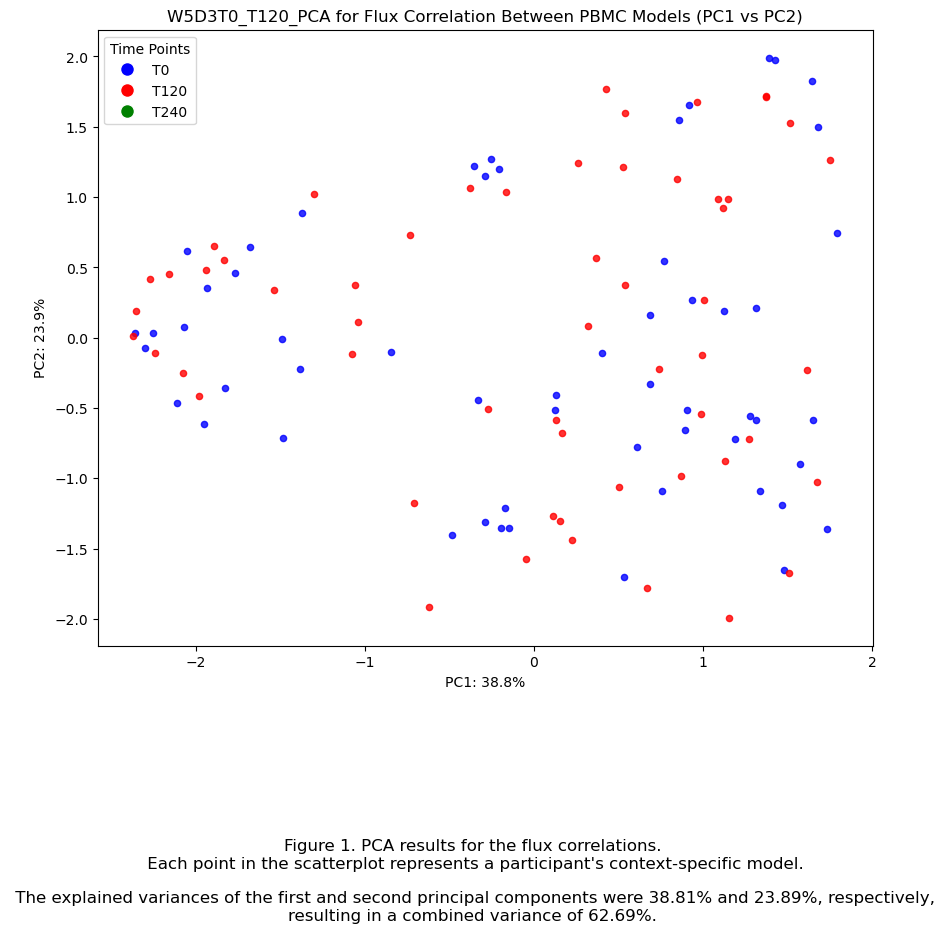

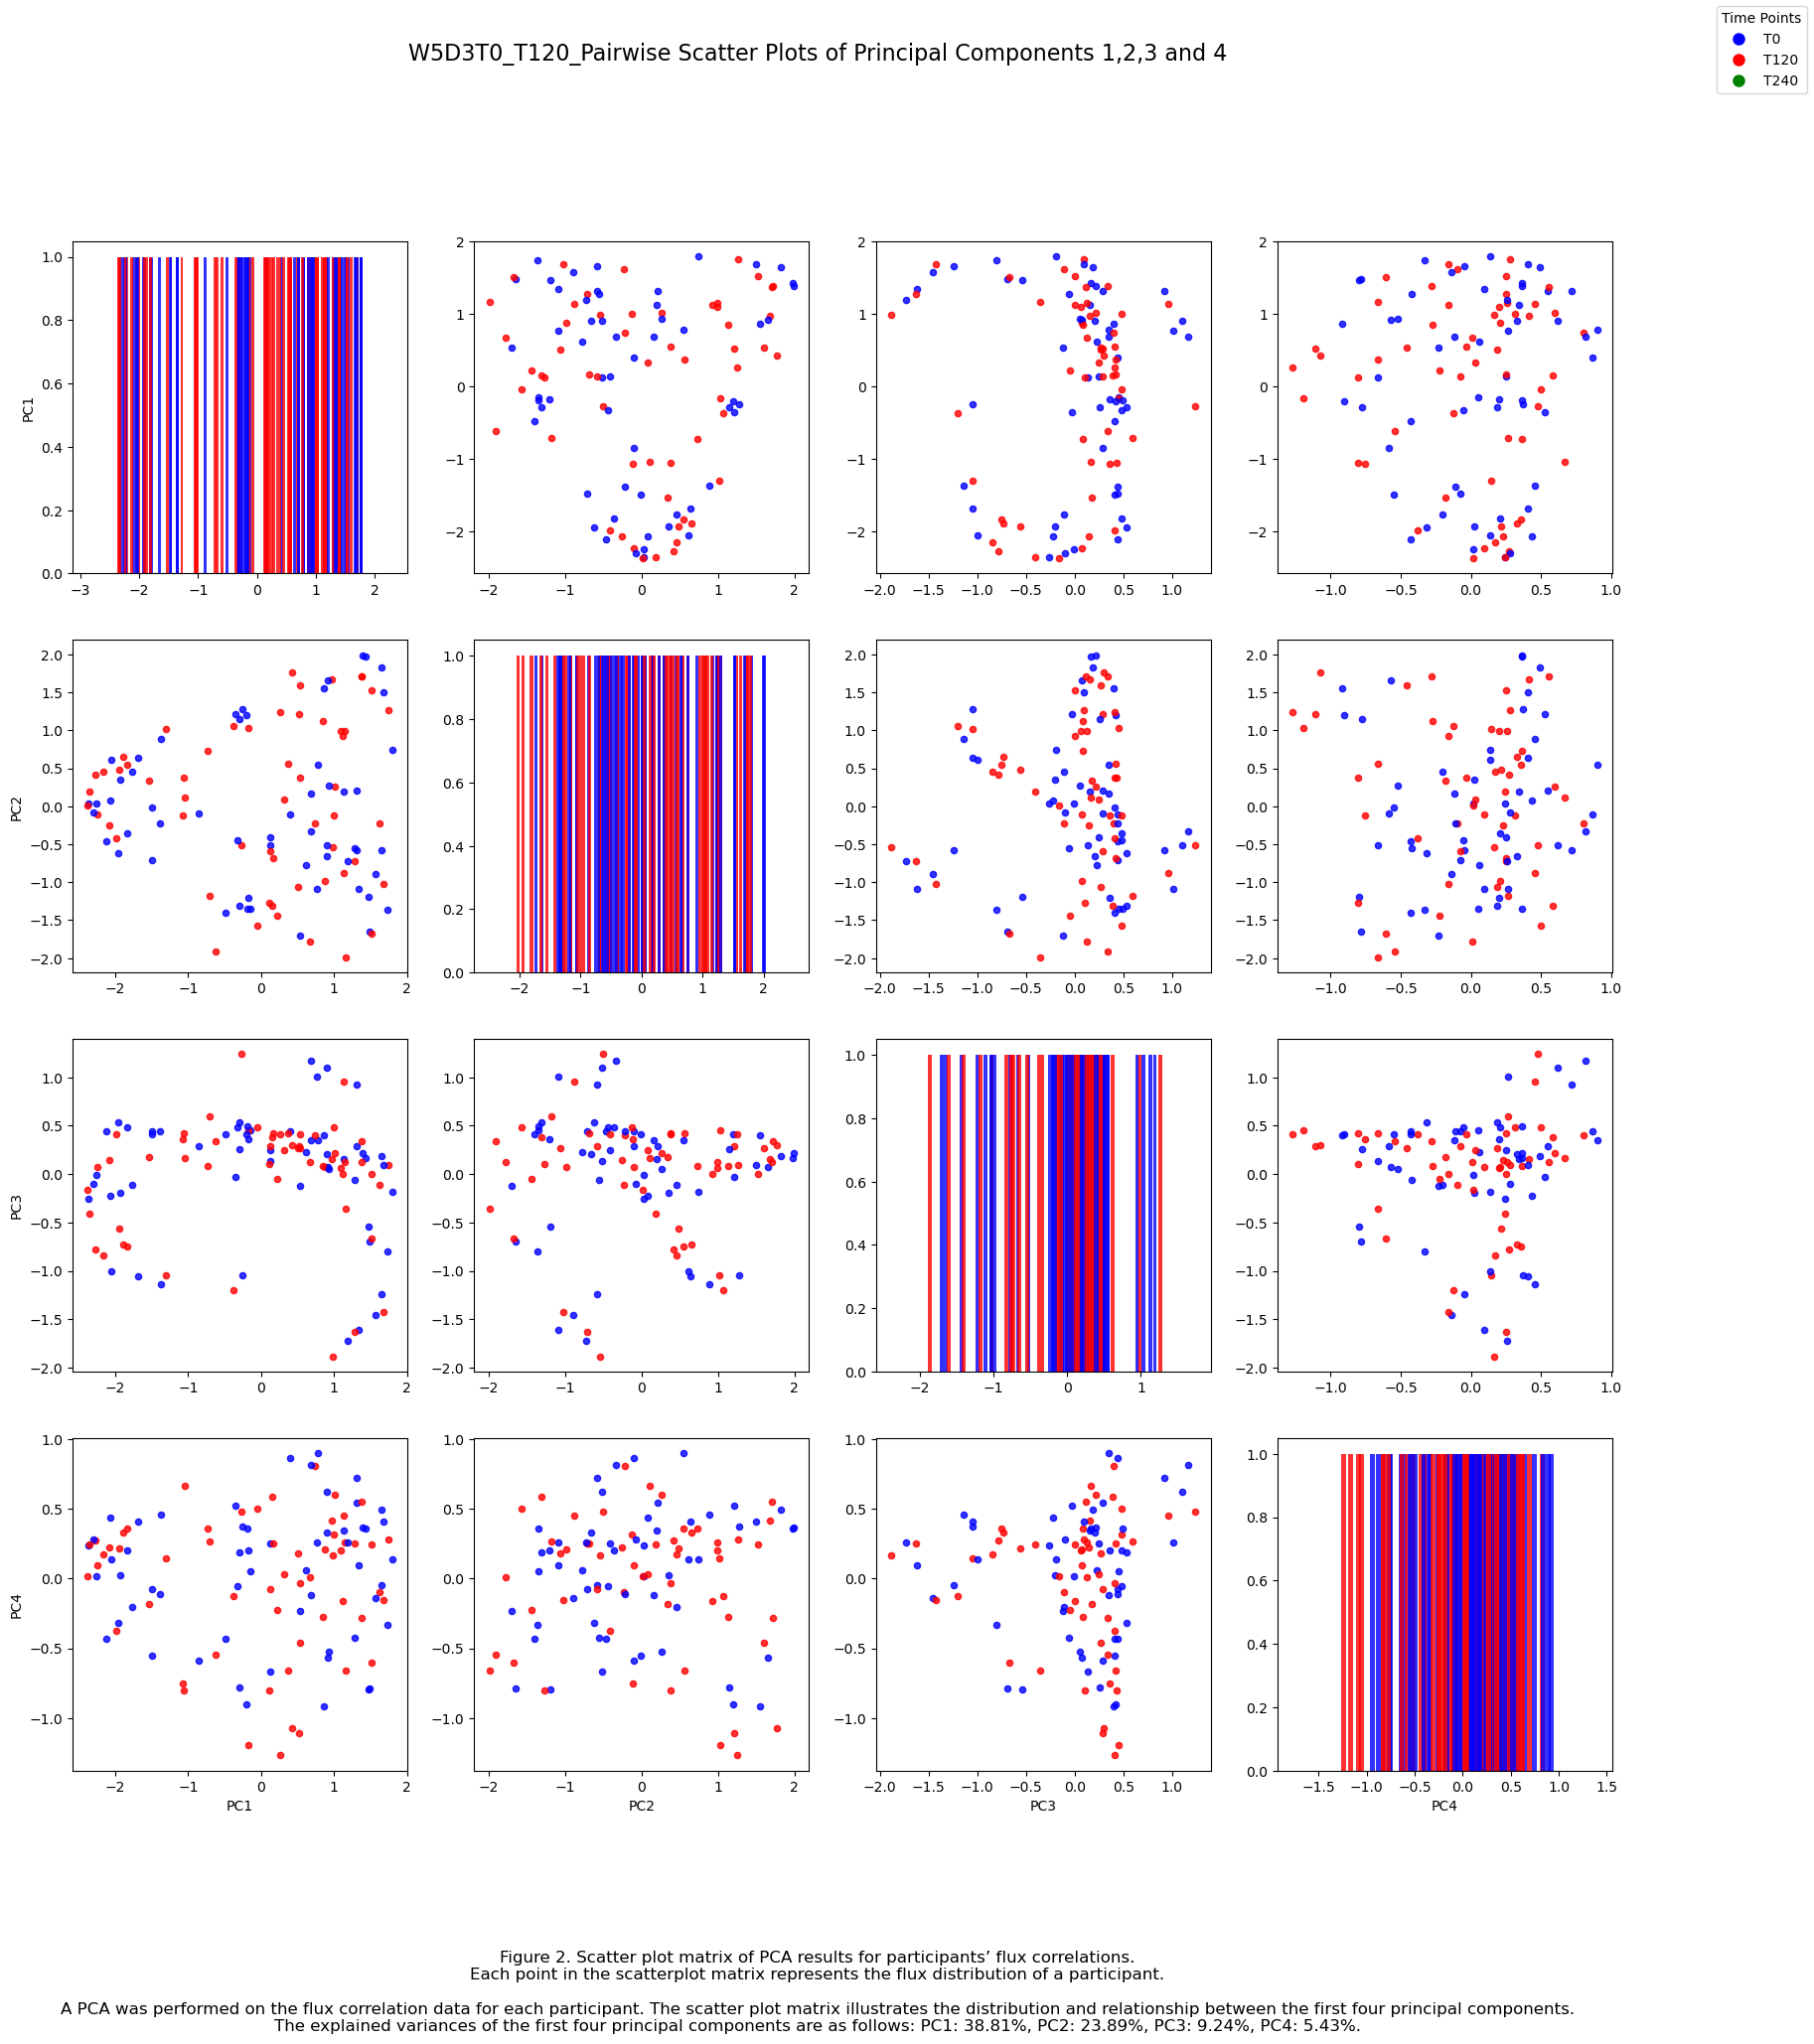

In [2]:
# Set the file_ID for naming plots and saved figures
file_ID = 'W5D3T0_T120'
flxID= 'pw_flx2_5.csv'
# %% Load the context-specific models
directory_path = f'/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/{file_ID}'
context_specific_models = []
for filename in os.listdir(directory_path):
    if filename.endswith(".mat"):
        file_path = os.path.join(directory_path, filename)
        model = load_matlab_model(file_path)
        context_specific_models.append(model)

print(f"Loaded {len(context_specific_models)} models.")

path_ref = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/Recon3D.mat'
ref_model = load_matlab_model(path_ref)

# Convert the list of models to a list of paths
file_paths = [Path(os.path.join(directory_path, f)) for f in os.listdir(directory_path) if f.endswith(".mat")]

# Call the load_library function to get the flux dataframe
reactions_matrix, metabolite_matrix, gene_matrix, flx_df = load_library(file_paths, ref_model, sampling=False, FBA=True)
#rxn, met, gen, graphlist, flx = load_library(file_paths, ref_model, sampling= False, FBA= True)


# Check the flux data frame
print(flx_df.head())

#%% Perform flux correlation between pairs of models
pw_flx = flux_DM(flx_df)
pw_flx
# Save pw_flx1 as a CSV file
pw_flx.to_csv(f'{flxID}', index=False)

import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your pw_flx3 data from the CSV file
pw_flxload = pd.read_csv(f'{flxID}')

# Extract sample labels (T0, T120, or T240) from the column names
labels = [col.split('T')[-1] for col in pw_flxload.columns]


# Perform PCA
pca = PCA(n_components=3)
pcaData = pca.fit_transform(pw_flxload.T)  # Transpose to make samples as rows
print(pca.explained_variance_ratio_)

title_font = {
    'weight': 'medium',
    'size': 12,
}
axis_font = {
    'weight': 'normal',
    'size': 10,
}

# Color coding based on time points
colors = ['blue' if label == '0' else 'red' if label == '120' else 'green' for label in labels]

# Plot PCA scatter plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
for i in range(len(labels)):
    xs = pcaData[i, 0]
    ys = pcaData[i, 1]
    plt.scatter(xs, ys, s=20, marker='o', color=colors[i], alpha=0.8)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='T240')]
plt.legend(handles=handles, title="Time Points")

plt.title(f'{file_ID}_PCA for Flux Correlation Between PBMC Models (PC1 vs PC2)', title_font)
plt.xlabel('PC1: {:.1%}'.format(pca.explained_variance_ratio_[0]), axis_font)
plt.ylabel('PC2: {:.1%}'.format(pca.explained_variance_ratio_[1]), axis_font)
plt.figtext(0.5, -0.23, (f'Figure 1. PCA results for the flux correlations.\n Each point in the scatterplot represents a participant\'s context-specific model.\n\n The explained variances of the first and second principal components were {pca.explained_variance_ratio_[0]*100:.2f}% and {pca.explained_variance_ratio_[1]*100:.2f}%, respectively, resulting in a combined variance of {((pca.explained_variance_ratio_[0]*100)+(pca.explained_variance_ratio_[1]*100)):.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'{file_ID}_fig.1_PCA_for_Flux_Correlation.png', dpi=1000)

####################### Create a 4x4 plot matrix of PC1, PC2, PC3, and PC4
# Perform PCA
pca = PCA(n_components=4)
pcaData = pca.fit_transform(pw_flxload.T)
explained_variance = pca.explained_variance_ratio_

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

pc_labels = ['PC1', 'PC2', 'PC3', 'PC4']
components = [pcaData[:, 0], pcaData[:, 1], pcaData[:, 2], pcaData[:, 3]]

for i in range(4):
    for j in range(4):
        if i == j:
            for k, c in zip(components[i], colors):
                axs[i, j].hist(k, bins=20, color=c, alpha=0.8)
        else:
            for x, y, c in zip(components[j], components[i], colors):
                axs[i, j].scatter(x, y, color=c, s=20, alpha=0.8)
        if i == 3:
            axs[i, j].set_xlabel(pc_labels[j])
        if j == 0:
            axs[i, j].set_ylabel(pc_labels[i])

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='T240')]
fig.legend(handles=handles, title="Time Points", loc='upper right')

plt.suptitle(f'{file_ID}_Pairwise Scatter Plots of Principal Components 1,2,3 and 4', fontsize=16, weight='medium')
plt.figtext(0.5, -0.02, (f'Figure 2. Scatter plot matrix of PCA results for participants’ flux correlations.\n'
                         f'Each point in the scatterplot matrix represents the flux distribution of a participant.\n\n'
                         f'A PCA was performed on the flux correlation data for each participant. The scatter plot matrix illustrates the distribution and relationship between the first four principal components.\n'
                         f'The explained variances of the first four principal components are as follows: PC1: {explained_variance[0]*100:.2f}%, PC2: {explained_variance[1]*100:.2f}%, PC3: {explained_variance[2]*100:.2f}%, PC4: {explained_variance[3]*100:.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)

plt.savefig(f'{file_ID}_fig.2_Pairwise_Scatter_Plots_of_PC1_to_PC4.png', dpi=1000)
plt.show()


# W5D3T0_T240

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in mod

Loaded 112 models.


This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model Recon3D. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT001_W5D3T0
FBA...
<Solution 1000.000 at 0x1d17750d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT140_W5D3T0
FBA...
<Solution 1000.000 at 0x1f1398dd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT059_W5D3T0
FBA...
<Solution 1000.000 at 0x1f27e9dd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT118_W5D3T0
FBA...
<Solution 1000.000 at 0x1f16857d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT008_W5D3T240
FBA...
<Solution 1000.000 at 0x1f2fc1150>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT045_W5D3T0
FBA...
<Solution 1000.000 at 0x1d525ef10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT133_W5D3T0
FBA...
<Solution 1000.000 at 0x1d8699250>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT027_W5D3T0
FBA...
<Solution 1000.000 at 0x1dbbc3690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT010_W5D3T0
FBA...
<Solution 1000.000 at 0x1dd02b550>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT148_W5D3T0
FBA...
<Solution 944.444 at 0x1df7a5d10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT077_W5D3T0
FBA...
<Solution 1000.000 at 0x1e3eb3590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT015_W5D3T0
FBA...
<Solution 1000.000 at 0x265975790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT022_W5D3T0
FBA...
<Solution 1000.000 at 0x2661d4910>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT148_W5D3T240
FBA...
<Solution 1000.000 at 0x268766a90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT033_W5D3T0
FBA...
<Solution 1000.000 at 0x269ee7810>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT145_W5D3T0
FBA...
<Solution 1000.000 at 0x26b7cbad0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT051_W5D3T0
FBA...
<Solution 1000.000 at 0x26ce7e610>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT066_W5D3T0
FBA...
<Solution 1000.000 at 0x26e4d7310>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT018_W5D3T0
FBA...
<Solution 1000.000 at 0x26fcd0e90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT043_W5D3T240
FBA...
<Solution 1000.000 at 0x1e2a13010>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT044_W5D3T240
FBA...
<Solution 1000.000 at 0x1f06a44d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT133_W5D3T240
FBA...
<Solution 1000.000 at 0x26dcd1f90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT082_W5D3T0
FBA...
<Solution 1000.000 at 0x1f3052dd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT034_W5D3T0
FBA...
<Solution 1000.000 at 0x26c129650>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT120_W5D3T0
FBA...
<Solution 1000.000 at 0x1deeb3090>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT051_W5D3T240
FBA...
<Solution 1000.000 at 0x1e8407b10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT056_W5D3T0
FBA...
<Solution 1000.000 at 0x1ef7dd110>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT056_W5D3T240
FBA...
<Solution 1000.000 at 0x269c42cd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT035_W5D3T240
FBA...
<Solution 1000.000 at 0x1d1cd5010>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT060_W5D3T240
FBA...
<Solution 1000.000 at 0x1cbe43650>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT145_W5D3T240
FBA...
<Solution 1000.000 at 0x1d2c69710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT067_W5D3T240
FBA...
<Solution 1000.000 at 0x271cec410>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT070_W5D3T0
FBA...
<Solution 1000.000 at 0x27343ae50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT106_W5D3T0
FBA...
<Solution 1000.000 at 0x274a5a3d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT131_W5D3T0
FBA...
<Solution 1000.000 at 0x2760633d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT025_W5D3T0
FBA...
<Solution 1000.000 at 0x2778fc690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT027_W5D3T240
FBA...
<Solution 1000.000 at 0x278f7fb10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT150_W5D3T240
FBA...
<Solution 1000.000 at 0x1f0bd7f90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT020_W5D3T240
FBA...
<Solution 1000.000 at 0x26b818390>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT057_W5D3T240
FBA...
<Solution 1000.000 at 0x1d9fa76d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT002_W5D3T240
FBA...
<Solution 1000.000 at 0x26789c910>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT120_W5D3T240
FBA...
<Solution 1000.000 at 0x1d5ff1690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT020_W5D3T0
FBA...
<Solution 1000.000 at 0x1e2a3e710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT017_W5D3T0
FBA...
<Solution 1000.000 at 0x27165c6d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT103_W5D3T0
FBA...
<Solution 1000.000 at 0x271cac250>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT132_W5D3T240
FBA...
<Solution 1000.000 at 0x1e61e6450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT045_W5D3T240
FBA...
<Solution 1000.000 at 0x271b0b690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT010_W5D3T240
FBA...
<Solution 1000.000 at 0x2725a6150>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT017_W5D3T240
FBA...
<Solution 1000.000 at 0x27a9cb710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT103_W5D3T240
FBA...
<Solution 1000.000 at 0x27c09ff10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT021_W5D3T240
FBA...
<Solution 1000.000 at 0x27d910e50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT066_W5D3T240
FBA...
<Solution 1000.000 at 0x27ef85a90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT033_W5D3T240
FBA...
<Solution 1000.000 at 0x28086f650>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT034_W5D3T240
FBA...
<Solution 1000.000 at 0x281e8e890>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT143_W5D3T240
FBA...
<Solution 1000.000 at 0x2836815d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT006_W5D3T0
FBA...
<Solution 1000.000 at 0x2811228d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT031_W5D3T0
FBA...
<Solution 1000.000 at 0x282fa87d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT064_W5D3T0
FBA...
<Solution 1000.000 at 0x26ce85e10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT053_W5D3T0
FBA...
<Solution 1000.000 at 0x1f2a41dd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT008_W5D3T0
FBA...
<Solution 1000.000 at 0x276be8290>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT076_W5D3T0
FBA...
<Solution 1000.000 at 0x2716fe990>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT015_W5D3T240
FBA...
<Solution 1000.000 at 0x27ec7ff90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT137_W5D3T240
FBA...
<Solution 1000.000 at 0x1d2cae590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT023_W5D3T0
FBA...
<Solution 1000.000 at 0x27a4f3590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT137_W5D3T0
FBA...
<Solution 1000.000 at 0x27a3110d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT067_W5D3T0
FBA...
<Solution 1000.000 at 0x26d5e8cd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT106_W5D3T240
FBA...
<Solution 1000.000 at 0x27b72d390>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT023_W5D3T240
FBA...
<Solution 1000.000 at 0x2848bf310>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT076_W5D3T240
FBA...
<Solution 1000.000 at 0x285f6c0d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT114_W5D3T240
FBA...
<Solution 1000.000 at 0x287658310>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT084_W5D3T0
FBA...
<Solution 1000.000 at 0x288e06cd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT146_W5D3T240
FBA...
<Solution 1000.000 at 0x28a514a90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT031_W5D3T240
FBA...
<Solution 1000.000 at 0x28bd14cd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT064_W5D3T240
FBA...
<Solution 1000.000 at 0x28d358a90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT131_W5D3T240
FBA...
<Solution 1000.000 at 0x2853add50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT114_W5D3T0
FBA...
<Solution 1000.000 at 0x1de644110>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT046_W5D3T240
FBA...
<Solution 1000.000 at 0x278254b10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT013_W5D3T240
FBA...
<Solution 1000.000 at 0x1efe60210>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT123_W5D3T0
FBA...
<Solution 1000.000 at 0x1dae49d90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT001_W5D3T240
FBA...
<Solution 1000.000 at 0x281e85650>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT123_W5D3T240
FBA...
<Solution 1000.000 at 0x1e2842590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT053_W5D3T240
FBA...
<Solution 1000.000 at 0x278623610>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT006_W5D3T240
FBA...
<Solution 1000.000 at 0x2883cc510>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT090_W5D3T0
FBA...
<Solution 1000.000 at 0x27ceabf10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT140_W5D3T240
FBA...
<Solution 1000.000 at 0x281756450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT150_W5D3T0
FBA...
<Solution 1000.000 at 0x2827c5a10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT044_W5D3T0
FBA...
<Solution 1000.000 at 0x28e4ccc10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT132_W5D3T0
FBA...
<Solution 1000.000 at 0x28fb46710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT077_W5D3T240
FBA...
<Solution 1000.000 at 0x2911e9790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT022_W5D3T240
FBA...
<Solution 1000.000 at 0x29298d010>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT152_W5D3T240
FBA...
<Solution 1000.000 at 0x2940cae10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT070_W5D3T240
FBA...
<Solution 1000.000 at 0x2955a71d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT025_W5D3T240
FBA...
<Solution 1000.000 at 0x296d46510>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT043_W5D3T0
FBA...
<Solution 1000.000 at 0x2936698d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT082_W5D3T240
FBA...
<Solution 1000.000 at 0x26f3402d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT021_W5D3T0
FBA...
<Solution 1000.000 at 0x27b64c950>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT118_W5D3T240
FBA...
<Solution 1000.000 at 0x278f54410>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT129_W5D3T0
FBA...
<Solution 1000.000 at 0x1f0c92990>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT090_W5D3T240
FBA...
<Solution 1000.000 at 0x28b5e3210>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT059_W5D3T240
FBA...
<Solution 1000.000 at 0x29842f650>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT129_W5D3T240
FBA...
<Solution 1000.000 at 0x294c153d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT146_W5D3T0
FBA...
<Solution 1000.000 at 0x2889baf50>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT035_W5D3T0
FBA...
<Solution 1000.000 at 0x2929392d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT002_W5D3T0
FBA...
<Solution 1000.000 at 0x294db3fd0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT057_W5D3T0
FBA...
<Solution 1000.000 at 0x2829154d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT060_W5D3T0
FBA...
<Solution 1000.000 at 0x28d977c50>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT084_W5D3T240
FBA...
<Solution 1000.000 at 0x2999b2b90>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT143_W5D3T0
FBA...
<Solution 1000.000 at 0x29b088ed0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT152_W5D3T0
FBA...
<Solution 1000.000 at 0x29c743d50>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT046_W5D3T0
FBA...
<Solution 1000.000 at 0x29de8bc10>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT013_W5D3T0
FBA...
<Solution 1000.000 at 0x29f652c90>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT018_W5D3T240
FBA...
<Solution 1000.000 at 0x2a0cb5a10>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T0_T240/NT001_W5D3T0  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                                   
25HVITD3t                                                          NaN                                                                                                                                                                                                                   
COAtl                                                              NaN                                                                                    

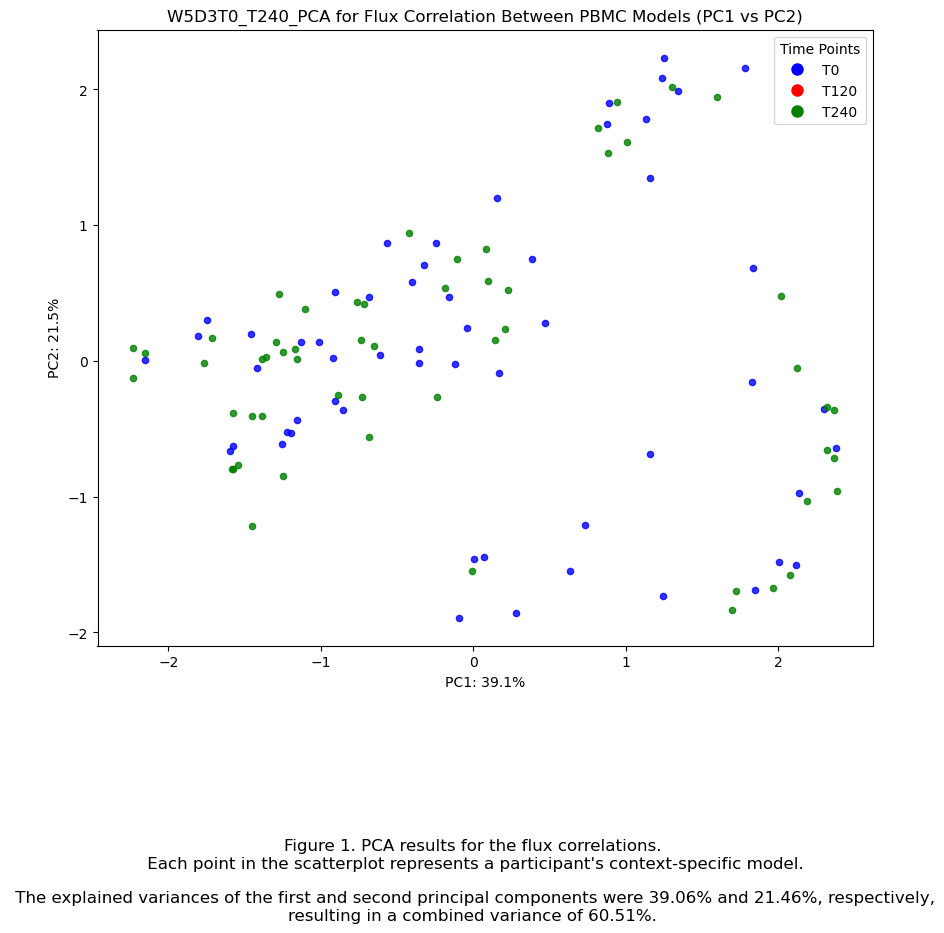

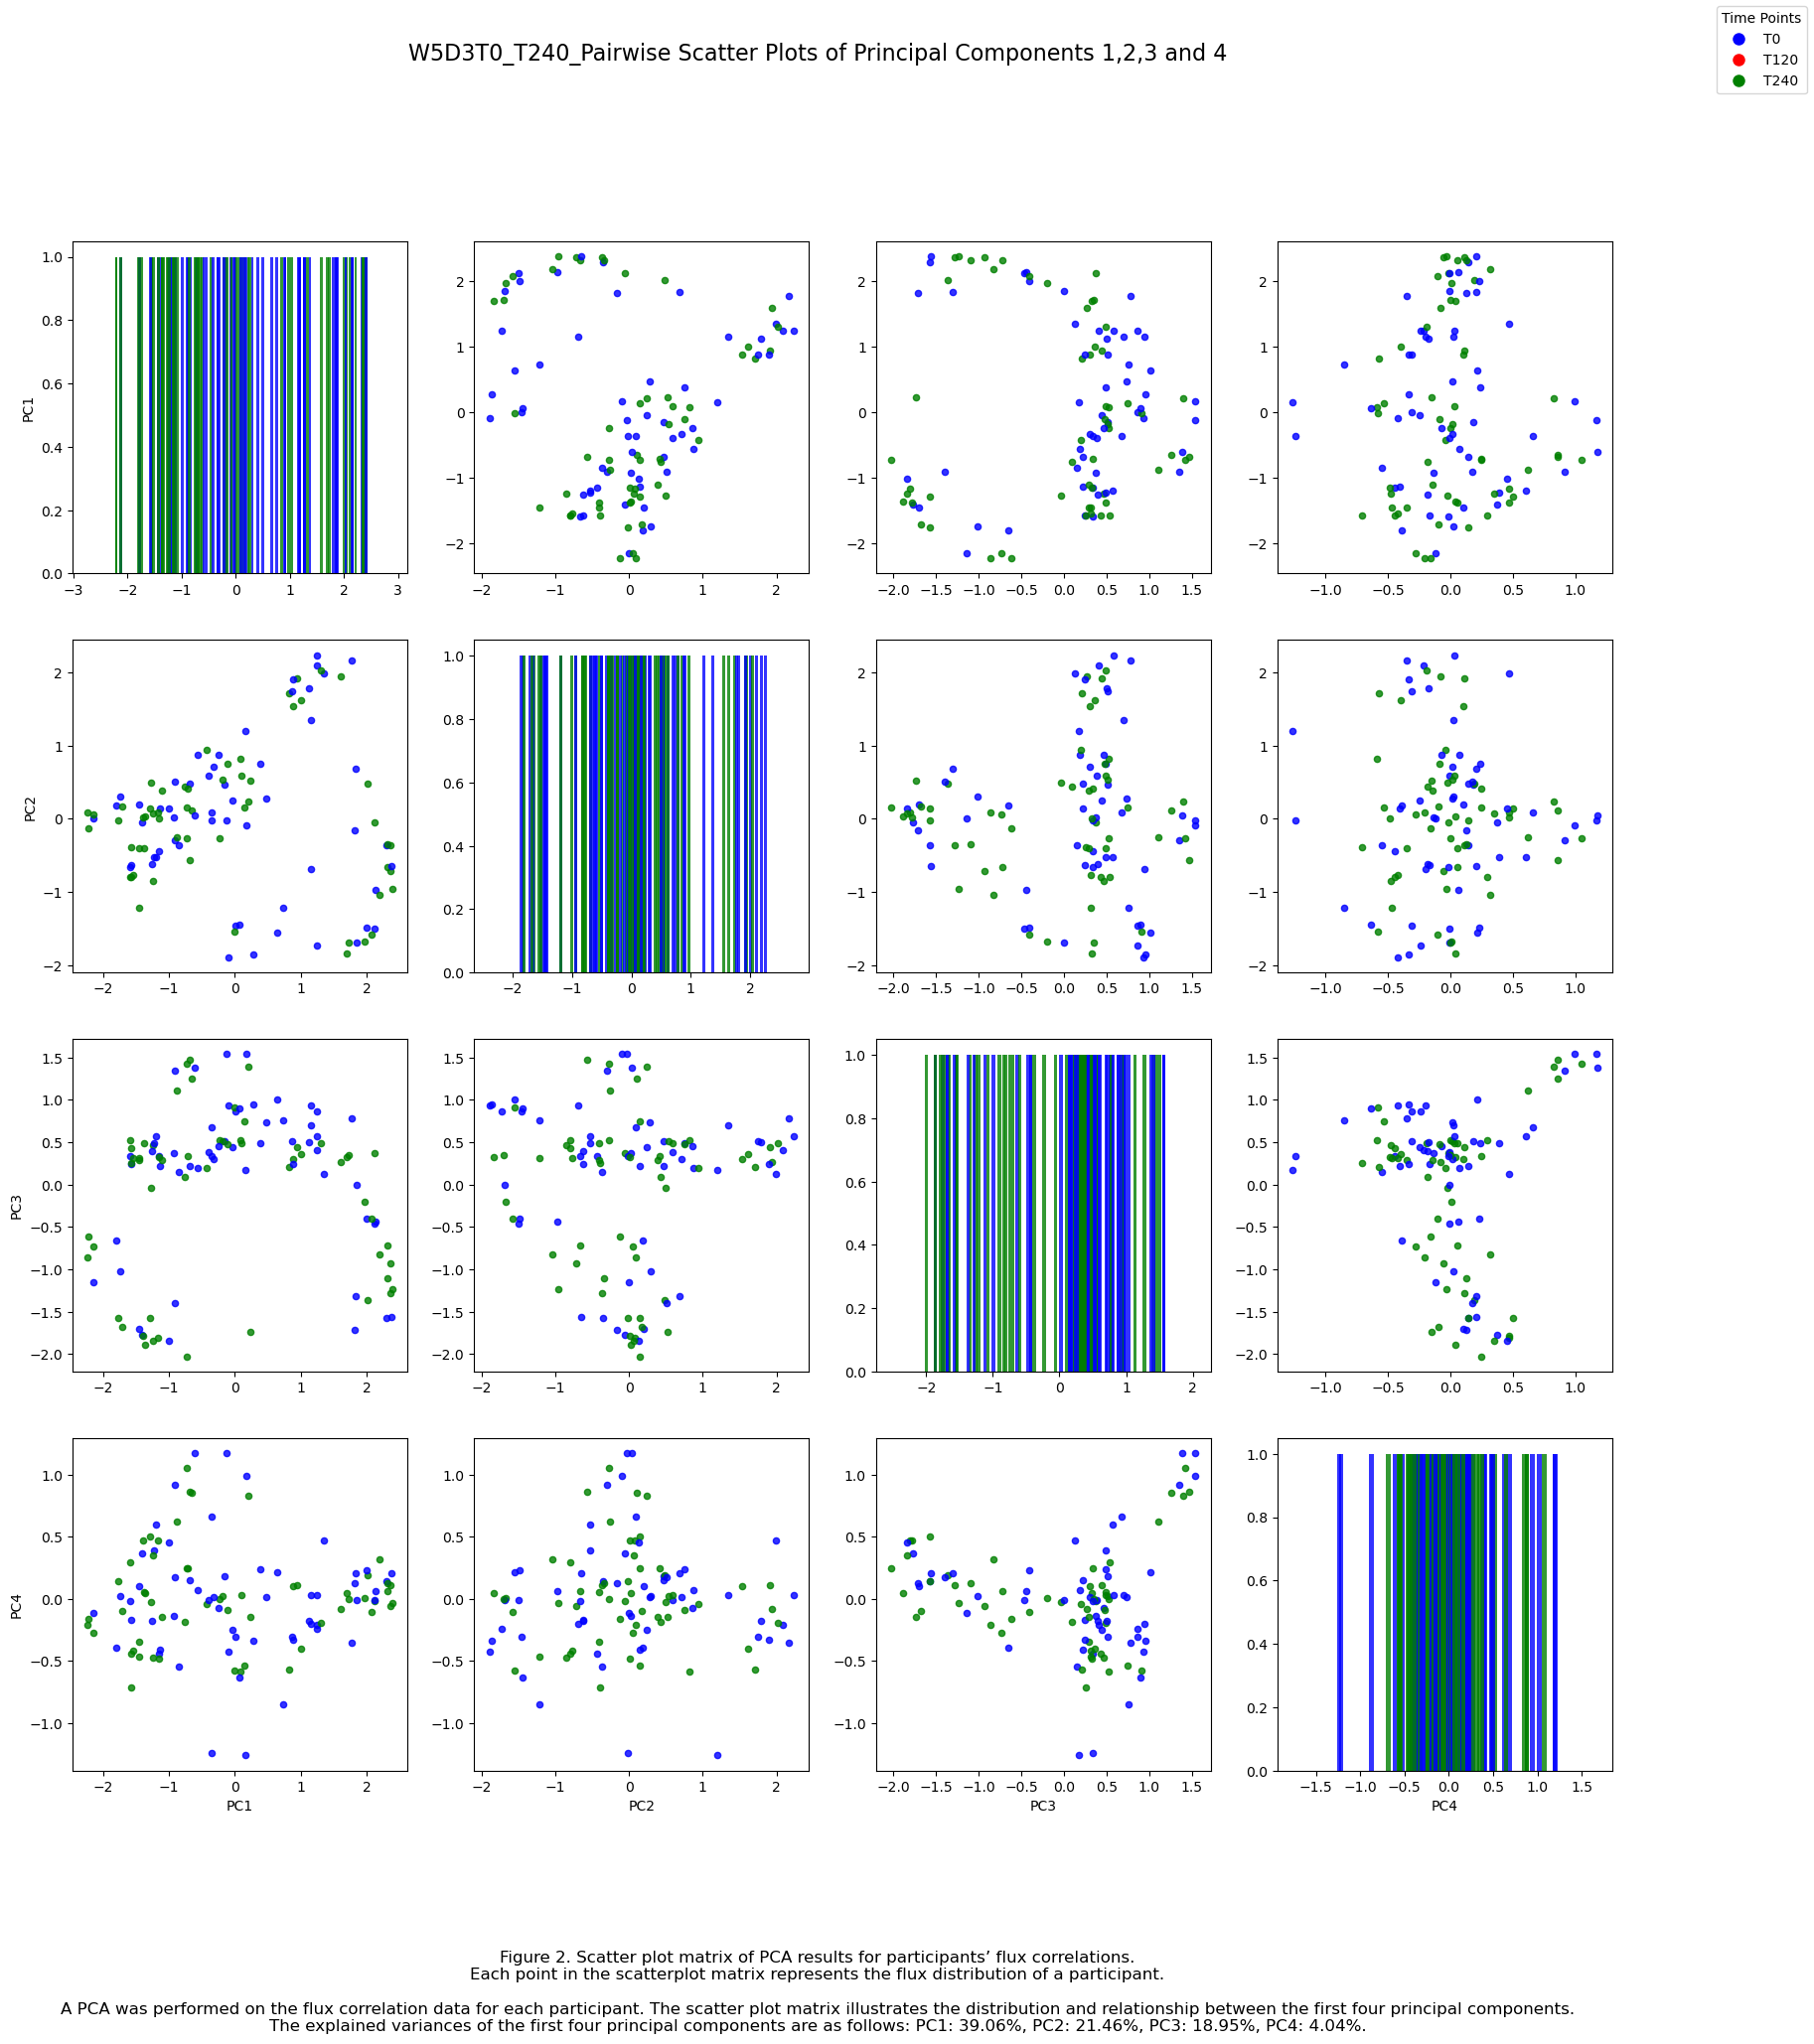

In [3]:
# Set the file_ID for naming plots and saved figures
file_ID = 'W5D3T0_T240'
flxID= 'pw_flx2_6.csv'
# %% Load the context-specific models
directory_path = f'/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/{file_ID}'
context_specific_models = []
for filename in os.listdir(directory_path):
    if filename.endswith(".mat"):
        file_path = os.path.join(directory_path, filename)
        model = load_matlab_model(file_path)
        context_specific_models.append(model)

print(f"Loaded {len(context_specific_models)} models.")

path_ref = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/Recon3D.mat'
ref_model = load_matlab_model(path_ref)

# Convert the list of models to a list of paths
file_paths = [Path(os.path.join(directory_path, f)) for f in os.listdir(directory_path) if f.endswith(".mat")]

# Call the load_library function to get the flux dataframe
reactions_matrix, metabolite_matrix, gene_matrix, flx_df = load_library(file_paths, ref_model, sampling=False, FBA=True)
#rxn, met, gen, graphlist, flx = load_library(file_paths, ref_model, sampling= False, FBA= True)


# Check the flux data frame
print(flx_df.head())

#%% Perform flux correlation between pairs of models
pw_flx = flux_DM(flx_df)
pw_flx
# Save pw_flx1 as a CSV file
pw_flx.to_csv(f'{flxID}', index=False)

import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your pw_flx3 data from the CSV file
pw_flxload = pd.read_csv(f'{flxID}')

# Extract sample labels (T0, T120, or T240) from the column names
labels = [col.split('T')[-1] for col in pw_flxload.columns]


# Perform PCA
pca = PCA(n_components=3)
pcaData = pca.fit_transform(pw_flxload.T)  # Transpose to make samples as rows
print(pca.explained_variance_ratio_)

title_font = {
    'weight': 'medium',
    'size': 12,
}
axis_font = {
    'weight': 'normal',
    'size': 10,
}

# Color coding based on time points
colors = ['blue' if label == '0' else 'red' if label == '120' else 'green' for label in labels]

# Plot PCA scatter plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
for i in range(len(labels)):
    xs = pcaData[i, 0]
    ys = pcaData[i, 1]
    plt.scatter(xs, ys, s=20, marker='o', color=colors[i], alpha=0.8)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='T240')]
plt.legend(handles=handles, title="Time Points")

plt.title(f'{file_ID}_PCA for Flux Correlation Between PBMC Models (PC1 vs PC2)', title_font)
plt.xlabel('PC1: {:.1%}'.format(pca.explained_variance_ratio_[0]), axis_font)
plt.ylabel('PC2: {:.1%}'.format(pca.explained_variance_ratio_[1]), axis_font)
plt.figtext(0.5, -0.23, (f'Figure 1. PCA results for the flux correlations.\n Each point in the scatterplot represents a participant\'s context-specific model.\n\n The explained variances of the first and second principal components were {pca.explained_variance_ratio_[0]*100:.2f}% and {pca.explained_variance_ratio_[1]*100:.2f}%, respectively, resulting in a combined variance of {((pca.explained_variance_ratio_[0]*100)+(pca.explained_variance_ratio_[1]*100)):.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'{file_ID}_fig.1_PCA_for_Flux_Correlation.png', dpi=1000)

####################### Create a 4x4 plot matrix of PC1, PC2, PC3, and PC4
# Perform PCA
pca = PCA(n_components=4)
pcaData = pca.fit_transform(pw_flxload.T)
explained_variance = pca.explained_variance_ratio_

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

pc_labels = ['PC1', 'PC2', 'PC3', 'PC4']
components = [pcaData[:, 0], pcaData[:, 1], pcaData[:, 2], pcaData[:, 3]]

for i in range(4):
    for j in range(4):
        if i == j:
            for k, c in zip(components[i], colors):
                axs[i, j].hist(k, bins=20, color=c, alpha=0.8)
        else:
            for x, y, c in zip(components[j], components[i], colors):
                axs[i, j].scatter(x, y, color=c, s=20, alpha=0.8)
        if i == 3:
            axs[i, j].set_xlabel(pc_labels[j])
        if j == 0:
            axs[i, j].set_ylabel(pc_labels[i])

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='T240')]
fig.legend(handles=handles, title="Time Points", loc='upper right')

plt.suptitle(f'{file_ID}_Pairwise Scatter Plots of Principal Components 1,2,3 and 4', fontsize=16, weight='medium')
plt.figtext(0.5, -0.02, (f'Figure 2. Scatter plot matrix of PCA results for participants’ flux correlations.\n'
                         f'Each point in the scatterplot matrix represents the flux distribution of a participant.\n\n'
                         f'A PCA was performed on the flux correlation data for each participant. The scatter plot matrix illustrates the distribution and relationship between the first four principal components.\n'
                         f'The explained variances of the first four principal components are as follows: PC1: {explained_variance[0]*100:.2f}%, PC2: {explained_variance[1]*100:.2f}%, PC3: {explained_variance[2]*100:.2f}%, PC4: {explained_variance[3]*100:.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)

plt.savefig(f'{file_ID}_fig.2_Pairwise_Scatter_Plots_of_PC1_to_PC4.png', dpi=1000)
plt.show()


# W5D3T120_T240

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in mod

Loaded 112 models.


This model seems to have metCharge instead of metCharges field. Will use metCharge for what metCharges represents.
No defined compartments in model Recon3D. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT008_W5D3T120
FBA...
<Solution 1000.000 at 0x191400710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT008_W5D3T240
FBA...
<Solution 1000.000 at 0x1924905d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT148_W5D3T240
FBA...
<Solution 1000.000 at 0x197d0fb10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT148_W5D3T120
FBA...
<Solution 1000.000 at 0x19aaedd10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT043_W5D3T240
FBA...
<Solution 1000.000 at 0x19df6a210>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT020_W5D3T120
FBA...
<Solution 1000.000 at 0x1a188bf90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT044_W5D3T240
FBA...
<Solution 1000.000 at 0x1a62b9210>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT150_W5D3T120
FBA...
<Solution 1000.000 at 0x1adda8350>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT027_W5D3T120
FBA...
<Solution 1000.000 at 0x1b919bf90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT133_W5D3T240
FBA...
<Solution 1000.000 at 0x194b853d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT067_W5D3T120
FBA...
<Solution 1000.000 at 0x1ca794290>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT145_W5D3T120
FBA...
<Solution 1000.000 at 0x1cc5a1590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT051_W5D3T240
FBA...
<Solution 1000.000 at 0x1cf05ce90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT060_W5D3T120
FBA...
<Solution 1000.000 at 0x1cde7e3d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT035_W5D3T120
FBA...
<Solution 966.667 at 0x1d0c026d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT056_W5D3T240
FBA...
<Solution 1000.000 at 0x199f643d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT056_W5D3T120
FBA...
<Solution 1000.000 at 0x1b99b0610>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT035_W5D3T240
FBA...
<Solution 1000.000 at 0x1c02aa3d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT060_W5D3T240
FBA...
<Solution 1000.000 at 0x1c80d5b50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT051_W5D3T120
FBA...
<Solution 1000.000 at 0x25c833850>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT145_W5D3T240
FBA...
<Solution 1000.000 at 0x25e95ad10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT067_W5D3T240
FBA...
<Solution 1000.000 at 0x26139f0d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT133_W5D3T120
FBA...
<Solution 1000.000 at 0x263018b10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT027_W5D3T240
FBA...
<Solution 1000.000 at 0x26495b7d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT150_W5D3T240
FBA...
<Solution 1000.000 at 0x2ab1afbd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT044_W5D3T120
FBA...
<Solution 1000.000 at 0x2ac7b7050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT020_W5D3T240
FBA...
<Solution 1000.000 at 0x2adf7cbd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT043_W5D3T120
FBA...
<Solution 1000.000 at 0x2af6b1910>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT143_W5D3T120
FBA...
<Solution 1000.000 at 0x2b0dc9750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT057_W5D3T240
FBA...
<Solution 1000.000 at 0x2b251ff10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT002_W5D3T240
FBA...
<Solution 1000.000 at 0x25fa4fa10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT120_W5D3T240
FBA...
<Solution 1000.000 at 0x19d45b490>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT034_W5D3T120
FBA...
<Solution 1000.000 at 0x1ca697250>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT033_W5D3T120
FBA...
<Solution 1000.000 at 0x1a532a5d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT066_W5D3T120
FBA...
<Solution 1000.000 at 0x1d163f2d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT132_W5D3T240
FBA...
<Solution 1000.000 at 0x25e399c50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT045_W5D3T240
FBA...
<Solution 1000.000 at 0x26583bf90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT010_W5D3T240
FBA...
<Solution 1000.000 at 0x1ccb84a90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT021_W5D3T120
FBA...
<Solution 1000.000 at 0x1b4e0f110>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT017_W5D3T240
FBA...
<Solution 1000.000 at 0x25f606190>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT103_W5D3T120
FBA...
<Solution 1000.000 at 0x1d138cb50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT103_W5D3T240
FBA...
<Solution 1000.000 at 0x26392afd0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT017_W5D3T120
FBA...
<Solution 1000.000 at 0x2638bfc10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT021_W5D3T240
FBA...
<Solution 1000.000 at 0x25d4c9310>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT010_W5D3T120
FBA...
<Solution 1000.000 at 0x2b311b050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT045_W5D3T120
FBA...
<Solution 1000.000 at 0x2b5608f10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT132_W5D3T120
FBA...
<Solution 1000.000 at 0x2b6c95610>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT066_W5D3T240
FBA...
<Solution 1000.000 at 0x2b62a2210>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT033_W5D3T240
FBA...
<Solution 1000.000 at 0x2b8dc1690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT034_W5D3T240
FBA...
<Solution 1000.000 at 0x2bb2d0390>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT120_W5D3T120
FBA...
<Solution 1000.000 at 0x2bc8ae990>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT002_W5D3T120
FBA...
<Solution 1000.000 at 0x2bd142450>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT057_W5D3T120
FBA...
<Solution 1000.000 at 0x25f14c110>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT143_W5D3T240
FBA...
<Solution 1000.000 at 0x19d1f9c50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT064_W5D3T120
FBA...
<Solution 1000.000 at 0x1c88fa390>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT031_W5D3T120
FBA...
<Solution 1000.000 at 0x181483e50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT146_W5D3T120
FBA...
<Solution 1000.000 at 0x2b05b0650>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT114_W5D3T120
FBA...
<Solution 1000.000 at 0x1cf14ba50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT015_W5D3T240
FBA...
<Solution 1000.000 at 0x2ad6408d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT076_W5D3T120
FBA...
<Solution 1000.000 at 0x1bf65a8d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT023_W5D3T120
FBA...
<Solution 1000.000 at 0x2b0d50690>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT137_W5D3T240
FBA...
<Solution 1000.000 at 0x2aaeb2c90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT106_W5D3T120
FBA...
<Solution 1000.000 at 0x2aefbf0d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT106_W5D3T240
FBA...
<Solution 1000.000 at 0x19cb09790>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT137_W5D3T120
FBA...
<Solution 1000.000 at 0x2b5cb9210>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT023_W5D3T240
FBA...
<Solution 1000.000 at 0x2be8e0350>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT076_W5D3T240
FBA...
<Solution 1000.000 at 0x2bffcb410>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT015_W5D3T120
FBA...
<Solution 1000.000 at 0x2c17cf390>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT114_W5D3T240
FBA...
<Solution 1000.000 at 0x2c2e14850>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT146_W5D3T240
FBA...
<Solution 1000.000 at 0x2c45670d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT031_W5D3T240
FBA...
<Solution 1000.000 at 0x2c5d218d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT064_W5D3T240
FBA...
<Solution 1000.000 at 0x2c73a0490>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT025_W5D3T120
FBA...
<Solution 1000.000 at 0x2c8c1c110>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT070_W5D3T120
FBA...
<Solution 1000.000 at 0x2ca244710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT131_W5D3T240
FBA...
<Solution 1000.000 at 0x2c0a72b90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT046_W5D3T240
FBA...
<Solution 1000.000 at 0x198bfef90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT013_W5D3T240
FBA...
<Solution 1000.000 at 0x2ab99d150>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT152_W5D3T120
FBA...
<Solution 1000.000 at 0x1a35d3850>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT022_W5D3T120
FBA...
<Solution 1000.000 at 0x1ce2a5d90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT077_W5D3T120
FBA...
<Solution 1000.000 at 0x2bab3a8d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT140_W5D3T120
FBA...
<Solution 1000.000 at 0x1a8eeef10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT001_W5D3T240
FBA...
<Solution 1000.000 at 0x2bacd3050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT123_W5D3T240
FBA...
<Solution 1000.000 at 0x2c45d7a10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT053_W5D3T240
FBA...
<Solution 1000.000 at 0x2c1348d10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT006_W5D3T240
FBA...
<Solution 1000.000 at 0x2bf964e10>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT006_W5D3T120
FBA...
<Solution 1000.000 at 0x2c63f6490>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT053_W5D3T120
FBA...
<Solution 1000.000 at 0x2c21198d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT123_W5D3T120
FBA...
<Solution 1000.000 at 0x2c657d050>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT001_W5D3T120
FBA...
<Solution 1000.000 at 0x2c08af190>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT140_W5D3T240
FBA...
<Solution 1000.000 at 0x2cbfb6710>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT077_W5D3T240
FBA...
<Solution 1000.000 at 0x2cd617e50>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT022_W5D3T240
FBA...
<Solution 1000.000 at 0x2cedcc3d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT152_W5D3T240
FBA...
<Solution 1000.000 at 0x2d052f950>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT013_W5D3T120
FBA...
<Solution 1000.000 at 0x2d1d4aa90>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT046_W5D3T120
FBA...
<Solution 1000.000 at 0x2d25b9510>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT131_W5D3T120
FBA...
<Solution 1000.000 at 0x2d4a73590>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT070_W5D3T240
FBA...
<Solution 1000.000 at 0x2d5f43910>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT025_W5D3T240
FBA...
<Solution 1000.000 at 0x2cfc13110>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT082_W5D3T240
FBA...
<Solution 1000.000 at 0x25dafb750>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT129_W5D3T120
FBA...
<Solution 1000.000 at 0x2ba8f29d0>


No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e, g, i, l, m, n, r, x


Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT118_W5D3T240
FBA...
<Solution 1000.000 at 0x1a92a4f10>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT059_W5D3T120
FBA...
<Solution 1000.000 at 0x2b6b1f650>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT090_W5D3T240
FBA...
<Solution 1000.000 at 0x18e746710>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT090_W5D3T120
FBA...
<Solution 1000.000 at 0x2c7de27d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT059_W5D3T240
FBA...
<Solution 1000.000 at 0x2caa6bbd0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT118_W5D3T120
FBA...
<Solution 1000.000 at 0x2b6048c50>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT129_W5D3T240
FBA...
<Solution 1000.000 at 0x2c9e84c90>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT082_W5D3T120
FBA...
<Solution 1000.000 at 0x2d10978d0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT018_W5D3T120
FBA...
<Solution 1000.000 at 0x2c7b93a10>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT084_W5D3T240
FBA...
<Solution 1000.000 at 0x2ce53e350>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT084_W5D3T120
FBA...
<Solution 1000.000 at 0x2c99b6950>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

Loaded model /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT018_W5D3T240
FBA...
<Solution 1000.000 at 0x2cb17cad0>


/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  reactions_matrix[label] = rxns
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  metabolite_matrix[label] = mets
/var/folders/7p/k4md7y991l9dk8h7cfw4wtsw0000gn/T/ipykernel_418/3048953958.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor per

                     /Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/W5D3T120_T240/NT008_W5D3T120  \
24_25DHVITD3tm                                                     NaN                                                                                                                                                                                                                       
25HVITD3t                                                          NaN                                                                                                                                                                                                                       
COAtl                                                              NaN                                                                        

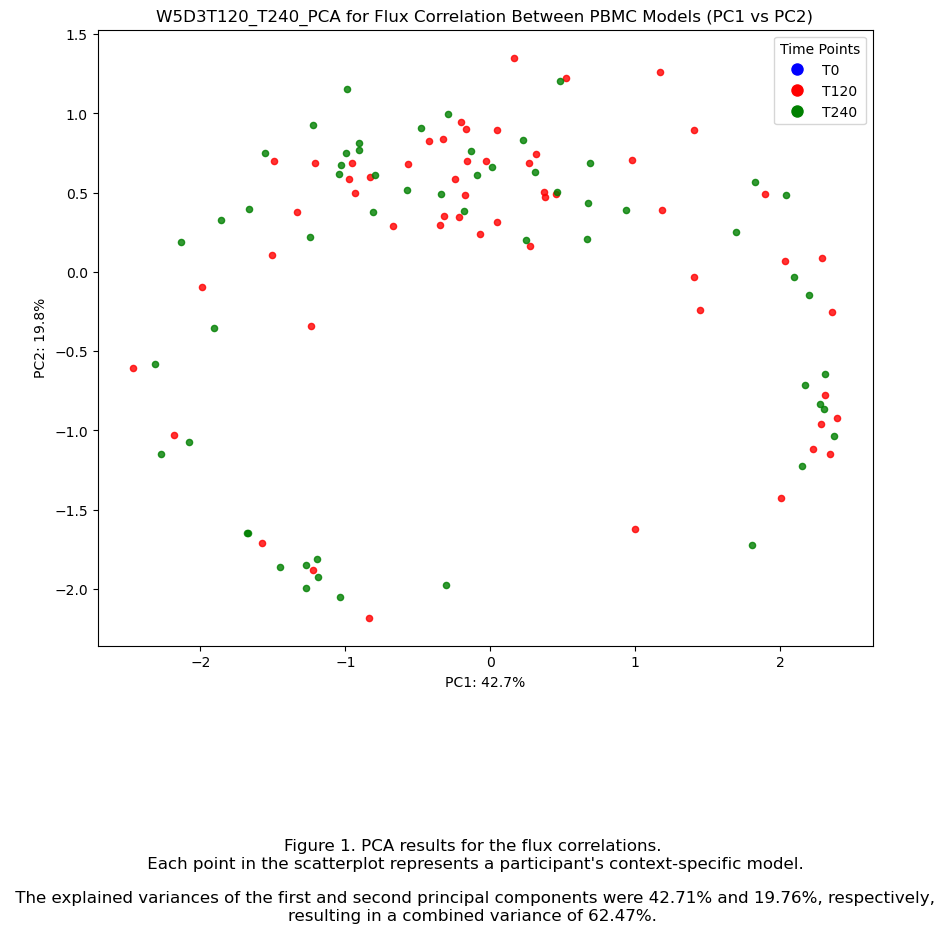

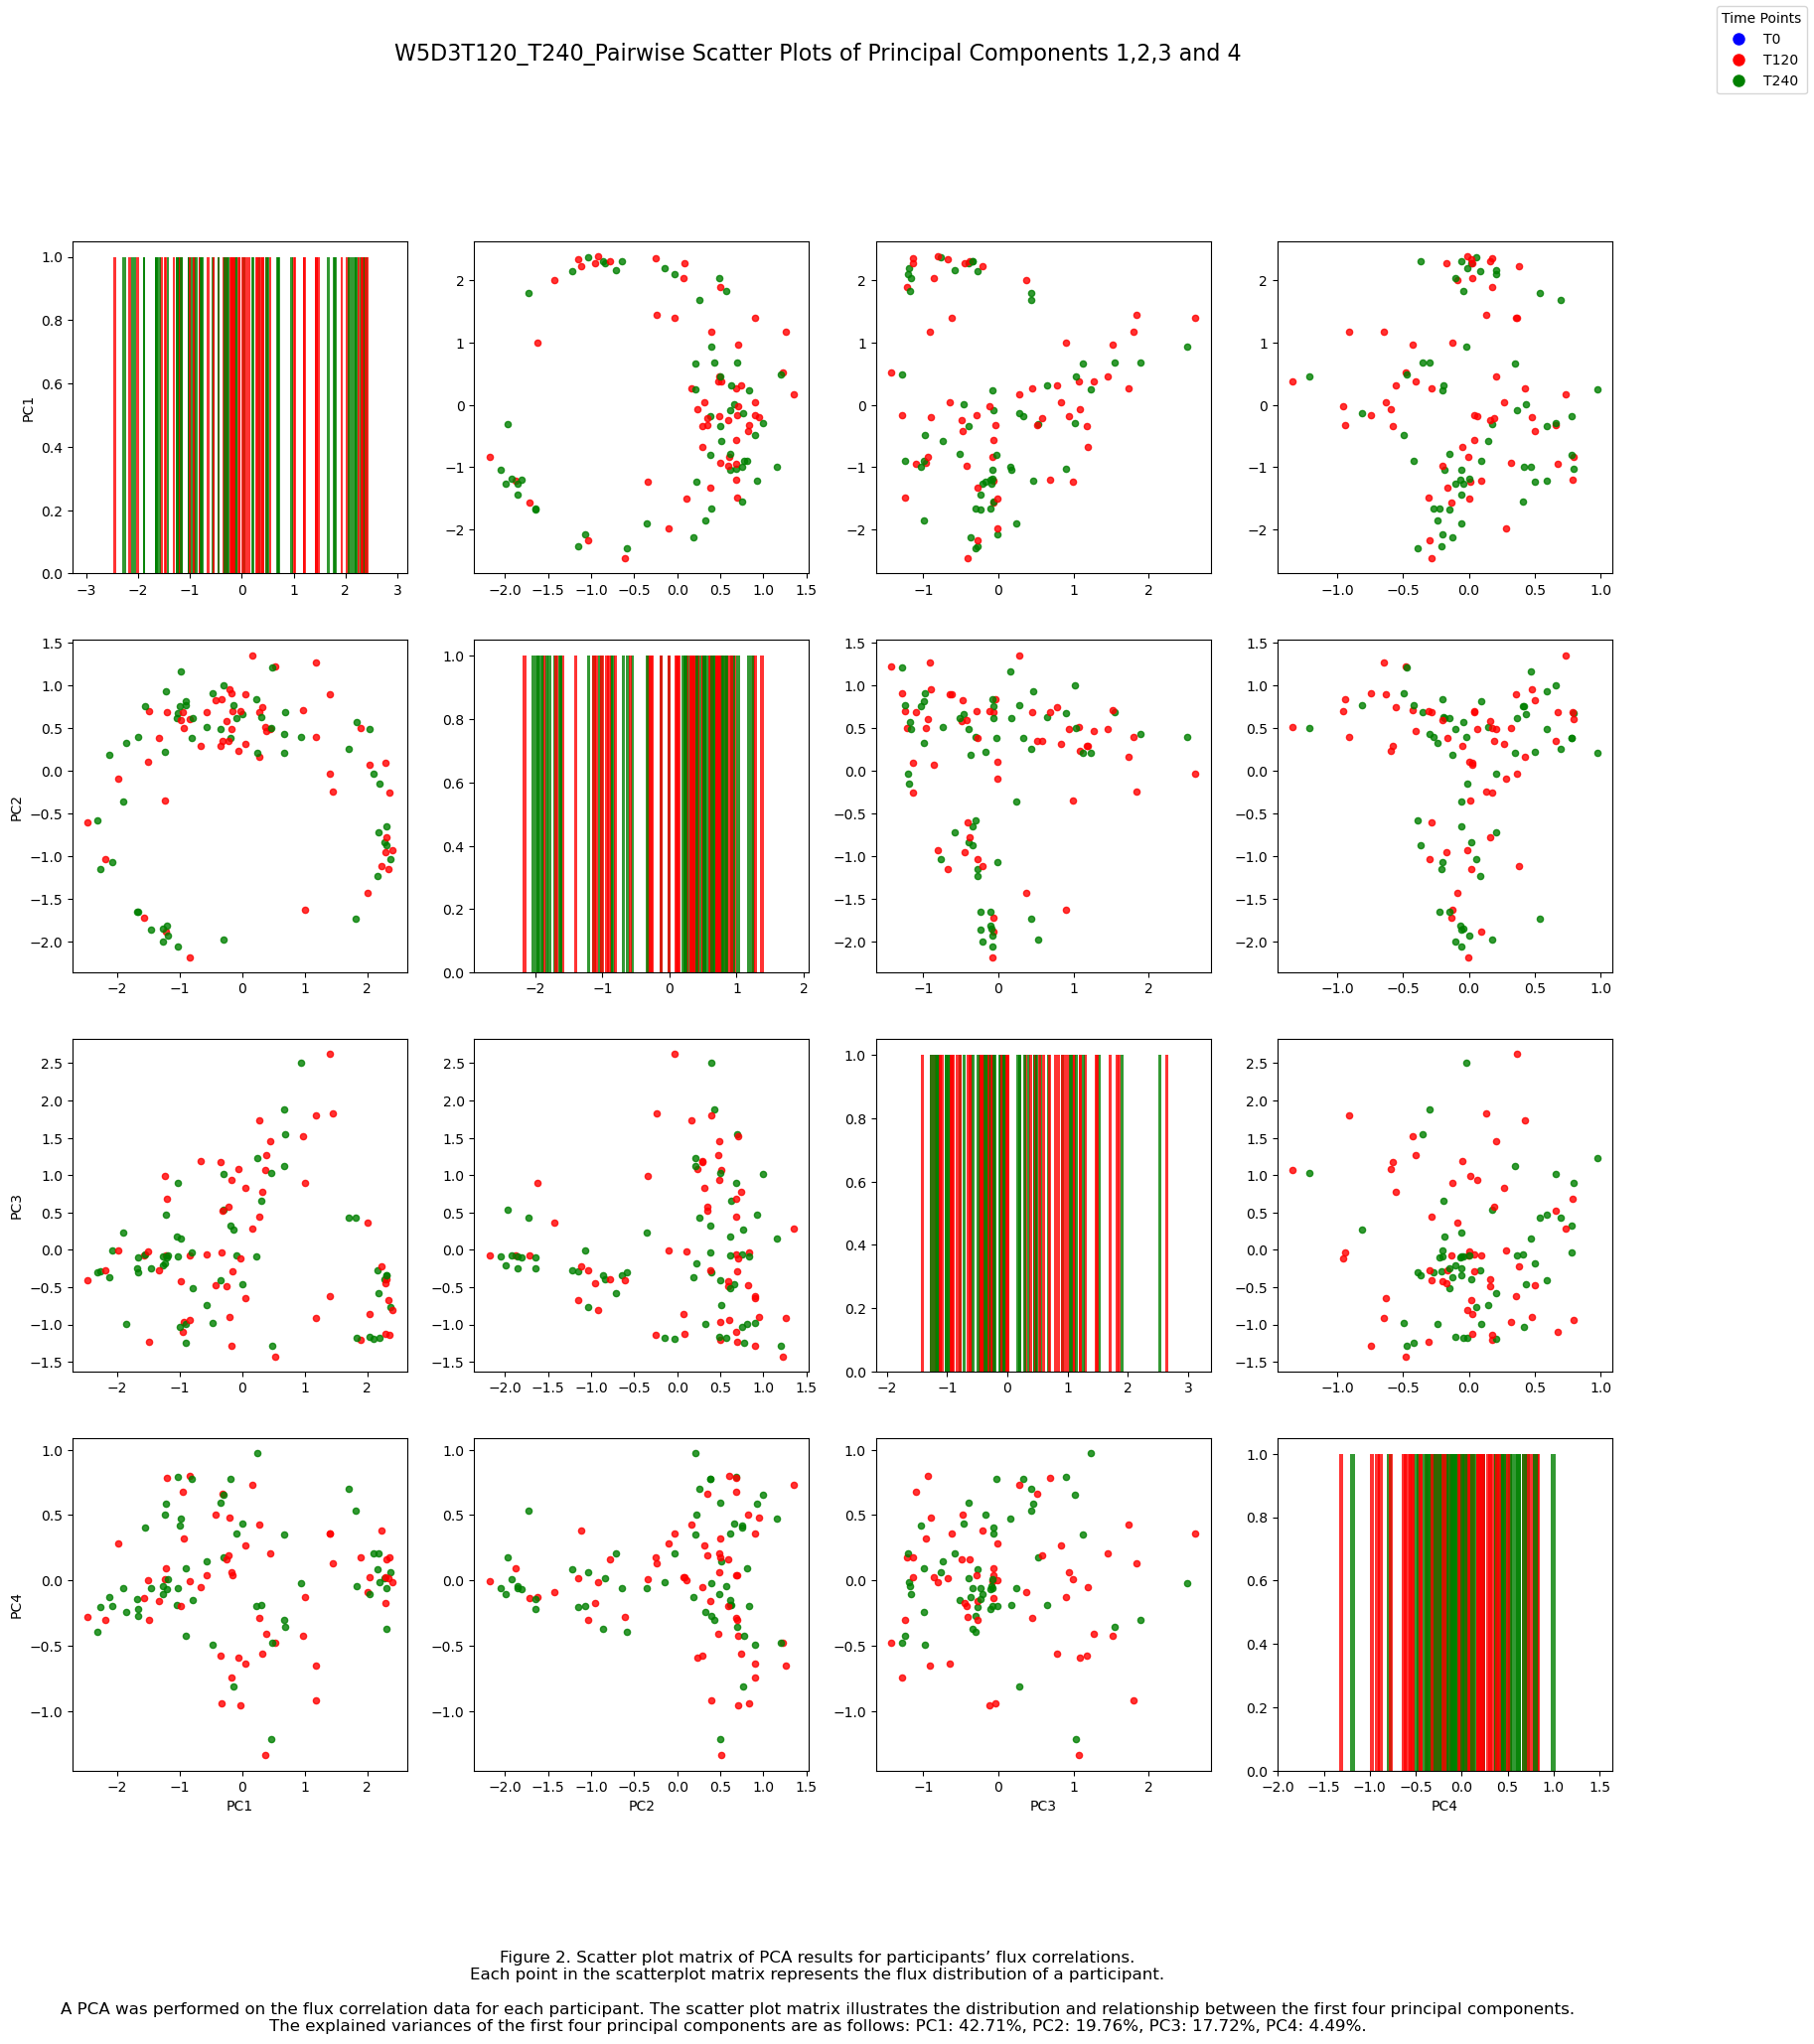

In [4]:
# Set the file_ID for naming plots and saved figures
file_ID = 'W5D3T120_T240'
flxID= 'pw_flx2_7.csv'
# %% Load the context-specific models
directory_path = f'/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/{file_ID}'
context_specific_models = []
for filename in os.listdir(directory_path):
    if filename.endswith(".mat"):
        file_path = os.path.join(directory_path, filename)
        model = load_matlab_model(file_path)
        context_specific_models.append(model)

print(f"Loaded {len(context_specific_models)} models.")

path_ref = '/Users/douglas/Library/CloudStorage/OneDrive-UniversityCollegeCork/Msc Bioinformatics and Computational Biology/MB6303 Dissertion in Bioinformatics & Computational Biology/Practical Work/python_/week 11, Get FBA working or Sampling,/Recon3D.mat'
ref_model = load_matlab_model(path_ref)

# Convert the list of models to a list of paths
file_paths = [Path(os.path.join(directory_path, f)) for f in os.listdir(directory_path) if f.endswith(".mat")]

# Call the load_library function to get the flux dataframe
reactions_matrix, metabolite_matrix, gene_matrix, flx_df = load_library(file_paths, ref_model, sampling=False, FBA=True)
#rxn, met, gen, graphlist, flx = load_library(file_paths, ref_model, sampling= False, FBA= True)


# Check the flux data frame
print(flx_df.head())

#%% Perform flux correlation between pairs of models
pw_flx = flux_DM(flx_df)
pw_flx
# Save pw_flx1 as a CSV file
pw_flx.to_csv(f'{flxID}', index=False)

import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your pw_flx3 data from the CSV file
pw_flxload = pd.read_csv(f'{flxID}')

# Extract sample labels (T0, T120, or T240) from the column names
labels = [col.split('T')[-1] for col in pw_flxload.columns]


# Perform PCA
pca = PCA(n_components=3)
pcaData = pca.fit_transform(pw_flxload.T)  # Transpose to make samples as rows
print(pca.explained_variance_ratio_)

title_font = {
    'weight': 'medium',
    'size': 12,
}
axis_font = {
    'weight': 'normal',
    'size': 10,
}

# Color coding based on time points
colors = ['blue' if label == '0' else 'red' if label == '120' else 'green' for label in labels]

# Plot PCA scatter plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
for i in range(len(labels)):
    xs = pcaData[i, 0]
    ys = pcaData[i, 1]
    plt.scatter(xs, ys, s=20, marker='o', color=colors[i], alpha=0.8)

# Add legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='T240')]
plt.legend(handles=handles, title="Time Points")

plt.title(f'{file_ID}_PCA for Flux Correlation Between PBMC Models (PC1 vs PC2)', title_font)
plt.xlabel('PC1: {:.1%}'.format(pca.explained_variance_ratio_[0]), axis_font)
plt.ylabel('PC2: {:.1%}'.format(pca.explained_variance_ratio_[1]), axis_font)
plt.figtext(0.5, -0.23, (f'Figure 1. PCA results for the flux correlations.\n Each point in the scatterplot represents a participant\'s context-specific model.\n\n The explained variances of the first and second principal components were {pca.explained_variance_ratio_[0]*100:.2f}% and {pca.explained_variance_ratio_[1]*100:.2f}%, respectively, resulting in a combined variance of {((pca.explained_variance_ratio_[0]*100)+(pca.explained_variance_ratio_[1]*100)):.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'{file_ID}_fig.1_PCA_for_Flux_Correlation.png', dpi=1000)

####################### Create a 4x4 plot matrix of PC1, PC2, PC3, and PC4
# Perform PCA
pca = PCA(n_components=4)
pcaData = pca.fit_transform(pw_flxload.T)
explained_variance = pca.explained_variance_ratio_

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

pc_labels = ['PC1', 'PC2', 'PC3', 'PC4']
components = [pcaData[:, 0], pcaData[:, 1], pcaData[:, 2], pcaData[:, 3]]

for i in range(4):
    for j in range(4):
        if i == j:
            for k, c in zip(components[i], colors):
                axs[i, j].hist(k, bins=20, color=c, alpha=0.8)
        else:
            for x, y, c in zip(components[j], components[i], colors):
                axs[i, j].scatter(x, y, color=c, s=20, alpha=0.8)
        if i == 3:
            axs[i, j].set_xlabel(pc_labels[j])
        if j == 0:
            axs[i, j].set_ylabel(pc_labels[i])

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='T0'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='T120'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='T240')]
fig.legend(handles=handles, title="Time Points", loc='upper right')

plt.suptitle(f'{file_ID}_Pairwise Scatter Plots of Principal Components 1,2,3 and 4', fontsize=16, weight='medium')
plt.figtext(0.5, -0.02, (f'Figure 2. Scatter plot matrix of PCA results for participants’ flux correlations.\n'
                         f'Each point in the scatterplot matrix represents the flux distribution of a participant.\n\n'
                         f'A PCA was performed on the flux correlation data for each participant. The scatter plot matrix illustrates the distribution and relationship between the first four principal components.\n'
                         f'The explained variances of the first four principal components are as follows: PC1: {explained_variance[0]*100:.2f}%, PC2: {explained_variance[1]*100:.2f}%, PC3: {explained_variance[2]*100:.2f}%, PC4: {explained_variance[3]*100:.2f}%.'), wrap=True, horizontalalignment='center', fontsize=12)

plt.savefig(f'{file_ID}_fig.2_Pairwise_Scatter_Plots_of_PC1_to_PC4.png', dpi=1000)
plt.show()
